In [155]:
import numpy as np
import pandas as pd
import paranoid as pns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize

import ddm
import ddm.plot
import paranoid as pns
pns.settings.Settings.set(enabled=False)

# pyddm simulation

### Fitting using pyddm

In [499]:
class LossByMeans(ddm.LossFunction):
    name = "Mean correct RT and accuracy"
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
        self.exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
        
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        MSE = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            mean_rt_exp_cor = self.exp_data[(self.exp_data.tta_condition == comb['tta_condition']) & 
                                            self.exp_data.is_turn_decision == True].RT.mean()
            comb_sample = self.sample.subset(**comb)
            MSE += (sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                MSE += (sols[c].mean_decision_time() - mean_rt_exp_cor)**2
        return MSE
    
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        sols = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(sols[c].prob_correct() - comb_sample.prob_correct())**2
            if sols[c].prob_correct() > 0:
                model_rt_q = self.get_rt_quantiles(sols[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                # this is modified from R&T 2002: *comb_sample.prob_correct() is removed to improve RT fit at low-p trials
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

In [505]:
def get_model_measures(model, tta_condition):
    sol = model.solve(conditions={'tta_condition': tta_condition})
    return tta_condition, sol.prob_correct(), sol.mean_decision_time()
        
def plot_comparison_basic(exp_data, fit_model):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))
    model_measures = [get_model_measures(fit_model, tta_condition) for tta_condition in exp_data.tta_condition.unique()]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'is_turn_decision', 'RT'])
    
    sns.pointplot(ax=ax1, data=exp_data, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax1, data=model_measures, x='tta_condition', y='is_turn_decision', marker='s', color='grey')
    ax1.set_ylabel('p(turn)')
    
    sns.pointplot(ax=ax2, data=exp_measures[exp_measures.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax2, data=model_measures, x='tta_condition', y='RT', marker='s', color='grey')
    
def plot_comparison_rt_pdf(exp_data, fit_model):
    fig, axes = plt.subplots(1,3,figsize=(10,3))
    for i, tta_condition in enumerate(exp_data.tta_condition.unique()):
        sol = fit_model.solve(conditions={'tta_condition': tta_condition})
        axes[i].plot(fit_model.t_domain(), sol.pdf_corr()/sol.prob_correct(), label='Model')
        sns.kdeplot(ax=axes[i], data=exp_data[exp_data.is_turn_decision & (exp_data.tta_condition==tta_condition)].RT, 
                    label='Experiment')
        axes[i].set_xlabel('RT')
        axes[i].set_title('TTA=%.0fs' % tta_condition)
        axes[i].get_legend().remove()
    axes[0].set_ylabel('pdf')
    axes[2].legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
def visualize_model_fit(exp_data, fit_model):
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Parameters: ', fit_model.get_model_parameters())
    plot_comparison_basic(exp_data, fit_model)
    plot_comparison_rt_pdf(exp_data, fit_model)

In [487]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

### DDM with fixed drift 

In [513]:
class DriftPerCondition(ddm.models.Drift):
    name = 'Fixed drift depending on TTA condition'
    required_parameters = ['alpha']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, conditions, **kwargs):
        return self.alpha*conditions['tta_condition']

In [517]:
model_fixed_drift = ddm.Model(name='Model with drift depending on TTA condition',
                             drift=DriftPerCondition(alpha=ddm.Fittable(minval=0.1, maxval=5)),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
#                              overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
#                                                                    halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                             T_dur=2.5)

In [518]:
%time fit_model_fixed_drift = ddm.fit_adjust_model(sample=exp_sample, model=model_fixed_drift, lossfunction=LossWLS)

[1.3670132517918419, 2.145651611117036]
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.7043306150583364, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.3656974692489405, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.7953424798660915
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.4733067795138723, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.4998861370645233, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.780410506365171
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.0306382244135692, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.2917724681738101, minval=0.1, maxval=3.0)), IC=ICPointSourceCente

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.764685373221616, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9987802795656794, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.176486634936651
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.7053943635494941, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4636611754727025, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.548036846624688
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.4290424405373434, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.43356691180091134, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.8303704006915353, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.0028330409084556, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.946017831522553
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.5024389911397877, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7399910734308797, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.015841826371902
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.373480153903527, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.181369771805567, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.660502817614414, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1496161782360048, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.077196941319306
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.49621682468714834, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8006498990636113, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.650849477418504
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.7470870845024198, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.147349324147248, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.3561283728277302, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.528771232703172, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.67428840468576
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.23196851070450597, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.858146216357877, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.467906397076447
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.825750452423953, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4005419125322498, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.560603106213945, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6288985711987827, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.502882918192039
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.2032914423604084, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9321945365886377, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.6682243260606295
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.6359782185446949, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.048372753178131, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.180082362257453, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.45504781961640073, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=2.354295245957454
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.153842930301949, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.379093251279511, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.211454786399561
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.1150412994394305, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.8398856904467848, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.1674048101755305, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.33450753144551126, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.556446998396164
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.8506451309977465, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.1944643988189245, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.378805997663433
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.6341464192893704, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.36481314556897, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.92129401340852, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.36696088537320803, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.601972916177045
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.14381381696164874, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9419203940670996, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9029548071847877
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.568825714804413, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5092556925529126, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.8435126482176634, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3997774144702453, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.381256381523577
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1293890050949198, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5861460874761862, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7226269309785334
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.2245314058342993, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6756175087395047, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1716612338700796, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.6550224707547083, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=3.8012293699755593
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.11466128604004222, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.2009698360228258, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=2.23324645369288
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.2203675823875426, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5889001108379146, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.47922173719656724, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.436028048938629, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.275186883733468
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.7629381146473588, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1809071296835985, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=4.929824254077159
differential_evolution step 8: f(x)= 1.31067
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1400340636250781, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7243299373976838, minval=0.1, maxval=3.0)), IC=ICPointSourceC

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.205208094404311, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0337097244398543, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.338578310269745
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.14447206434784832, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.87142710251876, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7898054016263298
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.925037997687803, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9491722449531323, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.14704911030872303, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9419203940670996, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9403729552155946
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.852904444394857, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5932954519086646, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.479870365986358
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.14590803122938967, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5667309714538201, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, d

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.5945369893909582, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6756175087395047, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.054367965210325
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1257622568667025, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7696962863689245, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4940392208600066
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.333519049980724, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5730078145198678, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1368424180847838, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8383680836942297, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6600751317238882
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.11976618987316812, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7822292188432807, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4333124362106153
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.12341781510086491, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0519790978823886, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005,

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1282843985021045, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6858862380417341, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5550532218692
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.4564969181629435, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9382046084906241, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.3911511435267805
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1716612338700796, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8698543892267887, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1280022752455765, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9753239337379378, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7925942114123987
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.878778059379148, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9314183240725418, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.230110227672659
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10540405747938486, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8186660086235656, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.13372770219658836, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6676670861812658, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6263062834131574
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.14447206434784832, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.921534825278564, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.871974319167317
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.12309925455085846, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7262038609854425, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, 

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.5045967061884187, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7340504360398036, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.278109382235917
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.8400117011060773, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9463320148145786, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.21635066553053
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.12222764128286023, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7564750609801765, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.11076000144594644, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5719641198211681, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6182676682012749
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.409168701824381, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6739249339063478, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.480016389181114
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.12019126902188715, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7390645679730196, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, d

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.815651543181885, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7664275778038598, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.306054268664605
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(3.455669377173016, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7317526121324983, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.392858892568543
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.331902022045699, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6862954262872085, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.048292311409856, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5634118737102368, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.917910227989513
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.9097998352834775, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6683349599161975, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.50493797135311
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.12475922041179244, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6829381188417658, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.31609851260750643, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8118011058418066, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=3.550372581976228
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10259942717372139, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7634083195796568, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2597755267207147
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.5657868827261243, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7755747998053039, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, 

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10087972592635719, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.775979536277902, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2421411541987435
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10083525302544727, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.749122733216545, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.247416160708172
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.11495662805152174, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.903588704372616, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10199039135232191, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.700314563560642, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2970044638806268
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10058810859335487, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.759735242074272, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2414691424616089
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.986024051096789, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8114509120674027, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.3665029459281002, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5973174734024173, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.088674994342223
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10073070918877791, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7682976428569518, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2411881939806793
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10010472540994186, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7817534846174606, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, 

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(2.491313787543092, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7779112357182485, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.250145092527371
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10056377611478018, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7558318938945336, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2423728219170742
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10023162738099867, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7776692047182324, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, d

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.0589635487555322, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7418909592959134, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.759339243723501
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10024289502815265, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7815464783361514, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.236237602298963
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10170725696691862, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7564437958705231, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, d

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.349306695825211, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7541021682237532, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=5.932577669990081
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.829366954454052, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7581251684874569, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.472615015797233
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1000509694646925, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.748436844518163, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(4.5238053456724066, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.759735242074272, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=6.456363731479983
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10062525342900663, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7601455512332225, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2417145448607307
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(1.8002375504571924, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.79211193116723, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10135285469383826, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7624337095474027, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.248077969386
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1000382253717289, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7682976428569518, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.234603081240813
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10014007737118735, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7530876871257279, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0

Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8228373023392987, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2501064555354644
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.10000001, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8228373023392987, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2501065547233106
Model(name='Model with drift depending on TTA condition', drift=DriftPerCondition(alpha=Fitted(0.1, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8228373123392988, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNone(), dx=0.005, dt=0.002, T_dur=2.5) loss=1.25010646250

Loss function value: 1.23371
Parameters:  [Fitted(0.1, minval=0.1, maxval=5), 1, Fitted(0.776516781701389, minval=0.1, maxval=3.0)]


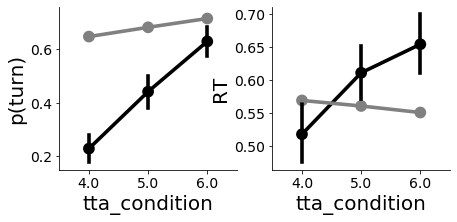

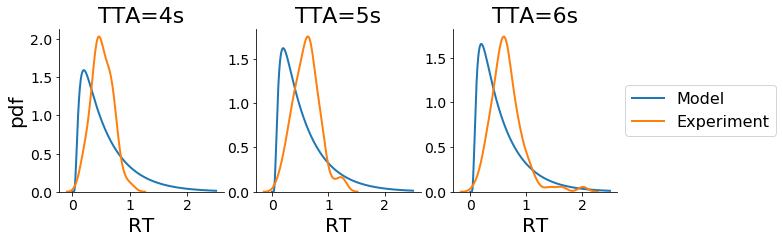

In [519]:
visualize_model_fit(exp_data, fit_model_fixed_drift)

### DDM with variable drift

In [520]:
class DriftTta(ddm.models.Drift):
    name = 'Drift depends on time and critical TTA (parameter)'
    required_parameters = ['alpha', 'tta_crit']
    required_conditions = ['tta_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        current_tta = conditions['tta_condition'] - t
        return self.alpha*(current_tta - self.tta_crit)

In [521]:
model_var_drift = ddm.Model(name='Model with drift depending on TTA',
                 drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                tta_crit=ddm.Fittable(minval=2, maxval=6)),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                 overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                       halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                 T_dur=2.5)

In [522]:
%time fit_model_var_drift = ddm.fit_adjust_model(sample=exp_sample, model=model_var_drift, lossfunction=LossWLS)

[1.8636898621099451, 4.381506636110273, 1.4566668943265417, 0.28083728832619226, 0.06756163547852145]
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.1321574729062203, minval=0.1, maxval=5), tta_crit=Fitted(2.7925384107598505, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.539022390475016, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2386197422619144, minval=0, maxval=0.5), halfwidth=Fitted(0.06567149972312308, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.736407814520709
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.22997080405102, minval=0.1, maxval=5), tta_crit=Fitted(2.252815417825639, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.7706066912076808, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.149190918016575, m

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6687374980108822, minval=0.1, maxval=5), tta_crit=Fitted(5.831743159858753, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5596284399589576, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2887156288988376, minval=0, maxval=0.5), halfwidth=Fitted(0.10511697505193404, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20058462624742918
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.0151165210649244, minval=0.1, maxval=5), tta_crit=Fitted(2.0431275113621226, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5890532901707155, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30855415866448505, minval=0, maxval=0.5), halfwidth=Fitted(0.2051182342713232, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.4238611158094363, minval=0.1, maxval=5), tta_crit=Fitted(3.7885926077173973, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1337286631813968, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4906009140158396, minval=0, maxval=0.5), halfwidth=Fitted(0.14350966317058095, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.155705315037086
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.688902725003539, minval=0.1, maxval=5), tta_crit=Fitted(5.682484716387417, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.0110984544292565, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.014173729565917337, minval=0, maxval=0.5), halfwidth=Fitted(0.2464403348455895, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9637619015891619, minval=0.1, maxval=5), tta_crit=Fitted(4.135166966470872, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.6472292825211436, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26196658259577255, minval=0, maxval=0.5), halfwidth=Fitted(0.03969647379735934, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.75375864488756
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.8745021699531685, minval=0.1, maxval=5), tta_crit=Fitted(2.3512579334782755, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.863319768557375, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3322002362744175, minval=0, maxval=0.5), halfwidth=Fitted(0.08968719756105854, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.4907679179537339, minval=0.1, maxval=5), tta_crit=Fitted(3.2975979341510673, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7434203660839254, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2715788779595603, minval=0, maxval=0.5), halfwidth=Fitted(0.12072951246084582, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.4376601221947998
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.9617761648348666, minval=0.1, maxval=5), tta_crit=Fitted(5.272333467142619, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.48230419581483885, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0745791405515639, minval=0, maxval=0.5), halfwidth=Fitted(0.2169491381213156, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.643964439446463, minval=0.1, maxval=5), tta_crit=Fitted(5.743600554190245, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.2751329477114453, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0241537949236256, minval=0, maxval=0.5), halfwidth=Fitted(0.11965975340347577, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2114262932262
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.319149484137495, minval=0.1, maxval=5), tta_crit=Fitted(2.5687914538893004, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.1407002870993304, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4287976311467498, minval=0, maxval=0.5), halfwidth=Fitted(0.02634285720309866, minval=0.0, maxval=0.25)), dx=0.005, dt=0.

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.7274904325784999, minval=0.1, maxval=5), tta_crit=Fitted(4.3987796812660775, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4377755329029098, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14272386458527808, minval=0, maxval=0.5), halfwidth=Fitted(0.09219598213494952, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2431601822419613
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.780180890665954, minval=0.1, maxval=5), tta_crit=Fitted(5.648660197674971, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.4283771086016515, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.353908617212789, minval=0, maxval=0.5), halfwidth=Fitted(0.02766628098168826, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.9691730370298088, minval=0.1, maxval=5), tta_crit=Fitted(4.80013921292244, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0061724805822152, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.035172832036410584, minval=0, maxval=0.5), halfwidth=Fitted(0.1589232977208938, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8297920191020544
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.854212029358432, minval=0.1, maxval=5), tta_crit=Fitted(3.0657903920940326, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.074820165148226, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2671572812700112, minval=0, maxval=0.5), halfwidth=Fitted(0.17279941233814108, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.37399607831418846, minval=0.1, maxval=5), tta_crit=Fitted(4.665196358778422, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.0910737104178683, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3114981780640565, minval=0, maxval=0.5), halfwidth=Fitted(0.17043213118107348, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.969757478912992
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.0076378379621604, minval=0.1, maxval=5), tta_crit=Fitted(4.64022762182119, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.141096680632734, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23259143668430143, minval=0, maxval=0.5), halfwidth=Fitted(0.11238537409573417, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9733137279057733, minval=0.1, maxval=5), tta_crit=Fitted(5.423617012361653, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0883312562919898, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4656425666528626, minval=0, maxval=0.5), halfwidth=Fitted(0.014722049636194709, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.177065468553609
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.43055738921520437, minval=0.1, maxval=5), tta_crit=Fitted(5.00341433051708, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.122366375152974, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.355301596017411, minval=0, maxval=0.5), halfwidth=Fitted(0.19021491530584764, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.9890102544642314, minval=0.1, maxval=5), tta_crit=Fitted(4.9946971330847525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3514927915766488, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.48561208451600146, minval=0, maxval=0.5), halfwidth=Fitted(0.10466287825372231, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4368781072303579
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.1427004823353055, minval=0.1, maxval=5), tta_crit=Fitted(5.967300643167386, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4285245896548251, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32096901637720215, minval=0, maxval=0.5), halfwidth=Fitted(0.1234876841098321, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.1132354603252848, minval=0.1, maxval=5), tta_crit=Fitted(3.4515707030289664, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.9871214531876578, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22139052040830315, minval=0, maxval=0.5), halfwidth=Fitted(0.0092856160298362, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.065620566049953
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.8093771490657113, minval=0.1, maxval=5), tta_crit=Fitted(4.584982080052386, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0730909739028842, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17804359772272416, minval=0, maxval=0.5), halfwidth=Fitted(0.14502808123313618, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.171853505493994, minval=0.1, maxval=5), tta_crit=Fitted(5.018990778910416, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.8029868317125397, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24603810682594995, minval=0, maxval=0.5), halfwidth=Fitted(0.014517357640323705, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7371756197045665
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.4519091622727787, minval=0.1, maxval=5), tta_crit=Fitted(4.691806256321415, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.22614884408079372, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18267383788438113, minval=0, maxval=0.5), halfwidth=Fitted(0.20041942000833646, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5267295345832248, minval=0.1, maxval=5), tta_crit=Fitted(2.683570729375788, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6529421645227607, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33564076405834337, minval=0, maxval=0.5), halfwidth=Fitted(0.10436350640968416, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.611757840890424
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.9817631359548153, minval=0.1, maxval=5), tta_crit=Fitted(5.097241979770361, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.2640521521981292, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2706118267028847, minval=0, maxval=0.5), halfwidth=Fitted(0.00484773262197126, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.1573724994414434, minval=0.1, maxval=5), tta_crit=Fitted(4.995043017581885, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6678237622786037, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4009635383353165, minval=0, maxval=0.5), halfwidth=Fitted(0.028908362728642154, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5695828736684486
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0716110630872941, minval=0.1, maxval=5), tta_crit=Fitted(3.7530842470049146, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.33822167702449035, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14149405267924783, minval=0, maxval=0.5), halfwidth=Fitted(0.18926565384955418, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.8234436967670402, minval=0.1, maxval=5), tta_crit=Fitted(3.3109739166147603, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5984683082976576, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.329139999001102, minval=0, maxval=0.5), halfwidth=Fitted(0.1522864064660665, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1832404738480307
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5291837094855318, minval=0.1, maxval=5), tta_crit=Fitted(5.575302566129465, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.688241528197609, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14534886498031196, minval=0, maxval=0.5), halfwidth=Fitted(0.23409190943416133, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.5219443060568216, minval=0.1, maxval=5), tta_crit=Fitted(5.354462755532062, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0173644427171298, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27695174033586073, minval=0, maxval=0.5), halfwidth=Fitted(0.03996181143089739, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9196719625411375
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.3808340001102164, minval=0.1, maxval=5), tta_crit=Fitted(5.8886419208979, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9299013714884528, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.393735698625824, minval=0, maxval=0.5), halfwidth=Fitted(0.13475682597883631, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.12774443451229267, minval=0.1, maxval=5), tta_crit=Fitted(4.625043847641866, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6260422583558146, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19884592847991744, minval=0, maxval=0.5), halfwidth=Fitted(0.24485843344863154, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.33956330942044965
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.2289347082216575, minval=0.1, maxval=5), tta_crit=Fitted(3.9837032383483546, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.095016990099201, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11441163501020157, minval=0, maxval=0.5), halfwidth=Fitted(0.009739435168485688, minval=0.0, maxval=0.25)), dx=0.0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6375015244413973, minval=0.1, maxval=5), tta_crit=Fitted(5.085028002002431, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.17853463283519266, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09874780778026573, minval=0, maxval=0.5), halfwidth=Fitted(0.042483055719827384, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7621253639961836
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.4612564094980125, minval=0.1, maxval=5), tta_crit=Fitted(4.754334742723421, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.3340636145212699, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3958400986250462, minval=0, maxval=0.5), halfwidth=Fitted(0.11049034272229695, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7351239918033143, minval=0.1, maxval=5), tta_crit=Fitted(5.363959894708993, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3663188602420715, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47728745276850165, minval=0, maxval=0.5), halfwidth=Fitted(0.1003610417078579, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13969807924614727
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.0076378379621604, minval=0.1, maxval=5), tta_crit=Fitted(4.64022762182119, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.44849147093496744, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40663530066902837, minval=0, maxval=0.5), halfwidth=Fitted(0.10913241673850896, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.10895281532074907, minval=0.1, maxval=5), tta_crit=Fitted(5.295526830861522, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6209842366086851, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3759172166982711, minval=0, maxval=0.5), halfwidth=Fitted(0.12931254618980312, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.40019880682657305
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9618783424699082, minval=0.1, maxval=5), tta_crit=Fitted(5.00341433051708, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.21501837577669414, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11781740060275808, minval=0, maxval=0.5), halfwidth=Fitted(0.1540242719836446, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.125155849590957, minval=0.1, maxval=5), tta_crit=Fitted(5.603589854410945, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.8841324215242965, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.431559399667394, minval=0, maxval=0.5), halfwidth=Fitted(0.14069236940930208, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.236696798587081
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.44632495171484354, minval=0.1, maxval=5), tta_crit=Fitted(5.340056201498122, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.22657045160852407, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22359168660469353, minval=0, maxval=0.5), halfwidth=Fitted(0.08860741584674056, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.21911046033102188, minval=0.1, maxval=5), tta_crit=Fitted(5.362753976783651, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4232846671140562, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44425536513553515, minval=0, maxval=0.5), halfwidth=Fitted(0.1847926970937686, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25327141954053034
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(3.7294391921375283, minval=0.1, maxval=5), tta_crit=Fitted(4.917218427001289, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.075980108220324, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34750242491258265, minval=0, maxval=0.5), halfwidth=Fitted(0.07459639653171816, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.15619272458639744, minval=0.1, maxval=5), tta_crit=Fitted(5.626178847745888, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.18705141367300215, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30791170965140713, minval=0, maxval=0.5), halfwidth=Fitted(0.03451092027715072, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8187418231766381
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0565033059894529, minval=0.1, maxval=5), tta_crit=Fitted(5.5651823557632625, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.28416937119138486, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31895498990760174, minval=0, maxval=0.5), halfwidth=Fitted(0.07723735384752203, minval=0.0, maxval=0.25)), dx=0.

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2948743188064078, minval=0.1, maxval=5), tta_crit=Fitted(5.588367219785921, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.38027698604865257, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3488615238126786, minval=0, maxval=0.5), halfwidth=Fitted(0.12514587145693049, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2135867754696265
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.901386068483938, minval=0.1, maxval=5), tta_crit=Fitted(5.10215110052763, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.7628652687387922, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4032785214559696, minval=0, maxval=0.5), halfwidth=Fitted(0.03669007080376266, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.975121265022976, minval=0.1, maxval=5), tta_crit=Fitted(5.624807353378712, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0900505791519632, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39541523048844396, minval=0, maxval=0.5), halfwidth=Fitted(0.1203005803804824, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7461839125979624
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2968584665027256, minval=0.1, maxval=5), tta_crit=Fitted(4.148605622439408, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8659502556396393, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42814101883434985, minval=0, maxval=0.5), halfwidth=Fitted(0.1277286970300934, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.7777938415807306, minval=0.1, maxval=5), tta_crit=Fitted(4.714343238561339, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.30545006624898297, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3601662192710093, minval=0, maxval=0.5), halfwidth=Fitted(0.1385588775625263, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.37960008089081326
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.6088042099535245, minval=0.1, maxval=5), tta_crit=Fitted(4.861506008864204, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.8168200396069445, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.171762596139081, minval=0, maxval=0.5), halfwidth=Fitted(0.06538088188683716, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.848010587495727, minval=0.1, maxval=5), tta_crit=Fitted(5.422463677289239, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5952762675799034, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36448754896046415, minval=0, maxval=0.5), halfwidth=Fitted(0.03698345512693875, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7355236697955007
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9273608910372866, minval=0.1, maxval=5), tta_crit=Fitted(4.609345854327969, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6979682210205, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08874606223670012, minval=0, maxval=0.5), halfwidth=Fitted(0.13134151946267114, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.562819903808998, minval=0.1, maxval=5), tta_crit=Fitted(5.269150227668295, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.42925589048667145, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45946153014973024, minval=0, maxval=0.5), halfwidth=Fitted(0.03991367240606421, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4436309573009369
differential_evolution step 4: f(x)= 0.0530542
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.10851726118189342, minval=0.1, maxval=5), tta_crit=Fitted(5.773374049341448, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5107094653672579, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2368022480666236, minval=0, maxval=0.5), halfwidth=Fitted(0.16733805

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5501334778549614, minval=0.1, maxval=5), tta_crit=Fitted(5.131527131754613, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3867470693663393, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36423263628015595, minval=0, maxval=0.5), halfwidth=Fitted(0.06567149972312308, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20587301714762335
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.199797203234088, minval=0.1, maxval=5), tta_crit=Fitted(4.669780002022312, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.44721278179731505, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37166058826261156, minval=0, maxval=0.5), halfwidth=Fitted(0.11476405669271302, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.492132662632072, minval=0.1, maxval=5), tta_crit=Fitted(5.638680506812402, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.6330275877016638, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4337315347401647, minval=0, maxval=0.5), halfwidth=Fitted(0.16484904157101693, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.623516254015876
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0980191707137645, minval=0.1, maxval=5), tta_crit=Fitted(5.657945312367437, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.12793299707083405, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17584354564122523, minval=0, maxval=0.5), halfwidth=Fitted(0.009015388247080994, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.863830553626771, minval=0.1, maxval=5), tta_crit=Fitted(3.1255369866712477, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3203984202399788, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2834443032521583, minval=0, maxval=0.5), halfwidth=Fitted(0.24215990516036323, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.496067787253534
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0572746068410235, minval=0.1, maxval=5), tta_crit=Fitted(4.107338018231097, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.10958948572547889, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.235892737840126, minval=0, maxval=0.5), halfwidth=Fitted(0.09640489737822686, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.10035871164319676, minval=0.1, maxval=5), tta_crit=Fitted(5.983825878462108, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.2606585841379718, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33331961453634246, minval=0, maxval=0.5), halfwidth=Fitted(0.21973549762251304, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6093796465028316
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.7506825463724938, minval=0.1, maxval=5), tta_crit=Fitted(5.650565346465283, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.108177245850266, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4478716211685059, minval=0, maxval=0.5), halfwidth=Fitted(0.0901429346303145, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.3941381891013733, minval=0.1, maxval=5), tta_crit=Fitted(4.735997449410306, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3805920579157396, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47169527704834724, minval=0, maxval=0.5), halfwidth=Fitted(0.15331345607328753, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2092166714993193
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.21911046033102188, minval=0.1, maxval=5), tta_crit=Fitted(4.854249418257915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.47614051671967816, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.06813930141168839, minval=0, maxval=0.5), halfwidth=Fitted(0.1932963567800559, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0565033059894529, minval=0.1, maxval=5), tta_crit=Fitted(5.5651823557632625, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9716372810115435, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12062064254296545, minval=0, maxval=0.5), halfwidth=Fitted(0.17852251502503322, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8561788008633417
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7717667495439822, minval=0.1, maxval=5), tta_crit=Fitted(4.859917587725739, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.39234141189687466, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07370981023118839, minval=0, maxval=0.5), halfwidth=Fitted(0.0318019030385958, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.8763545331142972, minval=0.1, maxval=5), tta_crit=Fitted(5.517438684461998, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4430458326381792, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3628151535446568, minval=0, maxval=0.5), halfwidth=Fitted(0.09202961916137667, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.3970692824960205
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.605349286743024, minval=0.1, maxval=5), tta_crit=Fitted(4.789485215196962, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5119423961142489, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4082197012236636, minval=0, maxval=0.5), halfwidth=Fitted(0.13163526217274482, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.1042945131751436, minval=0.1, maxval=5), tta_crit=Fitted(3.0460098548217838, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.4855482458881704, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.45353784135473263, minval=0, maxval=0.5), halfwidth=Fitted(0.14492898437375168, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.9691389417795895
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.1770129112799661, minval=0.1, maxval=5), tta_crit=Fitted(4.952613176969372, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6678237622786037, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3622831165190777, minval=0, maxval=0.5), halfwidth=Fitted(0.11045244956830391, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8033658327342894, minval=0.1, maxval=5), tta_crit=Fitted(5.085431175488328, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(2.3694401329396255, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07319119257361562, minval=0, maxval=0.5), halfwidth=Fitted(0.14417809373191787, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.843386057665955
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.18002811949597275, minval=0.1, maxval=5), tta_crit=Fitted(3.3109739166147603, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.20743936768975635, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3789885154019951, minval=0, maxval=0.5), halfwidth=Fitted(0.22715157864829205, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.5353535003314454, minval=0.1, maxval=5), tta_crit=Fitted(4.4323266194585695, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.8100478349065685, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09456003101344895, minval=0, maxval=0.5), halfwidth=Fitted(0.09697022630394905, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1600434183949297
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.1809795352131145, minval=0.1, maxval=5), tta_crit=Fitted(5.4859449588557805, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6446845483044068, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26275107480071297, minval=0, maxval=0.5), halfwidth=Fitted(0.03996181143089739, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.5243808935514902, minval=0.1, maxval=5), tta_crit=Fitted(4.798578536615081, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8295355232027768, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24152327861486497, minval=0, maxval=0.5), halfwidth=Fitted(0.17048454219801248, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35823982549335287
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.5972402801601993, minval=0.1, maxval=5), tta_crit=Fitted(4.82119204782315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8188897798514175, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4132333642890071, minval=0, maxval=0.5), halfwidth=Fitted(0.14070392600582288, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7137835501326211, minval=0.1, maxval=5), tta_crit=Fitted(5.01309564246575, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.22675756837286332, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39774293777876374, minval=0, maxval=0.5), halfwidth=Fitted(0.12324826610715812, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3598367153987867
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.36613813070753043, minval=0.1, maxval=5), tta_crit=Fitted(5.938477634611371, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5342857076783367, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38626786218250886, minval=0, maxval=0.5), halfwidth=Fitted(0.11969459240390241, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.469239802387067, minval=0.1, maxval=5), tta_crit=Fitted(4.936331216886815, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.3224765995646957, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40469471376462013, minval=0, maxval=0.5), halfwidth=Fitted(0.007254679234536154, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.899989623801197
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5473125804416168, minval=0.1, maxval=5), tta_crit=Fitted(4.772635434303112, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6515797510755207, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.312631356286968, minval=0, maxval=0.5), halfwidth=Fitted(0.24542092319172076, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2396582500829236, minval=0.1, maxval=5), tta_crit=Fitted(5.045877408339967, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7560674763892034, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28021160727950434, minval=0, maxval=0.5), halfwidth=Fitted(0.1525629507823792, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22531693667296465
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7175207472830483, minval=0.1, maxval=5), tta_crit=Fitted(5.18262020320079, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7642530516800256, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1684878426431286, minval=0, maxval=0.5), halfwidth=Fitted(0.21175136540395573, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.391921184689066, minval=0.1, maxval=5), tta_crit=Fitted(5.488227079084764, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6163605408217046, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3426439758061276, minval=0, maxval=0.5), halfwidth=Fitted(0.1953408331179683, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6320442473946443
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.3633490622511175, minval=0.1, maxval=5), tta_crit=Fitted(4.6666462066413, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5386908125916416, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28202995499438227, minval=0, maxval=0.5), halfwidth=Fitted(0.15607055449960872, minval=0.0, maxval=0.25)), dx=0.005, dt=0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6988958802894163, minval=0.1, maxval=5), tta_crit=Fitted(5.391306704929468, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7151410207427611, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28179059407308604, minval=0, maxval=0.5), halfwidth=Fitted(0.20634467746984353, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1658356255014968
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.870476296873576, minval=0.1, maxval=5), tta_crit=Fitted(4.446196623681559, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9544127108575663, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11049983412201, minval=0, maxval=0.5), halfwidth=Fitted(0.20172803967947087, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(4.575728002741004, minval=0.1, maxval=5), tta_crit=Fitted(4.468404537410347, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.44721278179731505, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12355182810269341, minval=0, maxval=0.5), halfwidth=Fitted(0.13573877496466907, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2868378892999504
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.105491528039719, minval=0.1, maxval=5), tta_crit=Fitted(4.637631924991968, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.15539107577022104, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27597709556460387, minval=0, maxval=0.5), halfwidth=Fitted(0.19556358408062535, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9515973940809817, minval=0.1, maxval=5), tta_crit=Fitted(4.974852024413131, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.0367978351898555, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23901180059841065, minval=0, maxval=0.5), halfwidth=Fitted(0.058507367306636554, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6062201716702723
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7974398316299196, minval=0.1, maxval=5), tta_crit=Fitted(4.772635434303112, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6902018845341071, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23859530291773764, minval=0, maxval=0.5), halfwidth=Fitted(0.18158560866491005, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.9114210743250857, minval=0.1, maxval=5), tta_crit=Fitted(5.393433383980122, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.1441615825734086, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1950007528755479, minval=0, maxval=0.5), halfwidth=Fitted(0.21175136540395573, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0618807898069391
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.5912905416482706, minval=0.1, maxval=5), tta_crit=Fitted(4.861506008864204, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(1.5745450507114738, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4842300618603245, minval=0, maxval=0.5), halfwidth=Fitted(0.23607410717632354, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.20330542345754976, minval=0.1, maxval=5), tta_crit=Fitted(4.669671725106414, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5582867174965627, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43034975589392244, minval=0, maxval=0.5), halfwidth=Fitted(0.21171478958334866, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.35096803656776376
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6215577392384406, minval=0.1, maxval=5), tta_crit=Fitted(4.587965848362338, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8579412995836864, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24269723522358608, minval=0, maxval=0.5), halfwidth=Fitted(0.0033522732064995286, minval=0.0, maxval=0.25)), dx=0.

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.4089829024501435, minval=0.1, maxval=5), tta_crit=Fitted(4.7553153734108875, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6004511279806688, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2032474184957539, minval=0, maxval=0.5), halfwidth=Fitted(0.23088467898466272, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8193777402397784
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7872512481781793, minval=0.1, maxval=5), tta_crit=Fitted(5.067394666122632, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.677887678312012, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21086827002972994, minval=0, maxval=0.5), halfwidth=Fitted(0.2034612118837973, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6996278598455288, minval=0.1, maxval=5), tta_crit=Fitted(5.724212824549885, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.44530224706228183, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4277731397754583, minval=0, maxval=0.5), halfwidth=Fitted(0.01810101679782941, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16345711699759524
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.0129723378920716, minval=0.1, maxval=5), tta_crit=Fitted(5.623220201078389, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8245009032353786, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18025214867039357, minval=0, maxval=0.5), halfwidth=Fitted(0.11969459240390241, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.982386421345449, minval=0.1, maxval=5), tta_crit=Fitted(4.984691953193375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7014329207296948, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1639943605435707, minval=0, maxval=0.5), halfwidth=Fitted(0.1769324626186098, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14887751482851608
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.3792270535191393, minval=0.1, maxval=5), tta_crit=Fitted(5.032721679956173, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5027805362724174, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3950103009864577, minval=0, maxval=0.5), halfwidth=Fitted(0.06460914556627662, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.36287701364170966, minval=0.1, maxval=5), tta_crit=Fitted(4.109214583873493, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7946512020966797, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08333419212502133, minval=0, maxval=0.5), halfwidth=Fitted(0.07844628079101576, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3323078572416656
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8796983100590263, minval=0.1, maxval=5), tta_crit=Fitted(5.4943997930214685, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3393205958972305, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44894392464047517, minval=0, maxval=0.5), halfwidth=Fitted(0.243077014822865, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2609097599077281, minval=0.1, maxval=5), tta_crit=Fitted(4.943364841533659, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.46374939650161995, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21695424831307208, minval=0, maxval=0.5), halfwidth=Fitted(0.1772208367550421, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3644884683186781
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0326511147875117, minval=0.1, maxval=5), tta_crit=Fitted(4.868168966457243, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4707634413593689, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40158909246021995, minval=0, maxval=0.5), halfwidth=Fitted(0.16379679806698003, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7872512481781793, minval=0.1, maxval=5), tta_crit=Fitted(5.5933750770309985, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6614232316055039, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19500793717049378, minval=0, maxval=0.5), halfwidth=Fitted(0.24227358041363348, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2803630003744543
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8761293770307235, minval=0.1, maxval=5), tta_crit=Fitted(4.702621889442391, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.552071958679904, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17660256244707423, minval=0, maxval=0.5), halfwidth=Fitted(0.21401489672237986, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.36613813070753043, minval=0.1, maxval=5), tta_crit=Fitted(5.029186739002819, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.41071742450482396, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4507879662243732, minval=0, maxval=0.5), halfwidth=Fitted(0.24167906758276747, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18471521429401125
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8751256522244464, minval=0.1, maxval=5), tta_crit=Fitted(5.196474051265778, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5243096975844004, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2969700431801171, minval=0, maxval=0.5), halfwidth=Fitted(0.21646808307958898, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7598246583853545, minval=0.1, maxval=5), tta_crit=Fitted(5.032721679956173, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3041979711569851, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4737558573367886, minval=0, maxval=0.5), halfwidth=Fitted(0.22219292451389783, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13708783001881233
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5917398220441563, minval=0.1, maxval=5), tta_crit=Fitted(5.772562260848522, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4293513412512162, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47053603695192125, minval=0, maxval=0.5), halfwidth=Fitted(0.06524612094228621, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.21103277299322754, minval=0.1, maxval=5), tta_crit=Fitted(3.9595423988456875, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7642530516800256, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07459686364313736, minval=0, maxval=0.5), halfwidth=Fitted(0.0994333870389689, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.41430425758373046
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9475714116347091, minval=0.1, maxval=5), tta_crit=Fitted(4.745416726395947, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5435010990348126, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3561790182052242, minval=0, maxval=0.5), halfwidth=Fitted(0.19720756131332062, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.31421879631992, minval=0.1, maxval=5), tta_crit=Fitted(4.882991295779808, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6273525831779753, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25308046516683813, minval=0, maxval=0.5), halfwidth=Fitted(0.2164479086697041, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1891277934065616
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0450822619944755, minval=0.1, maxval=5), tta_crit=Fitted(4.560787014839738, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3093715928820129, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36136087904629016, minval=0, maxval=0.5), halfwidth=Fitted(0.19285255190494377, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7449610147362924, minval=0.1, maxval=5), tta_crit=Fitted(5.278628657602535, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4901133378843885, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37900646284870204, minval=0, maxval=0.5), halfwidth=Fitted(0.1453914905817022, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03875522099059874
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2010261167974106, minval=0.1, maxval=5), tta_crit=Fitted(5.231665889572856, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4512775679588299, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40624442517616394, minval=0, maxval=0.5), halfwidth=Fitted(0.1767865484479968, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.1765084311363598, minval=0.1, maxval=5), tta_crit=Fitted(5.183130944617734, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4920582613394515, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4277731397754583, minval=0, maxval=0.5), halfwidth=Fitted(0.029376709707014698, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12026794514686423
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9638549025562224, minval=0.1, maxval=5), tta_crit=Fitted(5.006611628387312, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5757798381761857, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34721496611449254, minval=0, maxval=0.5), halfwidth=Fitted(0.11969459240390241, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7598246583853545, minval=0.1, maxval=5), tta_crit=Fitted(4.673807053237591, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8807396826573471, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08674245853540946, minval=0, maxval=0.5), halfwidth=Fitted(0.15396346959380972, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1458611693928935
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5917398220441563, minval=0.1, maxval=5), tta_crit=Fitted(4.846294594850978, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6591090170350394, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27967503673898214, minval=0, maxval=0.5), halfwidth=Fitted(0.11276634262960672, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.861706211786607, minval=0.1, maxval=5), tta_crit=Fitted(5.267260080215689, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4987006992139378, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44894392464047517, minval=0, maxval=0.5), halfwidth=Fitted(0.23697469354825865, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.058196695469789894
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.91115958696469, minval=0.1, maxval=5), tta_crit=Fitted(5.07310040399982, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.608082611899204, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2819539455521589, minval=0, maxval=0.5), halfwidth=Fitted(0.1295535734114517, minval=0.0, maxval=0.25)), dx=0.005, dt=0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7936076742963687, minval=0.1, maxval=5), tta_crit=Fitted(5.06607545748062, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5021682268081706, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36750138269896615, minval=0, maxval=0.5), halfwidth=Fitted(0.1793963761664008, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02607322110606345
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.4613319385020498, minval=0.1, maxval=5), tta_crit=Fitted(5.099261383130502, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.562342514953138, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32356846931313055, minval=0, maxval=0.5), halfwidth=Fitted(0.03996181143089739, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9584847851712688, minval=0.1, maxval=5), tta_crit=Fitted(5.286587488666026, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5547960242039729, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3153836637599404, minval=0, maxval=0.5), halfwidth=Fitted(0.2198836172275378, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05575652548803894
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6133282529250939, minval=0.1, maxval=5), tta_crit=Fitted(5.192936197314907, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4511264121935479, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4209571101431672, minval=0, maxval=0.5), halfwidth=Fitted(0.16346374083778298, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.854391003777669, minval=0.1, maxval=5), tta_crit=Fitted(4.742377373791113, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.3350036399671412, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2561813868124352, minval=0, maxval=0.5), halfwidth=Fitted(0.06939007706792014, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5370863105313651
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.642982211950154, minval=0.1, maxval=5), tta_crit=Fitted(4.895896039601403, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.534146268574822, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2294749479244606, minval=0, maxval=0.5), halfwidth=Fitted(0.17900749062079058, minval=0.0, maxval=0.25)), dx=0.005, dt=0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7485071874369817, minval=0.1, maxval=5), tta_crit=Fitted(4.531936701641497, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7825854498239633, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33042161308873247, minval=0, maxval=0.5), halfwidth=Fitted(0.1846394664877746, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3152826149680975
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9108498210917082, minval=0.1, maxval=5), tta_crit=Fitted(4.95352165663051, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5270236041836418, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44785485646545126, minval=0, maxval=0.5), halfwidth=Fitted(0.10972043897903008, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8430413931534222, minval=0.1, maxval=5), tta_crit=Fitted(5.172370814079343, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.593760095216873, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2816352705372522, minval=0, maxval=0.5), halfwidth=Fitted(0.18467087134699234, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03554653736166687
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.42520869536277406, minval=0.1, maxval=5), tta_crit=Fitted(5.2231773559541725, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5583214499621338, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3461767949847852, minval=0, maxval=0.5), halfwidth=Fitted(0.22575532025048542, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6804943082177657, minval=0.1, maxval=5), tta_crit=Fitted(5.027106645700973, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6282396315419811, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3304560208416452, minval=0, maxval=0.5), halfwidth=Fitted(0.08581437908885675, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05018066350569047
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.1973985207339726, minval=0.1, maxval=5), tta_crit=Fitted(5.084065924718825, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4238305955117334, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4000978922042255, minval=0, maxval=0.5), halfwidth=Fitted(0.19421714510546817, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.2525558455783785, minval=0.1, maxval=5), tta_crit=Fitted(5.519406148708426, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6965575815167274, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4483090919607851, minval=0, maxval=0.5), halfwidth=Fitted(0.21947820900213214, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6432325526238373
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(2.675905308548924, minval=0.1, maxval=5), tta_crit=Fitted(4.945394611355822, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.8631140556541682, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2390525070394265, minval=0, maxval=0.5), halfwidth=Fitted(0.1495552863532271, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.909422337582507, minval=0.1, maxval=5), tta_crit=Fitted(4.843364966075649, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6617460354196107, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3001571932091217, minval=0, maxval=0.5), halfwidth=Fitted(0.06947735497123333, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07460997658192128
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0318717035347305, minval=0.1, maxval=5), tta_crit=Fitted(5.257151369525163, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6253068181100346, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41555841223906, minval=0, maxval=0.5), halfwidth=Fitted(0.18622475620279574, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8156454081673348, minval=0.1, maxval=5), tta_crit=Fitted(4.977609360657596, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.45036180586849794, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40454708887815766, minval=0, maxval=0.5), halfwidth=Fitted(0.17376360660247583, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0579463286326455
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8837372308266662, minval=0.1, maxval=5), tta_crit=Fitted(5.352796860077261, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.39928101552276174, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.480764750829049, minval=0, maxval=0.5), halfwidth=Fitted(0.11753473869759429, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6463045965011154, minval=0.1, maxval=5), tta_crit=Fitted(4.922723277996406, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7808314441768469, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4171043967100675, minval=0, maxval=0.5), halfwidth=Fitted(0.2134666067901387, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.554091852505158
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.575479227351289, minval=0.1, maxval=5), tta_crit=Fitted(4.963166823270272, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5510631153094451, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2704463911392082, minval=0, maxval=0.5), halfwidth=Fitted(0.028408633074180567, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.777248912639831, minval=0.1, maxval=5), tta_crit=Fitted(5.287139202632857, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5938259072026286, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28810494040862966, minval=0, maxval=0.5), halfwidth=Fitted(0.2437647704914978, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04672318997137162
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8118399962078617, minval=0.1, maxval=5), tta_crit=Fitted(4.962922774518985, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6092599896547769, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2952614340410682, minval=0, maxval=0.5), halfwidth=Fitted(0.2045809628037959, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.35502923706172584, minval=0.1, maxval=5), tta_crit=Fitted(4.895361522415091, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6554924545544317, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26866028949274456, minval=0, maxval=0.5), halfwidth=Fitted(0.20584619014719613, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12199201783457336
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7060933732986179, minval=0.1, maxval=5), tta_crit=Fitted(5.055753631226005, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5530094031611734, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3143529257579486, minval=0, maxval=0.5), halfwidth=Fitted(0.17885196902240885, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9482563294942239, minval=0.1, maxval=5), tta_crit=Fitted(5.328411174380628, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6578701103153541, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3642358621261636, minval=0, maxval=0.5), halfwidth=Fitted(0.18956973141061642, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1888720836702549
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5451525638019632, minval=0.1, maxval=5), tta_crit=Fitted(5.220571125827746, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6521841053837693, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22733623483422324, minval=0, maxval=0.5), halfwidth=Fitted(0.1903065385980415, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.4125677035120554, minval=0.1, maxval=5), tta_crit=Fitted(4.910141928219598, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5950945167834316, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24405262029579294, minval=0, maxval=0.5), halfwidth=Fitted(0.17297271138764955, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1104438076977357
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0267608822277616, minval=0.1, maxval=5), tta_crit=Fitted(5.068662395141026, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5752920888847802, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36112115985601323, minval=0, maxval=0.5), halfwidth=Fitted(0.22180623748239217, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7480518911683072, minval=0.1, maxval=5), tta_crit=Fitted(5.261610894998048, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4963781124059632, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3724321146140624, minval=0, maxval=0.5), halfwidth=Fitted(0.1481894337040473, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0348981728068154
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6826385549565432, minval=0.1, maxval=5), tta_crit=Fitted(5.345852440406363, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49740607467738984, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3447083186433601, minval=0, maxval=0.5), halfwidth=Fitted(0.15673807233666665, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7554778199431378, minval=0.1, maxval=5), tta_crit=Fitted(5.316070536964098, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4051824087574951, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26394628039394274, minval=0, maxval=0.5), halfwidth=Fitted(0.2181438170712876, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.283600310299692
differential_evolution step 14: f(x)= 0.0140236
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8965737651200623, minval=0.1, maxval=5), tta_crit=Fitted(5.3652093689954565, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6060032583450182, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3202580153196397, minval=0, maxval=0.5), halfwidth=Fitted(0.213823450

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9078450052770293, minval=0.1, maxval=5), tta_crit=Fitted(5.300074556079805, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4477725529186991, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.49193034160657434, minval=0, maxval=0.5), halfwidth=Fitted(0.24139433821136227, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07388459595519063
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7016701524075197, minval=0.1, maxval=5), tta_crit=Fitted(4.993811997059616, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5757798381761857, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34721496611449254, minval=0, maxval=0.5), halfwidth=Fitted(0.14473951811292393, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5799129473566016, minval=0.1, maxval=5), tta_crit=Fitted(5.323744896559052, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5068626952272866, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4777658913520635, minval=0, maxval=0.5), halfwidth=Fitted(0.16103334693918006, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17174624949179151
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.4244075480683498, minval=0.1, maxval=5), tta_crit=Fitted(4.95576161426416, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6816407409684693, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26865070609502184, minval=0, maxval=0.5), halfwidth=Fitted(0.12335920727206133, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6188772129079765, minval=0.1, maxval=5), tta_crit=Fitted(5.106354840850625, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6259295909196733, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2329139693838651, minval=0, maxval=0.5), halfwidth=Fitted(0.16508258961513372, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04094092624532086
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7437455580425656, minval=0.1, maxval=5), tta_crit=Fitted(4.956212637906803, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5673608728841436, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30267833475272443, minval=0, maxval=0.5), halfwidth=Fitted(0.18317138482808437, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7936076742963687, minval=0.1, maxval=5), tta_crit=Fitted(5.1333257191782184, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5605288061768718, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37678653850638616, minval=0, maxval=0.5), halfwidth=Fitted(0.20438636642594232, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030354627714992654
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7823147548477782, minval=0.1, maxval=5), tta_crit=Fitted(5.22603262209854, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6060475877064646, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27263912882094343, minval=0, maxval=0.5), halfwidth=Fitted(0.18333631900799935, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8391740658499984, minval=0.1, maxval=5), tta_crit=Fitted(5.20590836705855, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4831714133316918, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40418852780557724, minval=0, maxval=0.5), halfwidth=Fitted(0.17193404654490807, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03256240870133799
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8200665672555874, minval=0.1, maxval=5), tta_crit=Fitted(4.757638274026119, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6391956128527572, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29823435035267737, minval=0, maxval=0.5), halfwidth=Fitted(0.20789253318598805, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.43719825575696714, minval=0.1, maxval=5), tta_crit=Fitted(4.910827846960117, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.51285516243943, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2735669079262597, minval=0, maxval=0.5), halfwidth=Fitted(0.24783861317780023, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17916959062147397
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8260294656255267, minval=0.1, maxval=5), tta_crit=Fitted(5.0748421984628385, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5963140612757841, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29161366205764244, minval=0, maxval=0.5), halfwidth=Fitted(0.2347117966259575, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8014828542904426, minval=0.1, maxval=5), tta_crit=Fitted(5.201090896750102, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6094934835673294, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38208406298647946, minval=0, maxval=0.5), halfwidth=Fitted(0.11746785634884302, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09903046787868999
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8145701428781433, minval=0.1, maxval=5), tta_crit=Fitted(5.217869915155475, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6098955948419134, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4550036779763313, minval=0, maxval=0.5), halfwidth=Fitted(0.2153951123525623, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.821589621560679, minval=0.1, maxval=5), tta_crit=Fitted(5.055259769579302, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5942542364772678, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.422194420131877, minval=0, maxval=0.5), halfwidth=Fitted(0.2286451505939529, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11038926578893038
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6721516129088212, minval=0.1, maxval=5), tta_crit=Fitted(5.00506121334551, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7808314441768469, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17776727164459388, minval=0, maxval=0.5), halfwidth=Fitted(0.10619162794954773, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8512276012759559, minval=0.1, maxval=5), tta_crit=Fitted(5.232673219468112, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.633780269988821, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29278392334896236, minval=0, maxval=0.5), halfwidth=Fitted(0.12149140083437465, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.059932832758170684
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8630447236293524, minval=0.1, maxval=5), tta_crit=Fitted(5.1134671518323955, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4609227866991903, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4708109326055816, minval=0, maxval=0.5), halfwidth=Fitted(0.1261301838671566, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9388194508382817, minval=0.1, maxval=5), tta_crit=Fitted(5.028249383255911, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.457961247291943, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47106342465344764, minval=0, maxval=0.5), halfwidth=Fitted(0.248710563182178, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05977584193180613
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8642181531784692, minval=0.1, maxval=5), tta_crit=Fitted(4.94856975619932, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.47879096168539115, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.420509937624964, minval=0, maxval=0.5), halfwidth=Fitted(0.08695233057340204, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7320641385289008, minval=0.1, maxval=5), tta_crit=Fitted(4.972388015684898, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5467628429047087, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3295325473139147, minval=0, maxval=0.5), halfwidth=Fitted(0.20850669016658363, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025875241217155457
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7710673402985333, minval=0.1, maxval=5), tta_crit=Fitted(5.163597658284516, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5576451452671214, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2789465070401704, minval=0, maxval=0.5), halfwidth=Fitted(0.2227911114144996, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9604473291665041, minval=0.1, maxval=5), tta_crit=Fitted(5.1340150986759525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.521331816222091, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39166302733497554, minval=0, maxval=0.5), halfwidth=Fitted(0.21986846798946064, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025644775244928013
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7413457319832724, minval=0.1, maxval=5), tta_crit=Fitted(5.074160747109996, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5024824035185087, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4199162443253668, minval=0, maxval=0.5), halfwidth=Fitted(0.24933991384509185, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7170967735213827, minval=0.1, maxval=5), tta_crit=Fitted(4.928414057479516, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5679249065916425, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.349484853806726, minval=0, maxval=0.5), halfwidth=Fitted(0.24492926658444858, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030883743921687558
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8226586407633596, minval=0.1, maxval=5), tta_crit=Fitted(5.067908446458503, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5048221792205307, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3884009242655878, minval=0, maxval=0.5), halfwidth=Fitted(0.19191304419406502, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7466779828823615, minval=0.1, maxval=5), tta_crit=Fitted(5.134824349347435, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5907228787831778, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.298299068612993, minval=0, maxval=0.5), halfwidth=Fitted(0.19964478387614787, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017583100955533525
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7931516821295734, minval=0.1, maxval=5), tta_crit=Fitted(5.252786537294431, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5098760818835428, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33908719905109036, minval=0, maxval=0.5), halfwidth=Fitted(0.1483260663955991, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8445964625165963, minval=0.1, maxval=5), tta_crit=Fitted(5.2053165000849955, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4080046814077978, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.46203540238930013, minval=0, maxval=0.5), halfwidth=Fitted(0.2297013778010619, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.043712137432947884
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.5234551836526427, minval=0.1, maxval=5), tta_crit=Fitted(5.1731603042600245, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5911800688348438, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3024381409743305, minval=0, maxval=0.5), halfwidth=Fitted(0.19468373071190218, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8795332336833974, minval=0.1, maxval=5), tta_crit=Fitted(5.340043255782185, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.592696982661376, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3953656043377443, minval=0, maxval=0.5), halfwidth=Fitted(0.026520306454531045, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15216251587817037
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6194624056445039, minval=0.1, maxval=5), tta_crit=Fitted(4.952593546094036, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5572412077552471, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32890194413086415, minval=0, maxval=0.5), halfwidth=Fitted(0.14818207926500626, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8152593844641816, minval=0.1, maxval=5), tta_crit=Fitted(5.245437831548622, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5340297870756259, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.375006300398025, minval=0, maxval=0.5), halfwidth=Fitted(0.24558279767835856, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02078695153059962
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7827520644480512, minval=0.1, maxval=5), tta_crit=Fitted(5.323769233213517, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6159829489422908, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38272851517112155, minval=0, maxval=0.5), halfwidth=Fitted(0.02649232535012966, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6449814790518946, minval=0.1, maxval=5), tta_crit=Fitted(4.945456495248299, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5267610444444377, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36606231477011614, minval=0, maxval=0.5), halfwidth=Fitted(0.24988468651985546, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04406974465934141
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7793443152702331, minval=0.1, maxval=5), tta_crit=Fitted(5.388037243252649, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.41804722237955905, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4526300085242617, minval=0, maxval=0.5), halfwidth=Fitted(0.18212065013508225, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8635632162282125, minval=0.1, maxval=5), tta_crit=Fitted(5.051624410456018, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6522711986094367, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42015521014035784, minval=0, maxval=0.5), halfwidth=Fitted(0.013292166929104648, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24126260121696325
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8553359664008626, minval=0.1, maxval=5), tta_crit=Fitted(5.179309843739951, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5482223135476076, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31928257126782034, minval=0, maxval=0.5), halfwidth=Fitted(0.02720125945119206, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6857650941083471, minval=0.1, maxval=5), tta_crit=Fitted(5.096160948161305, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.465578534572721, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4062147478433421, minval=0, maxval=0.5), halfwidth=Fitted(0.01616064297854669, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10040529300508344
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7546297319560296, minval=0.1, maxval=5), tta_crit=Fitted(4.684673936886851, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.7232358582825973, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34859777421401766, minval=0, maxval=0.5), halfwidth=Fitted(0.15850198339642563, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9910904959637037, minval=0.1, maxval=5), tta_crit=Fitted(5.183351960547684, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5147265551247628, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3180773822160688, minval=0, maxval=0.5), halfwidth=Fitted(0.08086833183581205, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06480102884304785
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8871743648194661, minval=0.1, maxval=5), tta_crit=Fitted(4.987314703909169, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.578479508392511, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35237842191444635, minval=0, maxval=0.5), halfwidth=Fitted(0.24965116992452147, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7053818853495357, minval=0.1, maxval=5), tta_crit=Fitted(4.977999871545853, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6557582111554677, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3837578107981091, minval=0, maxval=0.5), halfwidth=Fitted(0.1935647597099428, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14118243368824085
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6710743985634071, minval=0.1, maxval=5), tta_crit=Fitted(5.10565526160557, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5946248313131671, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31175414930541795, minval=0, maxval=0.5), halfwidth=Fitted(0.23795081449998576, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9002141279667935, minval=0.1, maxval=5), tta_crit=Fitted(5.155939114798702, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49894609587978245, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.373066761198465, minval=0, maxval=0.5), halfwidth=Fitted(0.24135596168306098, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01462542296767613
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8082178998264227, minval=0.1, maxval=5), tta_crit=Fitted(5.416687700071369, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.45816351553106616, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3730660444256265, minval=0, maxval=0.5), halfwidth=Fitted(0.18504921827665496, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7267848257311593, minval=0.1, maxval=5), tta_crit=Fitted(4.989505861314658, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5951088463739428, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30833076419710653, minval=0, maxval=0.5), halfwidth=Fitted(0.17790912076384285, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018632919864434612
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7570662812795947, minval=0.1, maxval=5), tta_crit=Fitted(5.038868358489761, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6310583449749143, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2668455956412542, minval=0, maxval=0.5), halfwidth=Fitted(0.19114685517800445, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7037295238076455, minval=0.1, maxval=5), tta_crit=Fitted(4.998585390778894, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5560347691983615, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3607258226240738, minval=0, maxval=0.5), halfwidth=Fitted(0.22794717637338988, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02698872338841535
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.540280301165331, minval=0.1, maxval=5), tta_crit=Fitted(5.148132732936195, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5340496361946139, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35759478632363334, minval=0, maxval=0.5), halfwidth=Fitted(0.18085964451565328, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7942272487308024, minval=0.1, maxval=5), tta_crit=Fitted(5.174295615739963, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49699986888774794, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3323976662944783, minval=0, maxval=0.5), halfwidth=Fitted(0.1984873194908682, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03336116820982497
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7773628760494447, minval=0.1, maxval=5), tta_crit=Fitted(5.1340150986759525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5390782099677134, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3782622662916897, minval=0, maxval=0.5), halfwidth=Fitted(0.2490792644887866, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8270822134571496, minval=0.1, maxval=5), tta_crit=Fitted(4.9663070302782835, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.55139606585805, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3093215657812809, minval=0, maxval=0.5), halfwidth=Fitted(0.06078572821523445, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.047574022649759296
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7854960870616805, minval=0.1, maxval=5), tta_crit=Fitted(4.945344256273952, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.670018650432391, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.349484853806726, minval=0, maxval=0.5), halfwidth=Fitted(0.2344722769059161, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6207523116896163, minval=0.1, maxval=5), tta_crit=Fitted(5.181473268389823, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5053398461808347, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36402271532038105, minval=0, maxval=0.5), halfwidth=Fitted(0.1602270921181761, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04315542518464556
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6719281931683956, minval=0.1, maxval=5), tta_crit=Fitted(4.790375205826176, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6937315178807166, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20536967747853546, minval=0, maxval=0.5), halfwidth=Fitted(0.19964478387614787, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7481503790586945, minval=0.1, maxval=5), tta_crit=Fitted(5.064770088179796, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6231712525390212, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31415994689368726, minval=0, maxval=0.5), halfwidth=Fitted(0.03477821817444607, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.038276845662235374
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8477559292246604, minval=0.1, maxval=5), tta_crit=Fitted(5.140123132754553, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.44210331436509875, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38533295705044956, minval=0, maxval=0.5), halfwidth=Fitted(0.23492802831721127, minval=0.0, maxval=0.25)), dx=0.0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7460027150026276, minval=0.1, maxval=5), tta_crit=Fitted(5.056963331100409, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5133448143629065, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3792236639813105, minval=0, maxval=0.5), halfwidth=Fitted(0.2310404079875615, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02243455031296915
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7380619239014918, minval=0.1, maxval=5), tta_crit=Fitted(5.044700395937018, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6023855549338155, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34299247591840226, minval=0, maxval=0.5), halfwidth=Fitted(0.21465327533982412, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7533538122804535, minval=0.1, maxval=5), tta_crit=Fitted(5.124207960661411, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5166276682417521, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3089185329156779, minval=0, maxval=0.5), halfwidth=Fitted(0.13092860604599743, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.045931222740191624
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7710686705845913, minval=0.1, maxval=5), tta_crit=Fitted(5.07588083628951, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5440008963337224, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3626789890377992, minval=0, maxval=0.5), halfwidth=Fitted(0.12129230116494003, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8203755513775086, minval=0.1, maxval=5), tta_crit=Fitted(5.142054054388394, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6398062598073141, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3274234224090863, minval=0, maxval=0.5), halfwidth=Fitted(0.23088467898466272, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04904312077838069
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8334094796018496, minval=0.1, maxval=5), tta_crit=Fitted(5.126009270891642, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5324497361789648, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39473609432118995, minval=0, maxval=0.5), halfwidth=Fitted(0.22504432708072147, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8396691185560139, minval=0.1, maxval=5), tta_crit=Fitted(5.063979751583746, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5730637753039892, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25142219409211863, minval=0, maxval=0.5), halfwidth=Fitted(0.2131658111778904, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06719898032436727
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0095332491715674, minval=0.1, maxval=5), tta_crit=Fitted(4.954261184376097, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.532022611960516, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39605318636679426, minval=0, maxval=0.5), halfwidth=Fitted(0.10568931258257214, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8851938921975815, minval=0.1, maxval=5), tta_crit=Fitted(4.9544651628515375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.573349250080822, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28460280001095584, minval=0, maxval=0.5), halfwidth=Fitted(0.19888428453644366, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04304801747658605
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6379816677851491, minval=0.1, maxval=5), tta_crit=Fitted(4.902059358276117, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6088769585026732, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3149176877876854, minval=0, maxval=0.5), halfwidth=Fitted(0.17193404654490807, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7639856350700351, minval=0.1, maxval=5), tta_crit=Fitted(5.275902769346108, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5397611344596263, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36590449290531957, minval=0, maxval=0.5), halfwidth=Fitted(0.23603551704928935, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02264154286776789
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8788239129140696, minval=0.1, maxval=5), tta_crit=Fitted(5.284497123875452, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5692191183195272, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3180773822160688, minval=0, maxval=0.5), halfwidth=Fitted(0.20343668225779207, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6355487345715691, minval=0.1, maxval=5), tta_crit=Fitted(4.992999526389539, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5802182522550839, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36678286090707535, minval=0, maxval=0.5), halfwidth=Fitted(0.20137076345101093, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05031181809818845
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8872290880459266, minval=0.1, maxval=5), tta_crit=Fitted(5.159057347532134, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5367252488391872, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37024649928336095, minval=0, maxval=0.5), halfwidth=Fitted(0.11161555102081044, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(1.0100905335309909, minval=0.1, maxval=5), tta_crit=Fitted(5.235052650659247, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4195950142110114, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.408286829985865, minval=0, maxval=0.5), halfwidth=Fitted(0.19659626502464844, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.034032713467503445
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7733245087303648, minval=0.1, maxval=5), tta_crit=Fitted(5.155939114798702, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5501858409393844, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3481667726977867, minval=0, maxval=0.5), halfwidth=Fitted(0.24135596168306098, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7953604588920566, minval=0.1, maxval=5), tta_crit=Fitted(5.037696968183957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6046922313839954, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42678289769811784, minval=0, maxval=0.5), halfwidth=Fitted(0.12674871267687193, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1589031690126371
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6737470195462731, minval=0.1, maxval=5), tta_crit=Fitted(4.989505861314658, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5243596931533503, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3638766947525779, minval=0, maxval=0.5), halfwidth=Fitted(0.20682814581009024, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7236495636112856, minval=0.1, maxval=5), tta_crit=Fitted(5.079397247296908, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5649093224117288, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33025957547676627, minval=0, maxval=0.5), halfwidth=Fitted(0.191158928988619, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015776505279786635
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6928784989919843, minval=0.1, maxval=5), tta_crit=Fitted(5.2114997151639315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5360375171151239, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35319752261491566, minval=0, maxval=0.5), halfwidth=Fitted(0.22039572761083231, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7890593990170074, minval=0.1, maxval=5), tta_crit=Fitted(5.177224997210432, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5121267425700888, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.359762005380532, minval=0, maxval=0.5), halfwidth=Fitted(0.04845562623601282, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04956048456138278
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8272381305605956, minval=0.1, maxval=5), tta_crit=Fitted(5.016546954810103, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6268127261806216, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27175147788033543, minval=0, maxval=0.5), halfwidth=Fitted(0.24766081132020257, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8022407393698239, minval=0.1, maxval=5), tta_crit=Fitted(5.132093973521025, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4464566033662871, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4131542483427857, minval=0, maxval=0.5), halfwidth=Fitted(0.03424101689388662, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09203982743546697
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7627004436531108, minval=0.1, maxval=5), tta_crit=Fitted(4.924594553091284, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5892988633401521, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32684574026502305, minval=0, maxval=0.5), halfwidth=Fitted(0.1759472535086324, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7400707391709032, minval=0.1, maxval=5), tta_crit=Fitted(4.917334201580365, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5621373396414346, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3037457191257392, minval=0, maxval=0.5), halfwidth=Fitted(0.23087495884963255, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.037422134909633434
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8359953559680235, minval=0.1, maxval=5), tta_crit=Fitted(5.085253435778013, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.48692113954680316, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39824189825684475, minval=0, maxval=0.5), halfwidth=Fitted(0.174418181728242, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8181006823349577, minval=0.1, maxval=5), tta_crit=Fitted(5.014378849000933, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5327240038928911, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3498777360729415, minval=0, maxval=0.5), halfwidth=Fitted(0.227573095433276, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01866475475087751
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8922251840756399, minval=0.1, maxval=5), tta_crit=Fitted(5.193326188696455, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.488632859474192, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2718833186191258, minval=0, maxval=0.5), halfwidth=Fitted(0.1766469410880368, minval=0.0, maxval=0.25)), dx=0.005, dt=0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8088266808649562, minval=0.1, maxval=5), tta_crit=Fitted(5.134328493139811, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5719163235116469, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3230609034630995, minval=0, maxval=0.5), halfwidth=Fitted(0.22425533311662038, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015745288022358857
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7388438422917023, minval=0.1, maxval=5), tta_crit=Fitted(5.200142976834494, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5507964667240522, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.351911192161066, minval=0, maxval=0.5), halfwidth=Fitted(0.18918924747164131, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.6858926620020249, minval=0.1, maxval=5), tta_crit=Fitted(5.088707746901887, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5988510311753173, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2985180870706632, minval=0, maxval=0.5), halfwidth=Fitted(0.2022231730048954, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016705993573914023
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8146285029649822, minval=0.1, maxval=5), tta_crit=Fitted(5.056299802164118, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5862621911065923, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33456778711626245, minval=0, maxval=0.5), halfwidth=Fitted(0.21918094920200012, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7379229719049372, minval=0.1, maxval=5), tta_crit=Fitted(5.192297332085836, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5662381211779078, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33856140710493376, minval=0, maxval=0.5), halfwidth=Fitted(0.2383761113226403, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017524542018518545
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7178755653898647, minval=0.1, maxval=5), tta_crit=Fitted(5.14463465768792, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5587771740843117, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36830834208154345, minval=0, maxval=0.5), halfwidth=Fitted(0.24526679148341232, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8890657451126796, minval=0.1, maxval=5), tta_crit=Fitted(5.179735532025561, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.546161530885767, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34473247719120087, minval=0, maxval=0.5), halfwidth=Fitted(0.2479190375386087, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01979665532665844
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.885845777686, minval=0.1, maxval=5), tta_crit=Fitted(5.0254753999205475, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5774531459924328, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33031199555042495, minval=0, maxval=0.5), halfwidth=Fitted(0.24085550071972722, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7191189029442271, minval=0.1, maxval=5), tta_crit=Fitted(5.057795365950357, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.610042928950613, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2918269397643649, minval=0, maxval=0.5), halfwidth=Fitted(0.2227551181886018, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017893867067475498
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7577739945701394, minval=0.1, maxval=5), tta_crit=Fitted(5.145549678198387, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5529708921853514, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3371952958441223, minval=0, maxval=0.5), halfwidth=Fitted(0.22228431473044394, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7877610001791562, minval=0.1, maxval=5), tta_crit=Fitted(5.142215451517543, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5489751256557527, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360098663689025, minval=0, maxval=0.5), halfwidth=Fitted(0.22683616310738094, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013575642347231433
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8673271750357756, minval=0.1, maxval=5), tta_crit=Fitted(5.088929351811908, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5388281907537096, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3339783554440105, minval=0, maxval=0.5), halfwidth=Fitted(0.23299285096612143, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8357134916473119, minval=0.1, maxval=5), tta_crit=Fitted(5.167571835452213, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5275509357016481, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35373855582801245, minval=0, maxval=0.5), halfwidth=Fitted(0.18317138482808437, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01807569738261625
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7602373247061724, minval=0.1, maxval=5), tta_crit=Fitted(5.18339585313809, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5040563255074588, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38023694467094915, minval=0, maxval=0.5), halfwidth=Fitted(0.24924252069346112, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8053332492220691, minval=0.1, maxval=5), tta_crit=Fitted(5.170588338008322, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5483537356181305, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34329325645510417, minval=0, maxval=0.5), halfwidth=Fitted(0.22410823348130582, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014362638834704521
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7690664824351308, minval=0.1, maxval=5), tta_crit=Fitted(5.0571854779822765, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.556645718367418, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3317929668079098, minval=0, maxval=0.5), halfwidth=Fitted(0.18848219176830094, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8241512013462766, minval=0.1, maxval=5), tta_crit=Fitted(5.2015264853848935, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5370818732361269, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3706939858923596, minval=0, maxval=0.5), halfwidth=Fitted(0.2017004997302822, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02147139016202282
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7953561738328832, minval=0.1, maxval=5), tta_crit=Fitted(5.037696968183957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5965774040184036, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32202019787135927, minval=0, maxval=0.5), halfwidth=Fitted(0.2244808691808915, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8823817188312224, minval=0.1, maxval=5), tta_crit=Fitted(5.085106509344342, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5323972962064842, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3479415866901337, minval=0, maxval=0.5), halfwidth=Fitted(0.2103501436372992, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016434420287682563
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7236495636112856, minval=0.1, maxval=5), tta_crit=Fitted(5.076992134523175, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5510599785131812, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32817396486244693, minval=0, maxval=0.5), halfwidth=Fitted(0.191158928988619, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7681795598067354, minval=0.1, maxval=5), tta_crit=Fitted(5.120913159148768, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5252498644543209, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34304603760264507, minval=0, maxval=0.5), halfwidth=Fitted(0.21458119708953696, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01625306353747607
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8013856229235086, minval=0.1, maxval=5), tta_crit=Fitted(5.161495955712805, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.551476280453677, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34835727545760187, minval=0, maxval=0.5), halfwidth=Fitted(0.24672335522532085, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8206805004821671, minval=0.1, maxval=5), tta_crit=Fitted(5.121495438769456, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5286422545681471, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3698680102162171, minval=0, maxval=0.5), halfwidth=Fitted(0.13683705223333997, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02920873425732675
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8473918735138111, minval=0.1, maxval=5), tta_crit=Fitted(5.164750017850574, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4888029460079213, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3672938814232889, minval=0, maxval=0.5), halfwidth=Fitted(0.22444828783369675, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8123860706621164, minval=0.1, maxval=5), tta_crit=Fitted(5.116091949992609, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5125599178149569, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3783259307097253, minval=0, maxval=0.5), halfwidth=Fitted(0.24511206929616777, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014002634371942402
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7731762420612345, minval=0.1, maxval=5), tta_crit=Fitted(5.124489992905534, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5183846818284545, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3609776509993447, minval=0, maxval=0.5), halfwidth=Fitted(0.2373341694974288, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8345937948813609, minval=0.1, maxval=5), tta_crit=Fitted(5.030024006619943, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5359815530190271, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35329210068336925, minval=0, maxval=0.5), halfwidth=Fitted(0.24751254295887418, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01625202668669019
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8624115664249667, minval=0.1, maxval=5), tta_crit=Fitted(5.169474024889495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5627226475730155, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3507004778126787, minval=0, maxval=0.5), halfwidth=Fitted(0.22994290793594194, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8592018755710915, minval=0.1, maxval=5), tta_crit=Fitted(5.069181264561023, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5193520483624827, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3627029073281739, minval=0, maxval=0.5), halfwidth=Fitted(0.22017033715955917, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01590611195548236
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7948738905670312, minval=0.1, maxval=5), tta_crit=Fitted(5.111331541089097, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5591612374767171, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3307644003395658, minval=0, maxval=0.5), halfwidth=Fitted(0.22425533311662038, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8674546426526561, minval=0.1, maxval=5), tta_crit=Fitted(5.203141387984177, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5496440741513342, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.432284287682998, minval=0, maxval=0.5), halfwidth=Fitted(0.12529482255408717, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11188689264748693
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8530071623816218, minval=0.1, maxval=5), tta_crit=Fitted(5.10988565886387, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5457033356064269, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3394431086968221, minval=0, maxval=0.5), halfwidth=Fitted(0.1926276858286394, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7975718066434119, minval=0.1, maxval=5), tta_crit=Fitted(5.153914973207124, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5471237805361733, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3527614990537241, minval=0, maxval=0.5), halfwidth=Fitted(0.18363349060194525, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017748002312267704
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.834353669501755, minval=0.1, maxval=5), tta_crit=Fitted(5.10433437121366, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5289323049796664, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3704346575467369, minval=0, maxval=0.5), halfwidth=Fitted(0.23944497081656416, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8314577077506458, minval=0.1, maxval=5), tta_crit=Fitted(5.115391667841369, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6301109270396156, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3562931348208269, minval=0, maxval=0.5), halfwidth=Fitted(0.1616553644429243, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0749256200915588
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9194605278538572, minval=0.1, maxval=5), tta_crit=Fitted(5.193627331363782, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.45279595589378463, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38992167352838775, minval=0, maxval=0.5), halfwidth=Fitted(0.20065006394295112, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8145526537504637, minval=0.1, maxval=5), tta_crit=Fitted(5.0143405243769905, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6171700347958716, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2773979368252292, minval=0, maxval=0.5), halfwidth=Fitted(0.16554708586606626, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023984755614988737
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8559494865242747, minval=0.1, maxval=5), tta_crit=Fitted(5.057795365950357, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5209657020243368, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3751454394173928, minval=0, maxval=0.5), halfwidth=Fitted(0.2451964160284303, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7832439084339575, minval=0.1, maxval=5), tta_crit=Fitted(5.068675436212452, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5308274343950514, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35688801658622676, minval=0, maxval=0.5), halfwidth=Fitted(0.23796148369481512, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014633948028465599
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8610504807708954, minval=0.1, maxval=5), tta_crit=Fitted(5.142215451517543, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5489751256557527, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37733036676686643, minval=0, maxval=0.5), halfwidth=Fitted(0.06331721621496086, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7850644580424644, minval=0.1, maxval=5), tta_crit=Fitted(5.195422461352948, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.530782020236499, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3429829786722515, minval=0, maxval=0.5), halfwidth=Fitted(0.2244756307798844, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015988804625394485
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8396382013487032, minval=0.1, maxval=5), tta_crit=Fitted(5.1368451965542175, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5346244751755376, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3659404717917961, minval=0, maxval=0.5), halfwidth=Fitted(0.2405109897942687, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8045365335849239, minval=0.1, maxval=5), tta_crit=Fitted(5.1875676792028695, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.521310470225262, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36787204329167805, minval=0, maxval=0.5), halfwidth=Fitted(0.2437647704914978, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013712113036634117
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8750600205540606, minval=0.1, maxval=5), tta_crit=Fitted(5.148357002490318, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5312401081324305, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3507438432894187, minval=0, maxval=0.5), halfwidth=Fitted(0.2486663396921055, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8180433108160015, minval=0.1, maxval=5), tta_crit=Fitted(5.16045053442561, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5185285850574282, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37931793191545277, minval=0, maxval=0.5), halfwidth=Fitted(0.2215829957297427, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015696380982875117
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8173243508246171, minval=0.1, maxval=5), tta_crit=Fitted(5.029774851393389, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.532921697025688, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33024261416391737, minval=0, maxval=0.5), halfwidth=Fitted(0.1958981415975479, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8444060338847996, minval=0.1, maxval=5), tta_crit=Fitted(5.109839672416945, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5380180616466275, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3468984116115049, minval=0, maxval=0.5), halfwidth=Fitted(0.2396374227124681, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01348460664910811
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.808714916067053, minval=0.1, maxval=5), tta_crit=Fitted(5.085106509344342, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5535296439980216, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32697893673269984, minval=0, maxval=0.5), halfwidth=Fitted(0.24453274009139023, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8239458301461711, minval=0.1, maxval=5), tta_crit=Fitted(5.091477043988073, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5536101659794475, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3359575231448378, minval=0, maxval=0.5), halfwidth=Fitted(0.2085403540604863, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014070702954332402
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8018582477541714, minval=0.1, maxval=5), tta_crit=Fitted(5.125172884579433, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.555993525299998, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34269851776856536, minval=0, maxval=0.5), halfwidth=Fitted(0.24168357730085205, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8209700251119241, minval=0.1, maxval=5), tta_crit=Fitted(5.125659148525621, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5151887652324414, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3569710362362873, minval=0, maxval=0.5), halfwidth=Fitted(0.1692275300361521, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02075676803671242
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7700387210997988, minval=0.1, maxval=5), tta_crit=Fitted(5.175902284554205, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5378575517732267, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3530213169017825, minval=0, maxval=0.5), halfwidth=Fitted(0.2353102713894485, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7928505904679422, minval=0.1, maxval=5), tta_crit=Fitted(5.10396201791736, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5585614929779059, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3239831133811126, minval=0, maxval=0.5), halfwidth=Fitted(0.23634406338571134, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015474275017160977
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.885001722627289, minval=0.1, maxval=5), tta_crit=Fitted(5.073608893692418, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5414694152282093, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35857280736280267, minval=0, maxval=0.5), halfwidth=Fitted(0.2449893285345743, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8448328206567952, minval=0.1, maxval=5), tta_crit=Fitted(5.134612259524086, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5450738633139436, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35531115413475994, minval=0, maxval=0.5), halfwidth=Fitted(0.2482903058737234, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014240323712132196
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7924726777685551, minval=0.1, maxval=5), tta_crit=Fitted(5.162796693914479, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.517570440640754, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3558628047646549, minval=0, maxval=0.5), halfwidth=Fitted(0.2233562641940447, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8173521027670039, minval=0.1, maxval=5), tta_crit=Fitted(5.097426764262858, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.6278838392529351, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36454188597079007, minval=0, maxval=0.5), halfwidth=Fitted(0.09368962188719629, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08925981669338307
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8422857482067301, minval=0.1, maxval=5), tta_crit=Fitted(5.149260207522608, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5173396315620804, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3398617872063813, minval=0, maxval=0.5), halfwidth=Fitted(0.22017033715955917, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8592972962225254, minval=0.1, maxval=5), tta_crit=Fitted(5.093215748403363, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.545943280846358, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34401231151869505, minval=0, maxval=0.5), halfwidth=Fitted(0.23352717513260549, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014168720045725997
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7990222422285249, minval=0.1, maxval=5), tta_crit=Fitted(5.106370701315527, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5401046787427677, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3422738163167744, minval=0, maxval=0.5), halfwidth=Fitted(0.2360278422905588, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8237151159217515, minval=0.1, maxval=5), tta_crit=Fitted(5.149451793891722, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.550807733553388, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34293294780341205, minval=0, maxval=0.5), halfwidth=Fitted(0.22335738693543294, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014262754505798284
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8577584323948568, minval=0.1, maxval=5), tta_crit=Fitted(5.181509421749956, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5471237805361733, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3689487007269386, minval=0, maxval=0.5), halfwidth=Fitted(0.14711735908924833, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8466670914047754, minval=0.1, maxval=5), tta_crit=Fitted(5.125026212291774, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5058725281770369, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36752273101829647, minval=0, maxval=0.5), halfwidth=Fitted(0.2497523746226061, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013627453045814912
differential_evolution step 30: f(x)= 0.0125426
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8354615062592128, minval=0.1, maxval=5), tta_crit=Fitted(5.115391667841369, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5268670328230829, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3577828186100192, minval=0, maxval=0.5), halfwidth=Fitted(0.2274272

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8192898973943434, minval=0.1, maxval=5), tta_crit=Fitted(5.116596493691297, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5183460878420865, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34297893335623164, minval=0, maxval=0.5), halfwidth=Fitted(0.23564815773759235, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017979465248884177
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8145526537504637, minval=0.1, maxval=5), tta_crit=Fitted(5.187126648010707, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5181234191244506, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36190173928114433, minval=0, maxval=0.5), halfwidth=Fitted(0.2228899839706363, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8482666065768518, minval=0.1, maxval=5), tta_crit=Fitted(5.130209119497055, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5396732407221203, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35702697426403035, minval=0, maxval=0.5), halfwidth=Fitted(0.23395922308503977, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013262116409916112
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.807690746005435, minval=0.1, maxval=5), tta_crit=Fitted(5.095086262176131, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5435873555222603, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.345841083486951, minval=0, maxval=0.5), halfwidth=Fitted(0.24492111478620937, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8218085445722576, minval=0.1, maxval=5), tta_crit=Fitted(5.1206878129029025, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5138145794948923, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3498490829869368, minval=0, maxval=0.5), halfwidth=Fitted(0.1821060866689352, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020738446410006058
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.827264885995435, minval=0.1, maxval=5), tta_crit=Fitted(5.108345053504232, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5350039061318328, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35544870591767136, minval=0, maxval=0.5), halfwidth=Fitted(0.24677963351524632, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8078870795341293, minval=0.1, maxval=5), tta_crit=Fitted(5.114656504854674, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5353387093026223, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35439553947937513, minval=0, maxval=0.5), halfwidth=Fitted(0.2481192691227843, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012542459648770914
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8302630995082412, minval=0.1, maxval=5), tta_crit=Fitted(5.114084135246594, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5295178160539653, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36128110154731385, minval=0, maxval=0.5), halfwidth=Fitted(0.2437647704914978, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.834855886115548, minval=0.1, maxval=5), tta_crit=Fitted(5.093344280005934, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4848645276706469, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35472173895375125, minval=0, maxval=0.5), halfwidth=Fitted(0.13259176610542805, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.042825064407733315
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8255103012494922, minval=0.1, maxval=5), tta_crit=Fitted(5.102901505835248, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5382564223799162, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35774613605908107, minval=0, maxval=0.5), halfwidth=Fitted(0.22909542247459622, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8195960414511436, minval=0.1, maxval=5), tta_crit=Fitted(5.102740019818114, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5207649891023085, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3594092487346215, minval=0, maxval=0.5), halfwidth=Fitted(0.22631205820937186, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013682479407631669
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8474721254644231, minval=0.1, maxval=5), tta_crit=Fitted(5.093895238949206, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5370650019145202, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3570961377590186, minval=0, maxval=0.5), halfwidth=Fitted(0.2396374227124681, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.903388756955763, minval=0.1, maxval=5), tta_crit=Fitted(5.131082342625957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5179787102242706, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3438514673453962, minval=0, maxval=0.5), halfwidth=Fitted(0.23530073232168228, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020134647023245314
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8118986057432505, minval=0.1, maxval=5), tta_crit=Fitted(5.080814553022146, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5296202520408992, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35634266019846755, minval=0, maxval=0.5), halfwidth=Fitted(0.2235776001707046, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8517480963204029, minval=0.1, maxval=5), tta_crit=Fitted(5.1445801012443635, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5213364173929564, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3620495754769263, minval=0, maxval=0.5), halfwidth=Fitted(0.22905273133530715, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013280394615580803
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8184021678040636, minval=0.1, maxval=5), tta_crit=Fitted(5.109163946947481, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5340859782180496, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36559190353242915, minval=0, maxval=0.5), halfwidth=Fitted(0.19970590843390543, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.831594246648584, minval=0.1, maxval=5), tta_crit=Fitted(5.122436935369803, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5386479671596993, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33011019522404683, minval=0, maxval=0.5), halfwidth=Fitted(0.24414693088999304, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01787529963632052
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7928505904679422, minval=0.1, maxval=5), tta_crit=Fitted(5.116449446249303, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5225718944689068, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.364627734934846, minval=0, maxval=0.5), halfwidth=Fitted(0.2398516299907488, minval=0.0, maxval=0.25)), dx=0.005, dt

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8239542904610588, minval=0.1, maxval=5), tta_crit=Fitted(5.101929147283554, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5335163847901769, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35257911321942864, minval=0, maxval=0.5), halfwidth=Fitted(0.24812971532163977, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013035352774066176
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8246043665265654, minval=0.1, maxval=5), tta_crit=Fitted(5.119352207576298, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5082164763066537, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3279165072667318, minval=0, maxval=0.5), halfwidth=Fitted(0.2365318663913303, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8224065442580899, minval=0.1, maxval=5), tta_crit=Fitted(5.11038525214275, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5677472523397921, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37787113551072565, minval=0, maxval=0.5), halfwidth=Fitted(0.2427015273358599, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028875913759352313
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.859306901529725, minval=0.1, maxval=5), tta_crit=Fitted(5.135691829657574, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5105933301448287, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37244824300953416, minval=0, maxval=0.5), halfwidth=Fitted(0.24945038040375447, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8729406757573095, minval=0.1, maxval=5), tta_crit=Fitted(5.184593605917831, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49670189380670227, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3834362254581961, minval=0, maxval=0.5), halfwidth=Fitted(0.24260638108808366, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013850253875237698
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7973595216627158, minval=0.1, maxval=5), tta_crit=Fitted(5.086234928245553, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5497525355365784, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35222132390420213, minval=0, maxval=0.5), halfwidth=Fitted(0.24784375220798235, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8052963650474305, minval=0.1, maxval=5), tta_crit=Fitted(5.135127922911828, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5215665470674216, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3462946874965621, minval=0, maxval=0.5), halfwidth=Fitted(0.1373758964104212, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026343601270054775
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8003686370164635, minval=0.1, maxval=5), tta_crit=Fitted(5.1411183645862195, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5395643045804526, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3392876047484434, minval=0, maxval=0.5), halfwidth=Fitted(0.24348693137861702, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8536867614495383, minval=0.1, maxval=5), tta_crit=Fitted(5.130796247637132, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5231516863804992, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3632962083782503, minval=0, maxval=0.5), halfwidth=Fitted(0.011918382467652783, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05125066754810344
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8466670914047754, minval=0.1, maxval=5), tta_crit=Fitted(5.120311667461248, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5058725281770369, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3709859142383991, minval=0, maxval=0.5), halfwidth=Fitted(0.2396148883417282, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8712146708160171, minval=0.1, maxval=5), tta_crit=Fitted(5.1402445375916255, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5103716883948244, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3686222973228045, minval=0, maxval=0.5), halfwidth=Fitted(0.20290196822828116, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016375451973318085
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8257759462204568, minval=0.1, maxval=5), tta_crit=Fitted(5.168171948144984, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5243977621254383, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36794280286785275, minval=0, maxval=0.5), halfwidth=Fitted(0.23741420627836488, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8143018248225338, minval=0.1, maxval=5), tta_crit=Fitted(5.133480800309609, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5193160412768694, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3678118224149468, minval=0, maxval=0.5), halfwidth=Fitted(0.23504116630318408, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01307024004138932
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8418155629808064, minval=0.1, maxval=5), tta_crit=Fitted(5.130258621335049, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5306165280801594, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34989766172609177, minval=0, maxval=0.5), halfwidth=Fitted(0.18505936632775505, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7632134241675055, minval=0.1, maxval=5), tta_crit=Fitted(5.105522234010243, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.550534651199079, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3584764312678967, minval=0, maxval=0.5), halfwidth=Fitted(0.23445447419576224, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015255741904579043
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8415499342615183, minval=0.1, maxval=5), tta_crit=Fitted(5.10332606110268, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5212578885197636, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37456454681863083, minval=0, maxval=0.5), halfwidth=Fitted(0.1906555873053686, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7809922577101518, minval=0.1, maxval=5), tta_crit=Fitted(5.1502799230786795, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5449639082415398, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36573603868558857, minval=0, maxval=0.5), halfwidth=Fitted(0.24491906292490795, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014650251482677387
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8078870795341293, minval=0.1, maxval=5), tta_crit=Fitted(5.135740052880516, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49653523987593884, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3777596050164412, minval=0, maxval=0.5), halfwidth=Fitted(0.23927694723785897, minval=0.0, maxval=0.25)), dx=0.0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8122513594779068, minval=0.1, maxval=5), tta_crit=Fitted(5.1492467434434275, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5359149509199479, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36001885048896665, minval=0, maxval=0.5), halfwidth=Fitted(0.23293421144957066, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0133234612216044
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8317294389118988, minval=0.1, maxval=5), tta_crit=Fitted(5.159490346080192, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5110167543850075, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36566209811438416, minval=0, maxval=0.5), halfwidth=Fitted(0.2463343254314048, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8401834868526015, minval=0.1, maxval=5), tta_crit=Fitted(5.1316662789758665, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4962098588914228, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.385886797779013, minval=0, maxval=0.5), halfwidth=Fitted(0.038730358481442906, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06105017134216843
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8195960414511436, minval=0.1, maxval=5), tta_crit=Fitted(5.1265047123895755, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5162389753502838, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3744564684208071, minval=0, maxval=0.5), halfwidth=Fitted(0.24929185819093902, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8300500182781987, minval=0.1, maxval=5), tta_crit=Fitted(5.193255781752429, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.518908846459569, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3756111397546271, minval=0, maxval=0.5), halfwidth=Fitted(0.24697620019227198, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.014063391302608422
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8566199829324159, minval=0.1, maxval=5), tta_crit=Fitted(5.137000716934321, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5019031315818243, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37941793040467603, minval=0, maxval=0.5), halfwidth=Fitted(0.2481156386915622, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8336008270359414, minval=0.1, maxval=5), tta_crit=Fitted(5.091413522694639, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5288050206187418, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3610272007932973, minval=0, maxval=0.5), halfwidth=Fitted(0.24483682313226618, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01306469821620391
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8524391883521245, minval=0.1, maxval=5), tta_crit=Fitted(5.122076866305961, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.522651086510163, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37011884781991367, minval=0, maxval=0.5), halfwidth=Fitted(0.2474460319762475, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8246874507825572, minval=0.1, maxval=5), tta_crit=Fitted(5.153565239441617, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5298417660685728, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36869386607702137, minval=0, maxval=0.5), halfwidth=Fitted(0.142520208018693, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02799318880686412
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8224863991059788, minval=0.1, maxval=5), tta_crit=Fitted(5.1221940985420495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5235665224040451, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3712074481646129, minval=0, maxval=0.5), halfwidth=Fitted(0.24538346324750254, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8062825465421692, minval=0.1, maxval=5), tta_crit=Fitted(5.140461440202614, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5382211204344935, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3582136128285034, minval=0, maxval=0.5), halfwidth=Fitted(0.05148642970438816, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04507549776332723
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7749706452910126, minval=0.1, maxval=5), tta_crit=Fitted(5.106463832855367, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5573366976071464, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35257911321942864, minval=0, maxval=0.5), halfwidth=Fitted(0.2410508573465474, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.784740414496176, minval=0.1, maxval=5), tta_crit=Fitted(5.114919419528936, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5457064272746732, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33957728439453183, minval=0, maxval=0.5), halfwidth=Fitted(0.2240069032600705, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013005982488122467
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9008810892315284, minval=0.1, maxval=5), tta_crit=Fitted(5.12341436050102, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.4857808512620061, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4028856698662207, minval=0, maxval=0.5), halfwidth=Fitted(0.06258774315664917, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8517641770933349, minval=0.1, maxval=5), tta_crit=Fitted(5.1240308726891115, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5077625450786472, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3754589471213611, minval=0, maxval=0.5), halfwidth=Fitted(0.24217066136676285, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013137160086591583
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8674244643633571, minval=0.1, maxval=5), tta_crit=Fitted(5.1340150986759525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5161412680048241, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36473147844765996, minval=0, maxval=0.5), halfwidth=Fitted(0.24705034440654697, minval=0.0, maxval=0.25)), dx=0.0

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8642318996657923, minval=0.1, maxval=5), tta_crit=Fitted(5.123042867279769, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5332014921252561, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35138134229005463, minval=0, maxval=0.5), halfwidth=Fitted(0.2407962270890234, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013885565226167065
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.9008810892315284, minval=0.1, maxval=5), tta_crit=Fitted(5.12341436050102, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5467647082700895, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3462946874965621, minval=0, maxval=0.5), halfwidth=Fitted(0.1629555543673118, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7915351886230055, minval=0.1, maxval=5), tta_crit=Fitted(5.110747156676835, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.49622788393300277, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38713148480316517, minval=0, maxval=0.5), halfwidth=Fitted(0.10939106800603385, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.046681178063532155
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7960010772155319, minval=0.1, maxval=5), tta_crit=Fitted(5.157070334556213, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5178596593423164, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3466980511548116, minval=0, maxval=0.5), halfwidth=Fitted(0.20876303105558164, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8328087345727535, minval=0.1, maxval=5), tta_crit=Fitted(5.12157584867006, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5500572748068943, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3597443910469457, minval=0, maxval=0.5), halfwidth=Fitted(0.24235499617992057, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015061229459148638
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8219974077212628, minval=0.1, maxval=5), tta_crit=Fitted(5.151309644901312, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5036419099223042, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37815454016858757, minval=0, maxval=0.5), halfwidth=Fitted(0.24251192521009093, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8487330251399374, minval=0.1, maxval=5), tta_crit=Fitted(5.1277007314828325, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5178608183635092, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36734640395466206, minval=0, maxval=0.5), halfwidth=Fitted(0.2472346541733287, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01264175917011684
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.844182542061769, minval=0.1, maxval=5), tta_crit=Fitted(5.133480800309609, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5001381835448366, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3733334282450966, minval=0, maxval=0.5), halfwidth=Fitted(0.24818766411654125, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8352481071085345, minval=0.1, maxval=5), tta_crit=Fitted(5.1528917582252785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5397594863234279, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3763201657062778, minval=0, maxval=0.5), halfwidth=Fitted(0.2422376450135754, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01707594584160385
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8191607550039144, minval=0.1, maxval=5), tta_crit=Fitted(5.112421438069054, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5323916041323515, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3512553902922059, minval=0, maxval=0.5), halfwidth=Fitted(0.23445447419576224, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8357365174627944, minval=0.1, maxval=5), tta_crit=Fitted(5.136678623742871, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5130912098014748, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3735848237771711, minval=0, maxval=0.5), halfwidth=Fitted(0.20206803666812362, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016452518872689594
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8297443501707789, minval=0.1, maxval=5), tta_crit=Fitted(5.111557680104319, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5401354768230568, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35546391223360185, minval=0, maxval=0.5), halfwidth=Fitted(0.2385681094469401, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8582515050856965, minval=0.1, maxval=5), tta_crit=Fitted(5.122497739147623, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5085485309127613, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3757957136808681, minval=0, maxval=0.5), halfwidth=Fitted(0.2498499578358539, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012979927393484188
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8258647591766657, minval=0.1, maxval=5), tta_crit=Fitted(5.115391667841369, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5269491038449556, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3562931348208269, minval=0, maxval=0.5), halfwidth=Fitted(0.2493273003409775, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7972961835980212, minval=0.1, maxval=5), tta_crit=Fitted(5.123555411567114, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5529708921853514, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3371952958441223, minval=0, maxval=0.5), halfwidth=Fitted(0.2405669327884737, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013359806877167254
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8049989174411383, minval=0.1, maxval=5), tta_crit=Fitted(5.1378808704833645, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5357776273593218, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35879127509821857, minval=0, maxval=0.5), halfwidth=Fitted(0.23956844313508827, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7858682391702849, minval=0.1, maxval=5), tta_crit=Fitted(5.143952349943477, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5343702226783831, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487394543581871, minval=0, maxval=0.5), halfwidth=Fitted(0.23152002733893576, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013352351657495015
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8080570881777431, minval=0.1, maxval=5), tta_crit=Fitted(5.155629005192392, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5303438304197621, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36272801343419986, minval=0, maxval=0.5), halfwidth=Fitted(0.2460657765360419, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8202962047677789, minval=0.1, maxval=5), tta_crit=Fitted(5.122673577677551, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.532468008838682, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36434504419408403, minval=0, maxval=0.5), halfwidth=Fitted(0.2453014877663627, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012741521865284294
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8162389548514932, minval=0.1, maxval=5), tta_crit=Fitted(5.134273452636002, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5310331498419723, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3610272007932973, minval=0, maxval=0.5), halfwidth=Fitted(0.24411409250866412, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8133239965793848, minval=0.1, maxval=5), tta_crit=Fitted(5.116002036630736, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5315490106556082, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36022770312571895, minval=0, maxval=0.5), halfwidth=Fitted(0.240689951165203, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012544720574334896
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.821850750289294, minval=0.1, maxval=5), tta_crit=Fitted(5.1439151578596976, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5302829671768117, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3633546904938543, minval=0, maxval=0.5), halfwidth=Fitted(0.24726786874507858, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8095488297625093, minval=0.1, maxval=5), tta_crit=Fitted(5.150823520716214, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5310346179560355, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35723124766576025, minval=0, maxval=0.5), halfwidth=Fitted(0.2331696205108021, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012805593101364292
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8314961450549461, minval=0.1, maxval=5), tta_crit=Fitted(5.1548886732597525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5246726730896376, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.364566345924452, minval=0, maxval=0.5), halfwidth=Fitted(0.21302530201981498, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8084882580706754, minval=0.1, maxval=5), tta_crit=Fitted(5.122602438891644, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.507858244640113, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35768526143231893, minval=0, maxval=0.5), halfwidth=Fitted(0.24340145746835135, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016456435422292835
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8294608719999776, minval=0.1, maxval=5), tta_crit=Fitted(5.155070066035357, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5255467944843359, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.348283004695404, minval=0, maxval=0.5), halfwidth=Fitted(0.03916403085753803, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7936828412137145, minval=0.1, maxval=5), tta_crit=Fitted(5.133088665041176, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5357058676916198, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487598857382117, minval=0, maxval=0.5), halfwidth=Fitted(0.24129658355110245, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012776214895545854
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8284646582914013, minval=0.1, maxval=5), tta_crit=Fitted(5.149944014939468, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5202149894366519, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3688013896447902, minval=0, maxval=0.5), halfwidth=Fitted(0.24270171704914875, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8391075675765456, minval=0.1, maxval=5), tta_crit=Fitted(5.124088658159872, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5311142842733072, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36799524823570395, minval=0, maxval=0.5), halfwidth=Fitted(0.031933920165159335, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05096343363218773
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8112229026205893, minval=0.1, maxval=5), tta_crit=Fitted(5.1419049705246085, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5325849178395003, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3575329530190076, minval=0, maxval=0.5), halfwidth=Fitted(0.24116673439077135, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8363480122368572, minval=0.1, maxval=5), tta_crit=Fitted(5.104128028242789, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5371666871783736, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3543667981487828, minval=0, maxval=0.5), halfwidth=Fitted(0.24471690954387684, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012779346054000136
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8281209519391568, minval=0.1, maxval=5), tta_crit=Fitted(5.123779779717598, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5391198989919628, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3544399342488121, minval=0, maxval=0.5), halfwidth=Fitted(0.06082575470196058, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8134143942085861, minval=0.1, maxval=5), tta_crit=Fitted(5.122600493164933, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5344443284963727, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.359674443569346, minval=0, maxval=0.5), halfwidth=Fitted(0.2483452587518637, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012452500215958017
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8231247025652906, minval=0.1, maxval=5), tta_crit=Fitted(5.1307559477464295, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.522404269908467, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3657581919261686, minval=0, maxval=0.5), halfwidth=Fitted(0.24139126091267338, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8084728543277735, minval=0.1, maxval=5), tta_crit=Fitted(5.143411790527051, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5296392350699353, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36514429829385137, minval=0, maxval=0.5), halfwidth=Fitted(0.2448640593952846, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012624951147055188
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7964206420989077, minval=0.1, maxval=5), tta_crit=Fitted(5.134921155702552, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5378249849283427, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35379234465946796, minval=0, maxval=0.5), halfwidth=Fitted(0.23954193744727836, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8474105071740419, minval=0.1, maxval=5), tta_crit=Fitted(5.111977255904787, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5245866160363157, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3633496981541188, minval=0, maxval=0.5), halfwidth=Fitted(0.11983800967166894, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03221259808660498
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8203033134943358, minval=0.1, maxval=5), tta_crit=Fitted(5.1304270070373805, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5373318949632104, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3568660918087338, minval=0, maxval=0.5), halfwidth=Fitted(0.24949770185350828, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8222186665594493, minval=0.1, maxval=5), tta_crit=Fitted(5.116110976357945, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5285083409205404, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35985976678383563, minval=0, maxval=0.5), halfwidth=Fitted(0.23944497081656416, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01260697834346063
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8064893048257173, minval=0.1, maxval=5), tta_crit=Fitted(5.1246741396666495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5319369006297503, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36122003191073593, minval=0, maxval=0.5), halfwidth=Fitted(0.24013432300148485, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8368193464557958, minval=0.1, maxval=5), tta_crit=Fitted(5.127435944942743, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5188502997603719, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3736224446520302, minval=0, maxval=0.5), halfwidth=Fitted(0.12226501772505097, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03393901731877921
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8360468626616935, minval=0.1, maxval=5), tta_crit=Fitted(5.139443298217563, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5293386302472061, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3552267333277443, minval=0, maxval=0.5), halfwidth=Fitted(0.028674716672938194, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.793210773179134, minval=0.1, maxval=5), tta_crit=Fitted(5.125582318137997, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5573346247714789, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36028012066451576, minval=0, maxval=0.5), halfwidth=Fitted(0.2347521897894293, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016642185878632598
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8314357425645975, minval=0.1, maxval=5), tta_crit=Fitted(5.107296780721903, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5529708921853514, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3371952958441223, minval=0, maxval=0.5), halfwidth=Fitted(0.2376946546345092, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8340513758624726, minval=0.1, maxval=5), tta_crit=Fitted(5.137712427412644, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5150894908990609, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38546113531875026, minval=0, maxval=0.5), halfwidth=Fitted(0.022248486782610377, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06097402461227896
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8235546339919799, minval=0.1, maxval=5), tta_crit=Fitted(5.102934476876282, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5377590011552076, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35421547689578436, minval=0, maxval=0.5), halfwidth=Fitted(0.2451911316285441, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8298651487799134, minval=0.1, maxval=5), tta_crit=Fitted(5.127950503716908, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5367143307861886, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3668198107244274, minval=0, maxval=0.5), halfwidth=Fitted(0.24161311277963882, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013789520805244463
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8294596974519, minval=0.1, maxval=5), tta_crit=Fitted(5.120221064175034, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5270773216249234, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.364857391334045, minval=0, maxval=0.5), halfwidth=Fitted(0.246126214987131, minval=0.0, maxval=0.25)), dx=0.005, dt=0.

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8263878395090452, minval=0.1, maxval=5), tta_crit=Fitted(5.148357002490318, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5417237024683037, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36997716532281155, minval=0, maxval=0.5), halfwidth=Fitted(0.2204563088419527, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016993714153379486
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8419837600815152, minval=0.1, maxval=5), tta_crit=Fitted(5.133652378529951, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5295582845997377, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35637397649228264, minval=0, maxval=0.5), halfwidth=Fitted(0.24630183273590006, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8308015108491602, minval=0.1, maxval=5), tta_crit=Fitted(5.101425376700359, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5184414075091592, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3728422008656355, minval=0, maxval=0.5), halfwidth=Fitted(0.24615919392079144, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013315587444341661
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8057812660803716, minval=0.1, maxval=5), tta_crit=Fitted(5.156063542785051, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5290466106515488, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3673474942111609, minval=0, maxval=0.5), halfwidth=Fitted(0.2331696205108021, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8162483908809308, minval=0.1, maxval=5), tta_crit=Fitted(5.11695105930464, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5382455915921602, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35448116008569386, minval=0, maxval=0.5), halfwidth=Fitted(0.24210179520421488, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012451658543358215
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8367983632887825, minval=0.1, maxval=5), tta_crit=Fitted(5.119940436277078, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5282960317741445, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3681702304141631, minval=0, maxval=0.5), halfwidth=Fitted(0.2442676131043852, minval=0.0, maxval=0.25)), dx=0.005, 

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.812209015081153, minval=0.1, maxval=5), tta_crit=Fitted(5.124960953047423, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5384381322649725, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35871667159385423, minval=0, maxval=0.5), halfwidth=Fitted(0.24811478421951041, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012594770950262658
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.7936828412137145, minval=0.1, maxval=5), tta_crit=Fitted(5.119688073501347, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5434352242993947, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487598857382117, minval=0, maxval=0.5), halfwidth=Fitted(0.24582995251277778, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8209953657576141, minval=0.1, maxval=5), tta_crit=Fitted(5.166248365381897, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5148016384528433, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3741692424554793, minval=0, maxval=0.5), halfwidth=Fitted(0.24495986684460333, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013097121253286667
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8504721231779742, minval=0.1, maxval=5), tta_crit=Fitted(5.1559085328936485, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.510468695567142, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37441380279285014, minval=0, maxval=0.5), halfwidth=Fitted(0.24873874440614152, minval=0.0, maxval=0.25)), dx=0.005

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8299978451985306, minval=0.1, maxval=5), tta_crit=Fitted(5.124777934239585, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.526787243246325, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3591115535946336, minval=0, maxval=0.5), halfwidth=Fitted(0.24729546636170152, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012538875776723146
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.854200844311698, minval=0.1, maxval=5), tta_crit=Fitted(5.137955746977701, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.506672812240426, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3872735560978672, minval=0, maxval=0.5), halfwidth=Fitted(0.2460542987971317, minval=0.0, maxval=0.25)), dx=0.005, dt=

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.815086714140701, minval=0.1, maxval=5), tta_crit=Fitted(5.124523888325401, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5369476623483984, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35688874504075374, minval=0, maxval=0.5), halfwidth=Fitted(0.24192611899886, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012484051785506132
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8179325014715779, minval=0.1, maxval=5), tta_crit=Fitted(5.1337055204075535, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5348922495726749, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3578991419136951, minval=0, maxval=0.5), halfwidth=Fitted(0.24522191598967505, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8407952012879225, minval=0.1, maxval=5), tta_crit=Fitted(5.10386261562302, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5374833965733574, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36268619889540193, minval=0, maxval=0.5), halfwidth=Fitted(0.24677020903295493, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.013238566299573073
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8251067871701834, minval=0.1, maxval=5), tta_crit=Fitted(5.1371217254824195, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5212823891927394, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3659135291766413, minval=0, maxval=0.5), halfwidth=Fitted(0.1370353879716892, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8238774250921586, minval=0.1, maxval=5), tta_crit=Fitted(5.133559088388422, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5351369179173446, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35615722318245785, minval=0, maxval=0.5), halfwidth=Fitted(0.24617801779584392, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01265337188773367
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8236001121444536, minval=0.1, maxval=5), tta_crit=Fitted(5.1277622159854275, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5308260782445675, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3616019237112261, minval=0, maxval=0.5), halfwidth=Fitted(0.2469497410085425, minval=0.0, maxval=0.25)), dx=0.005,

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8216886462660635, minval=0.1, maxval=5), tta_crit=Fitted(5.127354554118693, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5318854456914921, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36044356954517215, minval=0, maxval=0.5), halfwidth=Fitted(0.24786813100814048, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012460857761504119
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8290403421575483, minval=0.1, maxval=5), tta_crit=Fitted(5.139538176346953, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5360369244376988, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35809888283360863, minval=0, maxval=0.5), halfwidth=Fitted(0.23944497081656416, minval=0.0, maxval=0.25)), dx=0.00

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.825075042322339, minval=0.1, maxval=5), tta_crit=Fitted(5.128513960101049, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5281660572557432, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639346487730437, minval=0, maxval=0.5), halfwidth=Fitted(0.24617238403322245, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012413380734763325
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.825075052322339, minval=0.1, maxval=5), tta_crit=Fitted(5.128513960101049, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5281660572557432, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639346487730437, minval=0, maxval=0.5), halfwidth=Fitted(0.24617238403322245, minval=0.0, maxval=0.25)), dx=0.005, d

Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8234896374277207, minval=0.1, maxval=5), tta_crit=Fitted(5.129939184226781, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5281660572557432, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639346587730437, minval=0, maxval=0.5), halfwidth=Fitted(0.24617238403322245, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.012411966180721323
Model(name='Model with drift depending on TTA', drift=DriftTta(alpha=Fitted(0.8234896374277207, minval=0.1, maxval=5), tta_crit=Fitted(5.129939184226781, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.5281660572557432, minval=0.1, maxval=3.0)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3639346487730437, minval=0, maxval=0.5), halfwidth=Fitted(0.24617239403322244, minval=0.0, maxval=0.25)), dx=0.005,

Loss function value: 0.01241
Parameters:  [Fitted(0.8235651268278356, minval=0.1, maxval=5), Fitted(5.129989561701033, minval=2, maxval=6), 1, Fitted(0.5281660572557432, minval=0.1, maxval=3.0), Fitted(0.3639346487730437, minval=0, maxval=0.5), Fitted(0.24617238403322245, minval=0.0, maxval=0.25)]


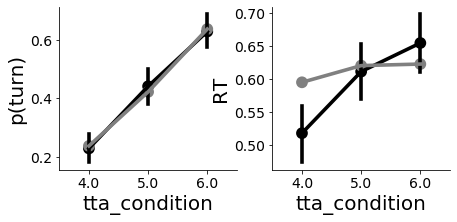

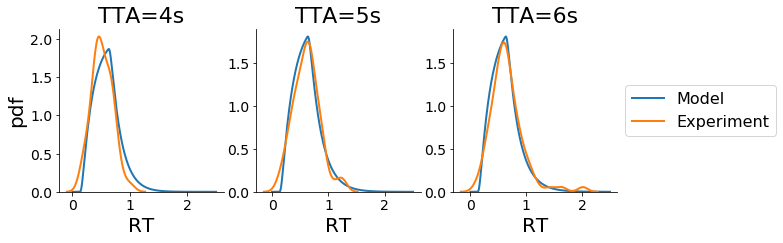

In [524]:
visualize_model_fit(exp_data, fit_model_var_drift)

### DDM with tta-dependent drift and collapsing bounds

In [526]:
model_collapsing_bounds = ddm.Model(name='Model with drift depending on TTA & collapsing bounds',
                 drift=DriftTta(alpha=ddm.Fittable(minval=0.1, maxval=5), 
                                tta_crit=ddm.Fittable(minval=2, maxval=6)),
                 noise=ddm.NoiseConstant(noise=1),
                 bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                     tau=ddm.Fittable(minval=0.5, maxval=5)),
                 overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                       halfwidth=ddm.Fittable(minval=0.0, maxval=0.25)),
                 T_dur=2.5)

In [528]:
%time fit_model_collapse = ddm.fit_adjust_model(sample=exp_sample, model=model_collapsing_bounds, lossfunction=LossWLS)

[2.8253178113361956, 3.3356889038957314, 1.8814976506611722, 2.3971856547779096, 0.18755224936225692, 0.09255561942007788]
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9823695536521986, minval=0.1, maxval=5), tta_crit=Fitted(2.4238925432317293, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.772067684028861, minval=0.5, maxval=5), tau=Fitted(1.5159713795614043, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4043590757812142, minval=0, maxval=0.5), halfwidth=Fitted(0.2376365002171538, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.3169263715998305
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.036059844880213, minval=0.1, maxval=5), tta_crit=Fitted(4.169765573249748, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.46

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(4.3821825678949065, minval=0.1, maxval=5), tta_crit=Fitted(5.432761478650395, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.55046827892923, minval=0.5, maxval=5), tau=Fitted(0.564219190694919, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4068241372180686, minval=0, maxval=0.5), halfwidth=Fitted(0.24937359251162824, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.786580918772123
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.47265336258066526, minval=0.1, maxval=5), tta_crit=Fitted(2.9844208164644583, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.454332761284104, minval=0.5, maxval=5), tau=Fitted(3.372674213184751, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.130158700939514, minval=0.1, maxval=5), tta_crit=Fitted(5.647236812436315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.2304379433609194, minval=0.5, maxval=5), tau=Fitted(1.2232073044051779, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1120977317945876, minval=0, maxval=0.5), halfwidth=Fitted(0.20998677020907422, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.107614651643286
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(4.964225323945965, minval=0.1, maxval=5), tta_crit=Fitted(4.323984126570384, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.042265070313458, minval=0.5, maxval=5), tau=Fitted(2.906755834318804, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(4.649054324789876, minval=0.1, maxval=5), tta_crit=Fitted(4.025129340922909, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.02517895290939, minval=0.5, maxval=5), tau=Fitted(1.8951056739710808, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.05261521362064353, minval=0, maxval=0.5), halfwidth=Fitted(0.06346513425023502, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.313778745483079
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.858827684677609, minval=0.1, maxval=5), tta_crit=Fitted(3.842874560702228, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.239501020433196, minval=0.5, maxval=5), tau=Fitted(1.9988780023121553, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.3067116876145937, minval=0.1, maxval=5), tta_crit=Fitted(2.283658599153478, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.537598354050139, minval=0.5, maxval=5), tau=Fitted(2.09401655238603, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.287262331064347, minval=0, maxval=0.5), halfwidth=Fitted(0.18271692385989446, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.360886238051471
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(4.676248139159462, minval=0.1, maxval=5), tta_crit=Fitted(2.252169112844319, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.82522101178121, minval=0.5, maxval=5), tau=Fitted(4.812398341584331, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=Ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.5751280670875345, minval=0.1, maxval=5), tta_crit=Fitted(2.8924986852614167, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.74769899512055, minval=0.5, maxval=5), tau=Fitted(3.4281703193449493, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3422897424266212, minval=0, maxval=0.5), halfwidth=Fitted(0.24292099795269928, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.021530339766219
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.6663628153227066, minval=0.1, maxval=5), tta_crit=Fitted(3.3631254074714154, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.9202378115475294, minval=0.5, maxval=5), tau=Fitted(3.7054702712603116, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.425454493983849, minval=0.1, maxval=5), tta_crit=Fitted(3.216642625856779, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.0767054408936048, minval=0.5, maxval=5), tau=Fitted(0.7964696822495092, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17971037081811603, minval=0, maxval=0.5), halfwidth=Fitted(0.23158076147220183, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.6271056368482397
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.917162437766966, minval=0.1, maxval=5), tta_crit=Fitted(3.120268780368139, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5116003486004805, minval=0.5, maxval=5), tau=Fitted(2.2932984760868274, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.28161935779127445, minval=0.1, maxval=5), tta_crit=Fitted(2.478202027003129, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4989078840190404, minval=0.5, maxval=5), tau=Fitted(1.1268051652331499, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.272951479520411, minval=0, maxval=0.5), halfwidth=Fitted(0.13296256896106728, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4805374427000548
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.618023010129367, minval=0.1, maxval=5), tta_crit=Fitted(2.8636110707940654, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.907574709702521, minval=0.5, maxval=5), tau=Fitted(1.2096472300820122, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.168156540040292, minval=0.1, maxval=5), tta_crit=Fitted(4.76156561012456, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8676980582153848, minval=0.5, maxval=5), tau=Fitted(2.0021120981591864, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3144737179836961, minval=0, maxval=0.5), halfwidth=Fitted(0.14095402324685116, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7902965179136514
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.8619040791003498, minval=0.1, maxval=5), tta_crit=Fitted(4.777140123401862, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9950460520576108, minval=0.5, maxval=5), tau=Fitted(1.4902004095462726, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.43859686867962866, minval=0.1, maxval=5), tta_crit=Fitted(5.090066004189765, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3342221735279742, minval=0.5, maxval=5), tau=Fitted(1.798605030134335, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13949703630769517, minval=0, maxval=0.5), halfwidth=Fitted(0.15700205170447212, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06619694250527759
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.711940486763684, minval=0.1, maxval=5), tta_crit=Fitted(5.328940224296271, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.3432115642879046, minval=0.5, maxval=5), tau=Fitted(3.3410635930951655, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.35756074224553513, minval=0.1, maxval=5), tta_crit=Fitted(2.6491602276512345, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4089904452370206, minval=0.5, maxval=5), tau=Fitted(2.5225939498393988, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08990129700822491, minval=0, maxval=0.5), halfwidth=Fitted(0.10800751181473275, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2093472241251817
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.22806867135698816, minval=0.1, maxval=5), tta_crit=Fitted(5.978651769095222, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5829316900767751, minval=0.5, maxval=5), tau=Fitted(2.374928623970006, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(4.401763554366022, minval=0.1, maxval=5), tta_crit=Fitted(4.946970129202475, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.360835100566123, minval=0.5, maxval=5), tau=Fitted(2.950731430153457, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25664035201359015, minval=0, maxval=0.5), halfwidth=Fitted(0.1544635007415976, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0933248856202158
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.796398365176418, minval=0.1, maxval=5), tta_crit=Fitted(4.370839623140118, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.1403375686843638, minval=0.5, maxval=5), tau=Fitted(4.200520253516486, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.3830564840151176, minval=0.1, maxval=5), tta_crit=Fitted(5.245596500383101, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9726872067556602, minval=0.5, maxval=5), tau=Fitted(1.879886920802293, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28568629491337205, minval=0, maxval=0.5), halfwidth=Fitted(0.1549264425959453, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.605588649444832
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.3272291102653107, minval=0.1, maxval=5), tta_crit=Fitted(4.5658239155171625, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9720588334964757, minval=0.5, maxval=5), tau=Fitted(0.9235804675094688, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.2905194482971569, minval=0.1, maxval=5), tta_crit=Fitted(4.944198361971763, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.059481352984751, minval=0.5, maxval=5), tau=Fitted(1.746053695790597, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10249547983470869, minval=0, maxval=0.5), halfwidth=Fitted(0.20592061244705973, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.305842790756392
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.387598834012328, minval=0.1, maxval=5), tta_crit=Fitted(5.380706122232893, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.281658314808928, minval=0.5, maxval=5), tau=Fitted(2.7792144499860454, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6182818455090517, minval=0.1, maxval=5), tta_crit=Fitted(4.682174157608808, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4683431803850504, minval=0.5, maxval=5), tau=Fitted(1.5614821431687633, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07473729598484982, minval=0, maxval=0.5), halfwidth=Fitted(0.1932723046934929, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08704522052474081
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.845221087541916, minval=0.1, maxval=5), tta_crit=Fitted(4.694368346621159, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0273044457413372, minval=0.5, maxval=5), tau=Fitted(2.16410827326918, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.7953970404759456, minval=0.1, maxval=5), tta_crit=Fitted(4.1743157498963175, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.459921553083151, minval=0.5, maxval=5), tau=Fitted(4.745702433217167, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3412171194432121, minval=0, maxval=0.5), halfwidth=Fitted(0.1333449894109653, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0912115094748847
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.3597047908235513, minval=0.1, maxval=5), tta_crit=Fitted(4.698893644346837, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.133129716013726, minval=0.5, maxval=5), tau=Fitted(4.5569037347157, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5645317894469037, minval=0.1, maxval=5), tta_crit=Fitted(5.459379825988744, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9126952472737901, minval=0.5, maxval=5), tau=Fitted(2.9706179476673045, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.298946545359128, minval=0, maxval=0.5), halfwidth=Fitted(0.22605749621938984, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09282374894438397
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.240505495457396, minval=0.1, maxval=5), tta_crit=Fitted(4.590661187466877, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.108819372923406, minval=0.5, maxval=5), tau=Fitted(3.578915429248725, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.5714307866952413, minval=0.1, maxval=5), tta_crit=Fitted(4.827529330923639, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7343964704766142, minval=0.5, maxval=5), tau=Fitted(2.815299751394089, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12618859546213862, minval=0, maxval=0.5), halfwidth=Fitted(0.005224899072221234, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4101771957207061
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.9127498528181812, minval=0.1, maxval=5), tta_crit=Fitted(5.689315594155337, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4797365695022786, minval=0.5, maxval=5), tau=Fitted(0.9983275576820219, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5908040514671098, minval=0.1, maxval=5), tta_crit=Fitted(5.61196279805641, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.043870896361581, minval=0.5, maxval=5), tau=Fitted(3.0146053487579607, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2909047571082054, minval=0, maxval=0.5), halfwidth=Fitted(0.2410234602561138, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.98156642489439
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0595019315307257, minval=0.1, maxval=5), tta_crit=Fitted(4.922020375110857, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2853745024587895, minval=0.5, maxval=5), tau=Fitted(1.9454829881983644, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.335332549218319, minval=0.1, maxval=5), tta_crit=Fitted(5.545427151787882, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.964619973417287, minval=0.5, maxval=5), tau=Fitted(1.443713329639601, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.06744962917494751, minval=0, maxval=0.5), halfwidth=Fitted(0.09694764636636717, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.063613130866027
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.755695884907229, minval=0.1, maxval=5), tta_crit=Fitted(4.565068605344461, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.345753451220755, minval=0.5, maxval=5), tau=Fitted(0.5640836073451583, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.502406891354944, minval=0.1, maxval=5), tta_crit=Fitted(5.034038301467829, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9499519353422374, minval=0.5, maxval=5), tau=Fitted(1.9595278048682943, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2673230807221359, minval=0, maxval=0.5), halfwidth=Fitted(0.22186452690983535, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5861724756014643
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9112464947199503, minval=0.1, maxval=5), tta_crit=Fitted(4.883353013495576, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.2512517760057498, minval=0.5, maxval=5), tau=Fitted(3.40670141634962, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.8761517345009073, minval=0.1, maxval=5), tta_crit=Fitted(4.4854798106282265, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5608080700447562, minval=0.5, maxval=5), tau=Fitted(0.5632787082532689, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10921971444055156, minval=0, maxval=0.5), halfwidth=Fitted(0.12780411472786976, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8872840131812747
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.4900777913682848, minval=0.1, maxval=5), tta_crit=Fitted(4.5700693483914225, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.150026583805997, minval=0.5, maxval=5), tau=Fitted(1.9698900992570243, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.164076673750505, minval=0.1, maxval=5), tta_crit=Fitted(4.868865268143362, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3215940379361886, minval=0.5, maxval=5), tau=Fitted(0.739354973119656, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47503332332142756, minval=0, maxval=0.5), halfwidth=Fitted(0.1934637490227795, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5435565002704277
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9021857919163712, minval=0.1, maxval=5), tta_crit=Fitted(5.264752652008315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5613874177616807, minval=0.5, maxval=5), tau=Fitted(2.833535721229391, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.146712213772576, minval=0.1, maxval=5), tta_crit=Fitted(5.43096346004338, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6452320346041436, minval=0.5, maxval=5), tau=Fitted(2.3648219807096225, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12648902450689237, minval=0, maxval=0.5), halfwidth=Fitted(0.21986374449095614, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9463532949778081
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6310769924702329, minval=0.1, maxval=5), tta_crit=Fitted(5.109674234433228, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0218730881028124, minval=0.5, maxval=5), tau=Fitted(2.565030182242601, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.197072616642131, minval=0.1, maxval=5), tta_crit=Fitted(5.136459605917203, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5062404700483656, minval=0.5, maxval=5), tau=Fitted(0.9246029788434496, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07536893844641962, minval=0, maxval=0.5), halfwidth=Fitted(0.11556703360895747, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9160655019616428
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.374246518732314, minval=0.1, maxval=5), tta_crit=Fitted(5.807612424425687, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.847483537986402, minval=0.5, maxval=5), tau=Fitted(2.18503674518402, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.1303229412875044, minval=0.1, maxval=5), tta_crit=Fitted(5.16670437400694, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4418014672892523, minval=0.5, maxval=5), tau=Fitted(0.8218617960517647, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38734658728638527, minval=0, maxval=0.5), halfwidth=Fitted(0.23801434692796924, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4627988403712688
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8769864657623017, minval=0.1, maxval=5), tta_crit=Fitted(5.14382127926838, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5089252468561294, minval=0.5, maxval=5), tau=Fitted(0.7297918205299698, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0833059085778967, minval=0.1, maxval=5), tta_crit=Fitted(5.090066004189765, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.916212373220702, minval=0.5, maxval=5), tau=Fitted(0.9029716922613076, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10429812320683429, minval=0, maxval=0.5), halfwidth=Fitted(0.2443891026528135, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.285839338931396
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.6082766625116693, minval=0.1, maxval=5), tta_crit=Fitted(5.433207395338375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8176267411452269, minval=0.5, maxval=5), tau=Fitted(3.38526787120533, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9026194684354836, minval=0.1, maxval=5), tta_crit=Fitted(5.043217758772631, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.47397391378302, minval=0.5, maxval=5), tau=Fitted(2.7498087697981464, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4868545222662796, minval=0, maxval=0.5), halfwidth=Fitted(0.14774155264696395, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.129469002188496
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.2609489934118505, minval=0.1, maxval=5), tta_crit=Fitted(4.100476689698292, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.710898499313422, minval=0.5, maxval=5), tau=Fitted(2.979720094503403, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9545350307113485, minval=0.1, maxval=5), tta_crit=Fitted(4.481206912956635, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.656994902798028, minval=0.5, maxval=5), tau=Fitted(0.852897362201334, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25279551187484467, minval=0, maxval=0.5), halfwidth=Fitted(0.1838062686534818, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9991166256877264
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.3651731607786401, minval=0.1, maxval=5), tta_crit=Fitted(5.407817592816572, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1137905641575232, minval=0.5, maxval=5), tau=Fitted(1.420721971902407, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.30512032251535537, minval=0.1, maxval=5), tta_crit=Fitted(4.5054463122878055, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.480440611170417, minval=0.5, maxval=5), tau=Fitted(2.56158815310973, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2644544298131344, minval=0, maxval=0.5), halfwidth=Fitted(0.23476789356226335, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8790955820703761
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(3.9673825552352806, minval=0.1, maxval=5), tta_crit=Fitted(5.226794498440566, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.41079563325447, minval=0.5, maxval=5), tau=Fitted(2.449685900327106, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.25135354254234343, minval=0.1, maxval=5), tta_crit=Fitted(5.317453495769797, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.4200733716338556, minval=0.5, maxval=5), tau=Fitted(1.0663475853891589, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17005528825634025, minval=0, maxval=0.5), halfwidth=Fitted(0.16660775390695584, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.274346882391279
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.5002787607897483, minval=0.1, maxval=5), tta_crit=Fitted(5.513459100408406, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.007916767494037, minval=0.5, maxval=5), tau=Fitted(4.489394877102872, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5727605907291728, minval=0.1, maxval=5), tta_crit=Fitted(5.369794422225194, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1514584177865546, minval=0.5, maxval=5), tau=Fitted(1.1469846622860471, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25061513094316124, minval=0, maxval=0.5), halfwidth=Fitted(0.15662896478407284, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1787068390200985
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.4676457638093061, minval=0.1, maxval=5), tta_crit=Fitted(5.567877158751035, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1421780808813775, minval=0.5, maxval=5), tau=Fitted(2.8628489074313204, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.852420773575034, minval=0.1, maxval=5), tta_crit=Fitted(4.917100990943737, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.076055136682619, minval=0.5, maxval=5), tau=Fitted(1.0070677267343153, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1138136318078403, minval=0, maxval=0.5), halfwidth=Fitted(0.1812997843227373, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7746406866021425
differential_evolution step 4: f(x)= 0.0282001
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7626274789241667, minval=0.1, maxval=5), tta_crit=Fitted(5.123106797229292, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9585645535007461, minval=0.5, maxval=5), tau=Fitted(2.1538680109124995, minval=

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.419048680310207, minval=0.1, maxval=5), tta_crit=Fitted(5.2089544778129495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.304689676137523, minval=0.5, maxval=5), tau=Fitted(2.24329452306977, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4005760667173427, minval=0, maxval=0.5), halfwidth=Fitted(0.20942046733955066, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2891008882780124
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.6128618701868047, minval=0.1, maxval=5), tta_crit=Fitted(5.206295570295868, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8528876155161675, minval=0.5, maxval=5), tau=Fitted(2.9437407949137717, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.2341117833215054, minval=0.1, maxval=5), tta_crit=Fitted(5.449158589489545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.517396207110337, minval=0.5, maxval=5), tau=Fitted(2.148892026713833, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.024915978277794626, minval=0, maxval=0.5), halfwidth=Fitted(0.07048208986296176, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28892353549356525
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.07855426729383, minval=0.1, maxval=5), tta_crit=Fitted(4.051078072245144, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6158445723264898, minval=0.5, maxval=5), tau=Fitted(1.7285666299249764, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6434840448488637, minval=0.1, maxval=5), tta_crit=Fitted(5.30927727566735, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.874860368066248, minval=0.5, maxval=5), tau=Fitted(4.4410995509888185, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08954498077514911, minval=0, maxval=0.5), halfwidth=Fitted(0.1449773146117549, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15427756526318595
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0916220751037986, minval=0.1, maxval=5), tta_crit=Fitted(5.253728732086719, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8655145552788261, minval=0.5, maxval=5), tau=Fitted(3.421639136045637, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.24607882976186746, minval=0.1, maxval=5), tta_crit=Fitted(4.865107030095311, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.0711093985984235, minval=0.5, maxval=5), tau=Fitted(1.0559611359721384, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1835575549524066, minval=0, maxval=0.5), halfwidth=Fitted(0.18792236898640474, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3543797721652728
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0535488428454796, minval=0.1, maxval=5), tta_crit=Fitted(5.764436577951376, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.496416936744107, minval=0.5, maxval=5), tau=Fitted(2.0648355568269134, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.339097622096053, minval=0.1, maxval=5), tta_crit=Fitted(4.90436192637692, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.6311408491755053, minval=0.5, maxval=5), tau=Fitted(1.245587224065217, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26167612683031516, minval=0, maxval=0.5), halfwidth=Fitted(0.2329446568067379, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6497108549139713
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5229183069743519, minval=0.1, maxval=5), tta_crit=Fitted(5.512093240766176, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.073265822028768, minval=0.5, maxval=5), tau=Fitted(3.1631684940352627, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9395410183978992, minval=0.1, maxval=5), tta_crit=Fitted(5.42282622477877, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.341944831949851, minval=0.5, maxval=5), tau=Fitted(4.418887109730054, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.025327865633940794, minval=0, maxval=0.5), halfwidth=Fitted(0.19676977272239116, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2558627164628733
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.462610627302126, minval=0.1, maxval=5), tta_crit=Fitted(5.184744784861067, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2026388326049275, minval=0.5, maxval=5), tau=Fitted(2.3660506516532385, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8511967305886632, minval=0.1, maxval=5), tta_crit=Fitted(5.017649331655442, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6962029577954847, minval=0.5, maxval=5), tau=Fitted(0.5133923402244984, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12988400985176232, minval=0, maxval=0.5), halfwidth=Fitted(0.09144990307410028, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22164760114901322
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.1286818556220628, minval=0.1, maxval=5), tta_crit=Fitted(5.379005134213347, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9378432096425025, minval=0.5, maxval=5), tau=Fitted(1.7983063203741387, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6587211145528944, minval=0.1, maxval=5), tta_crit=Fitted(5.033879252590513, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.6562297212792068, minval=0.5, maxval=5), tau=Fitted(3.0393850382981706, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37514313875370864, minval=0, maxval=0.5), halfwidth=Fitted(0.06526791073675722, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7446359523594446
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.2814691460047338, minval=0.1, maxval=5), tta_crit=Fitted(5.0193188438012974, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9654476257905258, minval=0.5, maxval=5), tau=Fitted(0.5821352378506721, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7621172383277426, minval=0.1, maxval=5), tta_crit=Fitted(4.4793899801253865, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6922419184272868, minval=0.5, maxval=5), tau=Fitted(1.1135637435101302, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41437232721932155, minval=0, maxval=0.5), halfwidth=Fitted(0.1710227760689777, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2886463331835623
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5642323705160188, minval=0.1, maxval=5), tta_crit=Fitted(4.736383468219305, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5676681052304491, minval=0.5, maxval=5), tau=Fitted(3.2382461212787566, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.3120145122902729, minval=0.1, maxval=5), tta_crit=Fitted(5.692241545861667, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8045283883039218, minval=0.5, maxval=5), tau=Fitted(2.5649801466683484, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3921882082572187, minval=0, maxval=0.5), halfwidth=Fitted(0.1989362000103871, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.29382093169791024
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7898398471959243, minval=0.1, maxval=5), tta_crit=Fitted(5.15148769437617, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.132139408767939, minval=0.5, maxval=5), tau=Fitted(1.6208554458424023, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.3702646877424955, minval=0.1, maxval=5), tta_crit=Fitted(4.428439375526279, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.142911120560182, minval=0.5, maxval=5), tau=Fitted(4.899596462138023, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22867408208330628, minval=0, maxval=0.5), halfwidth=Fitted(0.18796960972877802, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5322874672886959
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0122136263939365, minval=0.1, maxval=5), tta_crit=Fitted(4.911879220458514, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.406980906707017, minval=0.5, maxval=5), tau=Fitted(1.7637674518505508, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.10854930530183804, minval=0.1, maxval=5), tta_crit=Fitted(5.771160354462486, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.172082339197196, minval=0.5, maxval=5), tau=Fitted(3.407356290214439, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07911561695719466, minval=0, maxval=0.5), halfwidth=Fitted(0.17401875375190776, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28258538921398324
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.436789994725107, minval=0.1, maxval=5), tta_crit=Fitted(4.961146570592478, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8007534569486687, minval=0.5, maxval=5), tau=Fitted(1.7854809283254742, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.414734246885466, minval=0.1, maxval=5), tta_crit=Fitted(5.285728268418942, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5095098924006702, minval=0.5, maxval=5), tau=Fitted(0.6286205228327377, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34335158105616304, minval=0, maxval=0.5), halfwidth=Fitted(0.2443795545463675, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.142072471570532
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.9342692934679577, minval=0.1, maxval=5), tta_crit=Fitted(4.150750079412598, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.0533577959466864, minval=0.5, maxval=5), tau=Fitted(2.033881476318269, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9544823478863136, minval=0.1, maxval=5), tta_crit=Fitted(5.580352022610521, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4683431803850504, minval=0.5, maxval=5), tau=Fitted(3.667202393729087, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.490707730302394, minval=0, maxval=0.5), halfwidth=Fitted(0.1932723046934929, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5630911032026538
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0517773742052916, minval=0.1, maxval=5), tta_crit=Fitted(5.382196213093129, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.713077952795524, minval=0.5, maxval=5), tau=Fitted(4.271047582228338, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.0000213793799615, minval=0.1, maxval=5), tta_crit=Fitted(5.886967320698022, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5372125108058974, minval=0.5, maxval=5), tau=Fitted(3.2433168225463165, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3551575613098098, minval=0, maxval=0.5), halfwidth=Fitted(0.22555082253567185, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5547595278773876
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0712194811312454, minval=0.1, maxval=5), tta_crit=Fitted(4.698893644346837, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.0796946571075106, minval=0.5, maxval=5), tau=Fitted(1.4259021132560994, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.1558878663665038, minval=0.1, maxval=5), tta_crit=Fitted(5.199724498885759, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4872803178631258, minval=0.5, maxval=5), tau=Fitted(3.9985744104478194, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08139338702354149, minval=0, maxval=0.5), halfwidth=Fitted(0.1519948363349471, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4563480402009576
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.1207309617919301, minval=0.1, maxval=5), tta_crit=Fitted(5.170354118122342, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8251512556632314, minval=0.5, maxval=5), tau=Fitted(2.565692089313373, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.5714307866952413, minval=0.1, maxval=5), tta_crit=Fitted(4.797400040619426, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6962778539505479, minval=0.5, maxval=5), tau=Fitted(0.6780095479543897, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36555269981253186, minval=0, maxval=0.5), halfwidth=Fitted(0.23066608145624587, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28063077162202443
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7337775221881746, minval=0.1, maxval=5), tta_crit=Fitted(5.376763938814805, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.131596108882558, minval=0.5, maxval=5), tau=Fitted(1.2702493248302904, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7173316747981531, minval=0.1, maxval=5), tta_crit=Fitted(5.687026473194781, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.905949152968642, minval=0.5, maxval=5), tau=Fitted(1.1493012285466815, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2909047571082054, minval=0, maxval=0.5), halfwidth=Fitted(0.15838014780434131, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.431495445034214
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.35046367465469075, minval=0.1, maxval=5), tta_crit=Fitted(5.8632240126800905, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2853745024587895, minval=0.5, maxval=5), tau=Fitted(0.7780131620519792, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5889684678411162, minval=0.1, maxval=5), tta_crit=Fitted(5.490705780886902, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.633861974531896, minval=0.5, maxval=5), tau=Fitted(3.058035451433139, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11800879416243279, minval=0, maxval=0.5), halfwidth=Fitted(0.11713193357797899, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.433648069110826
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7657262231268422, minval=0.1, maxval=5), tta_crit=Fitted(5.11327043226574, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9772917417243616, minval=0.5, maxval=5), tau=Fitted(0.927258686163225, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.806088842337134, minval=0.1, maxval=5), tta_crit=Fitted(5.677051520520275, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.790172724300325, minval=0.5, maxval=5), tau=Fitted(1.9466371131343787, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2910621050580976, minval=0, maxval=0.5), halfwidth=Fitted(0.0668140845758004, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.718837757628055
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0762817005786207, minval=0.1, maxval=5), tta_crit=Fitted(5.474887956902151, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.8842991387162815, minval=0.5, maxval=5), tau=Fitted(3.40670141634962, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.3813507215516494, minval=0.1, maxval=5), tta_crit=Fitted(5.119320534417631, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7083852475539358, minval=0.5, maxval=5), tau=Fitted(2.172506904861185, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38185305619907245, minval=0, maxval=0.5), halfwidth=Fitted(0.20910997184594013, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16424292777094324
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.4900777913682848, minval=0.1, maxval=5), tta_crit=Fitted(5.281685728114578, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7361502753816442, minval=0.5, maxval=5), tau=Fitted(3.977900047054585, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9748407071396994, minval=0.1, maxval=5), tta_crit=Fitted(5.0009769385291545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.7826611269097983, minval=0.5, maxval=5), tau=Fitted(2.3557295798322615, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44974911974991333, minval=0, maxval=0.5), halfwidth=Fitted(0.14662587524314036, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.5860858192326175
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7073148892624899, minval=0.1, maxval=5), tta_crit=Fitted(5.386172644217361, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0769875108745053, minval=0.5, maxval=5), tau=Fitted(1.8937036458370844, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.3871188207176357, minval=0.1, maxval=5), tta_crit=Fitted(4.978567925743375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.383121801028644, minval=0.5, maxval=5), tau=Fitted(2.953749426838406, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2320875324817444, minval=0, maxval=0.5), halfwidth=Fitted(0.21549680879062688, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1944110096567125
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5938118379850319, minval=0.1, maxval=5), tta_crit=Fitted(5.354876415240168, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.434496606097554, minval=0.5, maxval=5), tau=Fitted(2.3724014826511715, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.0656828101278044, minval=0.1, maxval=5), tta_crit=Fitted(5.136459605917203, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9134807037360324, minval=0.5, maxval=5), tau=Fitted(4.518321212535824, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2819406857796681, minval=0, maxval=0.5), halfwidth=Fitted(0.19497428225611918, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07568924744456568
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7011472785550532, minval=0.1, maxval=5), tta_crit=Fitted(5.387121973677516, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5603663997224475, minval=0.5, maxval=5), tau=Fitted(3.2040824831098167, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.27017790641168293, minval=0.1, maxval=5), tta_crit=Fitted(5.082953526277892, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3584722871729915, minval=0.5, maxval=5), tau=Fitted(4.901326256705622, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29435046490402134, minval=0, maxval=0.5), halfwidth=Fitted(0.16694337133375445, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.260801669139434
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.4081484186085673, minval=0.1, maxval=5), tta_crit=Fitted(5.0504940167552235, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7138410177221046, minval=0.5, maxval=5), tau=Fitted(2.403444568059597, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8230915094303082, minval=0.1, maxval=5), tta_crit=Fitted(5.184850419629308, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.033320488045213, minval=0.5, maxval=5), tau=Fitted(2.4713306623967175, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10942400994917198, minval=0, maxval=0.5), halfwidth=Fitted(0.2108399867198632, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07109501355285222
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.43859686867962866, minval=0.1, maxval=5), tta_crit=Fitted(5.428331251564914, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.040825992837211, minval=0.5, maxval=5), tau=Fitted(4.343844149136867, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5883816165400355, minval=0.1, maxval=5), tta_crit=Fitted(3.878384385186239, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.6113785140561996, minval=0.5, maxval=5), tau=Fitted(2.159185153066767, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24956149586275178, minval=0, maxval=0.5), halfwidth=Fitted(0.24555012581273672, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3850354785679277
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(2.456702280082898, minval=0.1, maxval=5), tta_crit=Fitted(5.366799749288852, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7634840013769506, minval=0.5, maxval=5), tau=Fitted(2.7930518811302982, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.5199010144195193, minval=0.1, maxval=5), tta_crit=Fitted(5.608764175359044, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2450675699758027, minval=0.5, maxval=5), tau=Fitted(1.8411178206090062, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.46910703760088346, minval=0, maxval=0.5), halfwidth=Fitted(0.1986216496649923, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1028487166282313
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7525321694411018, minval=0.1, maxval=5), tta_crit=Fitted(5.06786712624182, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.6868686799758037, minval=0.5, maxval=5), tau=Fitted(1.55835506389996, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.2429461019365542, minval=0.1, maxval=5), tta_crit=Fitted(5.971278800607008, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.3777866928835394, minval=0.5, maxval=5), tau=Fitted(0.9394086350521875, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2300414338459093, minval=0, maxval=0.5), halfwidth=Fitted(0.1866099124542562, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.425142913408219
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.30512032251535537, minval=0.1, maxval=5), tta_crit=Fitted(4.997958338727155, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8703328262285783, minval=0.5, maxval=5), tau=Fitted(2.2219276509132415, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.2838558026229485, minval=0.1, maxval=5), tta_crit=Fitted(5.447612906318143, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.14139271656659, minval=0.5, maxval=5), tau=Fitted(2.6790451528427663, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09390087119018273, minval=0, maxval=0.5), halfwidth=Fitted(0.09175045617429964, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4012271116155409
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6186543320920044, minval=0.1, maxval=5), tta_crit=Fitted(5.001440953473584, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1956778094527951, minval=0.5, maxval=5), tau=Fitted(0.7993104191063065, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8843953610426767, minval=0.1, maxval=5), tta_crit=Fitted(2.5222164992496356, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6260939253387918, minval=0.5, maxval=5), tau=Fitted(1.4227679352341462, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28364489446820956, minval=0, maxval=0.5), halfwidth=Fitted(0.15062758241876384, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.478568878013887
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.3627984342789521, minval=0.1, maxval=5), tta_crit=Fitted(4.972068448723275, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6672526122917763, minval=0.5, maxval=5), tau=Fitted(0.5936293151066394, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.523499294159599, minval=0.1, maxval=5), tta_crit=Fitted(5.543396946140655, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.643025275072905, minval=0.5, maxval=5), tau=Fitted(4.314805906646904, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24655031760380797, minval=0, maxval=0.5), halfwidth=Fitted(0.16066664397123528, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7925122569058889
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6420777892434113, minval=0.1, maxval=5), tta_crit=Fitted(5.357002261071105, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3119723754221406, minval=0.5, maxval=5), tau=Fitted(3.3031741173908893, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8642290023460051, minval=0.1, maxval=5), tta_crit=Fitted(5.478307014550803, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.3162564008294604, minval=0.5, maxval=5), tau=Fitted(2.995557410439664, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4605884214113604, minval=0, maxval=0.5), halfwidth=Fitted(0.1705576096241717, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1498022840667104
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.92228030335725, minval=0.1, maxval=5), tta_crit=Fitted(5.4952933150794685, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4701762553562905, minval=0.5, maxval=5), tau=Fitted(2.5342058347928105, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8386063338277017, minval=0.1, maxval=5), tta_crit=Fitted(4.958771200515764, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5074188920096208, minval=0.5, maxval=5), tau=Fitted(0.9643985401920216, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35868698325260456, minval=0, maxval=0.5), halfwidth=Fitted(0.2486014009037038, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08268444963557262
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7354767516208629, minval=0.1, maxval=5), tta_crit=Fitted(4.4579622541854524, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1318378162037643, minval=0.5, maxval=5), tau=Fitted(0.5996258216711396, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7767351917041896, minval=0.1, maxval=5), tta_crit=Fitted(5.444183805177211, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0122327171912118, minval=0.5, maxval=5), tau=Fitted(2.2518862819552887, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25695977759635935, minval=0, maxval=0.5), halfwidth=Fitted(0.21384569174368057, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07278166049642523
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7458607439999447, minval=0.1, maxval=5), tta_crit=Fitted(5.144211814245612, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3284239514435248, minval=0.5, maxval=5), tau=Fitted(2.465171684238132, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9473532208553475, minval=0.1, maxval=5), tta_crit=Fitted(5.40490925576354, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8541672392789923, minval=0.5, maxval=5), tau=Fitted(1.5516933320512312, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31425041302250695, minval=0, maxval=0.5), halfwidth=Fitted(0.22325612907137907, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08794648220271428
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6411178714292236, minval=0.1, maxval=5), tta_crit=Fitted(5.151532773494776, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0181546262838632, minval=0.5, maxval=5), tau=Fitted(0.7886601511715043, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7802346188285287, minval=0.1, maxval=5), tta_crit=Fitted(5.030967903904549, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.7766963963074494, minval=0.5, maxval=5), tau=Fitted(2.8007958082798092, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3521209615634916, minval=0, maxval=0.5), halfwidth=Fitted(0.22043360751972632, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7124610775829191
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.072647179319514, minval=0.1, maxval=5), tta_crit=Fitted(5.069543391726771, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2484429125807417, minval=0.5, maxval=5), tau=Fitted(2.4147634290338127, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9663649889991717, minval=0.1, maxval=5), tta_crit=Fitted(4.386606677765527, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.4177939082802906, minval=0.5, maxval=5), tau=Fitted(0.8845963146606994, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17930222941209978, minval=0, maxval=0.5), halfwidth=Fitted(0.23831513386586423, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.6347873625047358
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9158269373570205, minval=0.1, maxval=5), tta_crit=Fitted(5.4640069272124325, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.0982853291325663, minval=0.5, maxval=5), tau=Fitted(1.02147197434608, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.2580099434742367, minval=0.1, maxval=5), tta_crit=Fitted(4.87291409988995, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8052548466863145, minval=0.5, maxval=5), tau=Fitted(1.279840666829781, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3361813120118058, minval=0, maxval=0.5), halfwidth=Fitted(0.06705835292085013, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1891068261719446
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8600155135734491, minval=0.1, maxval=5), tta_crit=Fitted(5.126852267702968, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8545349911545466, minval=0.5, maxval=5), tau=Fitted(4.542277551737834, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9442168215765347, minval=0.1, maxval=5), tta_crit=Fitted(5.3525982134726515, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2183327719104518, minval=0.5, maxval=5), tau=Fitted(1.709111133528022, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32887439857289563, minval=0, maxval=0.5), halfwidth=Fitted(0.206467192617254, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.278910460977076
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7230661748653626, minval=0.1, maxval=5), tta_crit=Fitted(5.222978278190855, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.635321105027503, minval=0.5, maxval=5), tau=Fitted(2.6092680191560693, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7134026904782116, minval=0.1, maxval=5), tta_crit=Fitted(5.407817592816572, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2548575690163584, minval=0.5, maxval=5), tau=Fitted(1.4567734339155993, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24833254176737174, minval=0, maxval=0.5), halfwidth=Fitted(0.1903230521909968, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1832337298615383
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.3951535099353358, minval=0.1, maxval=5), tta_crit=Fitted(5.496908821961776, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3005957932101504, minval=0.5, maxval=5), tau=Fitted(2.0162528302299854, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5889499920089634, minval=0.1, maxval=5), tta_crit=Fitted(5.215200096907136, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.4036187405456917, minval=0.5, maxval=5), tau=Fitted(1.2871513918118302, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1452382288844559, minval=0, maxval=0.5), halfwidth=Fitted(0.04072031677573945, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0663600108538147
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.1518871435388613, minval=0.1, maxval=5), tta_crit=Fitted(5.2473081109465145, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.797486844543755, minval=0.5, maxval=5), tau=Fitted(4.0308849807296605, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8870393767955065, minval=0.1, maxval=5), tta_crit=Fitted(4.968378452088906, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.243339479206626, minval=0.5, maxval=5), tau=Fitted(1.1577424182783396, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37463298388918115, minval=0, maxval=0.5), halfwidth=Fitted(0.0017986207111803931, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.77894745196785
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7405519966996754, minval=0.1, maxval=5), tta_crit=Fitted(5.400140645094664, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6036619668050447, minval=0.5, maxval=5), tau=Fitted(1.0001180490688024, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(1.1896115203526196, minval=0.1, maxval=5), tta_crit=Fitted(4.571755312416048, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1820654735581488, minval=0.5, maxval=5), tau=Fitted(2.863856975704032, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40956084560332023, minval=0, maxval=0.5), halfwidth=Fitted(0.038916205599893644, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4709348870643519
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6687318660615369, minval=0.1, maxval=5), tta_crit=Fitted(5.524903578574838, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0428640094364305, minval=0.5, maxval=5), tau=Fitted(3.6388486076036637, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5432465191269058, minval=0.1, maxval=5), tta_crit=Fitted(5.221356007183203, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.690346884993077, minval=0.5, maxval=5), tau=Fitted(1.2010429087499643, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23291581089212587, minval=0, maxval=0.5), halfwidth=Fitted(0.22246987175815464, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13542817686258252
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9484920843223048, minval=0.1, maxval=5), tta_crit=Fitted(5.291959598691063, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8642039582124292, minval=0.5, maxval=5), tau=Fitted(0.964629786856884, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6481578679762712, minval=0.1, maxval=5), tta_crit=Fitted(5.365702747459318, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2805321603901303, minval=0.5, maxval=5), tau=Fitted(1.2047099808498567, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.253371477108976, minval=0, maxval=0.5), halfwidth=Fitted(0.22602637098379738, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2783008969005166
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8108274238583835, minval=0.1, maxval=5), tta_crit=Fitted(5.510038089479021, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7407311420707563, minval=0.5, maxval=5), tau=Fitted(1.2686513518262152, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.4864207340428095, minval=0.1, maxval=5), tta_crit=Fitted(4.651587732514558, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.108097631193046, minval=0.5, maxval=5), tau=Fitted(2.7480624245985523, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20902266334130343, minval=0, maxval=0.5), halfwidth=Fitted(0.225061126009448, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15153742876862075
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.45500228734842896, minval=0.1, maxval=5), tta_crit=Fitted(5.488513193053605, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5838724861000992, minval=0.5, maxval=5), tau=Fitted(2.489969806054575, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7480584472447569, minval=0.1, maxval=5), tta_crit=Fitted(5.267157864204915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.587771203296092, minval=0.5, maxval=5), tau=Fitted(1.0179190065144874, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30693423340205783, minval=0, maxval=0.5), halfwidth=Fitted(0.202756378494945, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06573631752919948
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.49436165035485, minval=0.1, maxval=5), tta_crit=Fitted(5.571113713308915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.5865667308951608, minval=0.5, maxval=5), tau=Fitted(4.043850409958912, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6551261661276142, minval=0.1, maxval=5), tta_crit=Fitted(5.297868495172829, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8593020004426457, minval=0.5, maxval=5), tau=Fitted(1.419218413334264, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26479611959431276, minval=0, maxval=0.5), halfwidth=Fitted(0.2273662560785324, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03454041379381475
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.4441090773511531, minval=0.1, maxval=5), tta_crit=Fitted(4.883043853505548, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1898619488598894, minval=0.5, maxval=5), tau=Fitted(1.124710309433673, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5291163806502404, minval=0.1, maxval=5), tta_crit=Fitted(5.157373679114001, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8983285106298367, minval=0.5, maxval=5), tau=Fitted(1.43342390779449, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25201811948440817, minval=0, maxval=0.5), halfwidth=Fitted(0.19244512332960023, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04878357965374083
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6863515557214384, minval=0.1, maxval=5), tta_crit=Fitted(5.2434451813528575, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9748267603069989, minval=0.5, maxval=5), tau=Fitted(1.7320117006736266, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6018464254673679, minval=0.1, maxval=5), tta_crit=Fitted(4.940003455092437, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5033928736619269, minval=0.5, maxval=5), tau=Fitted(2.5063927303883515, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23814567095754527, minval=0, maxval=0.5), halfwidth=Fitted(0.19559779412647824, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06311424398893573
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7583283905752485, minval=0.1, maxval=5), tta_crit=Fitted(5.152274921327047, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.4115741416288365, minval=0.5, maxval=5), tau=Fitted(1.2500814155688724, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6324966619997285, minval=0.1, maxval=5), tta_crit=Fitted(5.1071901026818125, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.369641834512849, minval=0.5, maxval=5), tau=Fitted(1.282245111727628, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.170829058739961, minval=0, maxval=0.5), halfwidth=Fitted(0.15333634564495674, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09086643092349837
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.666199357158374, minval=0.1, maxval=5), tta_crit=Fitted(5.103346775856378, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.813016627374582, minval=0.5, maxval=5), tau=Fitted(1.9460323366217773, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6029620562491311, minval=0.1, maxval=5), tta_crit=Fitted(5.2350721455480915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1724024193423124, minval=0.5, maxval=5), tau=Fitted(1.9693534149852108, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18256964839988485, minval=0, maxval=0.5), halfwidth=Fitted(0.19996098410399962, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05012727744535121
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7295473309429954, minval=0.1, maxval=5), tta_crit=Fitted(5.144305042857942, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8122085745369909, minval=0.5, maxval=5), tau=Fitted(1.1449069524928364, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9132017600261451, minval=0.1, maxval=5), tta_crit=Fitted(4.887889718981249, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.5604402164221063, minval=0.5, maxval=5), tau=Fitted(3.739857080701637, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25595997641532514, minval=0, maxval=0.5), halfwidth=Fitted(0.22681143270761456, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11488462796394838
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.685308970505141, minval=0.1, maxval=5), tta_crit=Fitted(5.282276806113028, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9315980851771224, minval=0.5, maxval=5), tau=Fitted(1.2554484283858856, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8252123169090833, minval=0.1, maxval=5), tta_crit=Fitted(5.297896795091397, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0142355409350448, minval=0.5, maxval=5), tau=Fitted(0.7288537428931883, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34544779674737597, minval=0, maxval=0.5), halfwidth=Fitted(0.22891537592939046, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4428625191211199
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7619435788074147, minval=0.1, maxval=5), tta_crit=Fitted(5.0566106504123205, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1000093576849599, minval=0.5, maxval=5), tau=Fitted(0.9414065264369529, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7311874249457024, minval=0.1, maxval=5), tta_crit=Fitted(4.94150007960173, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7617844908413185, minval=0.5, maxval=5), tau=Fitted(1.297513438442383, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3029626729217336, minval=0, maxval=0.5), halfwidth=Fitted(0.18855615772554082, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04824615376458394
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.715990198817928, minval=0.1, maxval=5), tta_crit=Fitted(4.957795020346361, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8378622463980667, minval=0.5, maxval=5), tau=Fitted(1.2209508492422814, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6120841331000584, minval=0.1, maxval=5), tta_crit=Fitted(5.07505889335831, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.791461664498338, minval=0.5, maxval=5), tau=Fitted(1.196795758866654, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11650001407071395, minval=0, maxval=0.5), halfwidth=Fitted(0.1973118614795531, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3101396704722647
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8427255252485109, minval=0.1, maxval=5), tta_crit=Fitted(5.022254538545855, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.6862603178354907, minval=0.5, maxval=5), tau=Fitted(1.1910302132213912, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7707572960936802, minval=0.1, maxval=5), tta_crit=Fitted(5.1115814272008615, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.2696489976890115, minval=0.5, maxval=5), tau=Fitted(4.903270804417711, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34335158105616304, minval=0, maxval=0.5), halfwidth=Fitted(0.23930621000947458, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08680136705767248
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.4472185052259352, minval=0.1, maxval=5), tta_crit=Fitted(5.093571764125294, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.577345280743879, minval=0.5, maxval=5), tau=Fitted(2.5552371575104282, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9144109695695977, minval=0.1, maxval=5), tta_crit=Fitted(4.993838028975164, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4683431803850504, minval=0.5, maxval=5), tau=Fitted(2.00374093221137, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2026638137341851, minval=0, maxval=0.5), halfwidth=Fitted(0.21568493085730156, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06739488350794025
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6068960311465286, minval=0.1, maxval=5), tta_crit=Fitted(5.18057802057093, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.029743442405208, minval=0.5, maxval=5), tau=Fitted(1.2143198987187538, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.4634736966884727, minval=0.1, maxval=5), tta_crit=Fitted(5.147669135353267, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8454778629401232, minval=0.5, maxval=5), tau=Fitted(0.9962697363993196, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.249649007226319, minval=0, maxval=0.5), halfwidth=Fitted(0.20326978474152915, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05451982450959544
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5032781969940041, minval=0.1, maxval=5), tta_crit=Fitted(5.25887952755421, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3790588557425263, minval=0.5, maxval=5), tau=Fitted(4.4323880429555045, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7147056667345688, minval=0.1, maxval=5), tta_crit=Fitted(4.987491546875457, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0687335740881467, minval=0.5, maxval=5), tau=Fitted(4.079027218347939, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1910190544870783, minval=0, maxval=0.5), halfwidth=Fitted(0.1935141307587658, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3056143690727108
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7005428558015538, minval=0.1, maxval=5), tta_crit=Fitted(5.224816645303827, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.5502286968073498, minval=0.5, maxval=5), tau=Fitted(2.9418292986924937, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.44727429589885137, minval=0.1, maxval=5), tta_crit=Fitted(5.114000671398541, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8234503748233761, minval=0.5, maxval=5), tau=Fitted(0.8986055071764321, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24699747658541438, minval=0, maxval=0.5), halfwidth=Fitted(0.09307317317739439, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06908177642323976
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7238535031310263, minval=0.1, maxval=5), tta_crit=Fitted(5.165186029948909, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7785974182395501, minval=0.5, maxval=5), tau=Fitted(1.0114631114865587, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5411914091048127, minval=0.1, maxval=5), tta_crit=Fitted(5.319772418730379, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3207984194093232, minval=0.5, maxval=5), tau=Fitted(2.539946974788295, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3651813351664425, minval=0, maxval=0.5), halfwidth=Fitted(0.21773041269297191, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19521341742162604
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8229254849842911, minval=0.1, maxval=5), tta_crit=Fitted(4.974152056007935, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2853745024587895, minval=0.5, maxval=5), tau=Fitted(1.803369933104924, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8578931339934559, minval=0.1, maxval=5), tta_crit=Fitted(5.220588162590694, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.5961489743532322, minval=0.5, maxval=5), tau=Fitted(3.4507377481178887, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2241123290180403, minval=0, maxval=0.5), halfwidth=Fitted(0.22823445380720972, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05091339818044151
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5008583412794434, minval=0.1, maxval=5), tta_crit=Fitted(5.207030495155633, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1395264478935911, minval=0.5, maxval=5), tau=Fitted(1.5079481361747045, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7259224185584792, minval=0.1, maxval=5), tta_crit=Fitted(4.477022690231603, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3272374781679823, minval=0.5, maxval=5), tau=Fitted(3.1913730523840447, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20755957186050183, minval=0, maxval=0.5), halfwidth=Fitted(0.2328662762225442, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27932574606221133
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.62445162829457, minval=0.1, maxval=5), tta_crit=Fitted(5.261226549334653, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.52650596215037, minval=0.5, maxval=5), tau=Fitted(0.8049895702515388, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6711578272187422, minval=0.1, maxval=5), tta_crit=Fitted(5.054153187238091, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0302041937368036, minval=0.5, maxval=5), tau=Fitted(3.9141655009573495, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25815832921352994, minval=0, maxval=0.5), halfwidth=Fitted(0.1522414692796775, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16439703966801128
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7206947466235814, minval=0.1, maxval=5), tta_crit=Fitted(5.368834302135246, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7285893526622194, minval=0.5, maxval=5), tau=Fitted(0.8374787813031461, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6801095581898657, minval=0.1, maxval=5), tta_crit=Fitted(5.05387551661418, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5267675382867929, minval=0.5, maxval=5), tau=Fitted(1.520413101498485, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3913535975889054, minval=0, maxval=0.5), halfwidth=Fitted(0.21810697385463093, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09094792092007739
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.601556685411843, minval=0.1, maxval=5), tta_crit=Fitted(5.065425998749651, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7567220581260545, minval=0.5, maxval=5), tau=Fitted(0.7948149621754441, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5208266854998973, minval=0.1, maxval=5), tta_crit=Fitted(5.156556259358101, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8056815130370789, minval=0.5, maxval=5), tau=Fitted(1.0347155052495005, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24096381309893325, minval=0, maxval=0.5), halfwidth=Fitted(0.18653227327897454, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.049327376173004964
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6815217756699441, minval=0.1, maxval=5), tta_crit=Fitted(5.109674234433228, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9087415009472628, minval=0.5, maxval=5), tau=Fitted(2.22978479286799, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8392855767407295, minval=0.1, maxval=5), tta_crit=Fitted(5.157844333076925, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.057407965486167, minval=0.5, maxval=5), tau=Fitted(1.563500746935075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.374184828204127, minval=0, maxval=0.5), halfwidth=Fitted(0.11290849587620402, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25672771755460544
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7840632529100706, minval=0.1, maxval=5), tta_crit=Fitted(5.138333197623705, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6685914831931234, minval=0.5, maxval=5), tau=Fitted(1.1664406713414996, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8701203326963152, minval=0.1, maxval=5), tta_crit=Fitted(5.070252789779944, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7858171976094124, minval=0.5, maxval=5), tau=Fitted(1.010420226605151, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3120463827896085, minval=0, maxval=0.5), halfwidth=Fitted(0.035954653255693025, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06369513626140347
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8252439952998598, minval=0.1, maxval=5), tta_crit=Fitted(5.366637735397534, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2494216402461185, minval=0.5, maxval=5), tau=Fitted(2.659784012118501, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5869850494750424, minval=0.1, maxval=5), tta_crit=Fitted(5.064602810237355, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.786593319961865, minval=0.5, maxval=5), tau=Fitted(2.47487678366295, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28087869514569713, minval=0, maxval=0.5), halfwidth=Fitted(0.21092887843545383, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.614153163737328
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8823952752261959, minval=0.1, maxval=5), tta_crit=Fitted(5.233717823575523, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6690920660284752, minval=0.5, maxval=5), tau=Fitted(1.403709629417397, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.748862164227726, minval=0.1, maxval=5), tta_crit=Fitted(5.041907764615227, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9108602927405123, minval=0.5, maxval=5), tau=Fitted(2.563718271415136, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25539632924647204, minval=0, maxval=0.5), halfwidth=Fitted(0.11201827807905043, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11166543710768909
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7416736277426961, minval=0.1, maxval=5), tta_crit=Fitted(4.752177412401238, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8926272126248715, minval=0.5, maxval=5), tau=Fitted(0.6171813186849486, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6438075701720387, minval=0.1, maxval=5), tta_crit=Fitted(4.958527167867897, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8079859502069864, minval=0.5, maxval=5), tau=Fitted(1.6632070127489593, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34631498240562153, minval=0, maxval=0.5), halfwidth=Fitted(0.18967349714362136, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07575224318562107
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7984085446400848, minval=0.1, maxval=5), tta_crit=Fitted(5.080815280106545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8475239855845449, minval=0.5, maxval=5), tau=Fitted(0.8559027761640259, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7626274789241667, minval=0.1, maxval=5), tta_crit=Fitted(5.281013383967876, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1300565634272708, minval=0.5, maxval=5), tau=Fitted(1.2010429087499643, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3076805393102757, minval=0, maxval=0.5), halfwidth=Fitted(0.24940887844740914, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24308982777438617
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8692983782038584, minval=0.1, maxval=5), tta_crit=Fitted(5.24986563139791, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7199241295979579, minval=0.5, maxval=5), tau=Fitted(0.802020861784402, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7816040418404104, minval=0.1, maxval=5), tta_crit=Fitted(5.033982326007784, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.012305288421464, minval=0.5, maxval=5), tau=Fitted(1.0801730232168216, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38132431388696736, minval=0, maxval=0.5), halfwidth=Fitted(0.24294905262201164, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3053866017569492
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7804950299446018, minval=0.1, maxval=5), tta_crit=Fitted(5.079805021219299, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6049139133695998, minval=0.5, maxval=5), tau=Fitted(0.5931563398617139, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8016640088172609, minval=0.1, maxval=5), tta_crit=Fitted(4.823506632444072, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9260492664634734, minval=0.5, maxval=5), tau=Fitted(2.175064177267698, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15344332247827464, minval=0, maxval=0.5), halfwidth=Fitted(0.21417435634728518, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07908778927128189
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6499968587946678, minval=0.1, maxval=5), tta_crit=Fitted(4.752838824543314, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.508751141393414, minval=0.5, maxval=5), tau=Fitted(1.4255816309485687, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6420777892434113, minval=0.1, maxval=5), tta_crit=Fitted(4.999453462926262, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8540133600779083, minval=0.5, maxval=5), tau=Fitted(0.6297155256391269, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21704717375787902, minval=0, maxval=0.5), halfwidth=Fitted(0.15587538899276582, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02392429200281295
differential_evolution step 16: f(x)= 0.0194674
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7669465544542522, minval=0.1, maxval=5), tta_crit=Fitted(5.0067769772269335, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8351609824284254, minval=0.5, maxval=5), tau=Fitted(1.021108790543064, m

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9191916513278602, minval=0.1, maxval=5), tta_crit=Fitted(4.906813464054962, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9802204200880462, minval=0.5, maxval=5), tau=Fitted(1.902537441521475, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1691258135285164, minval=0, maxval=0.5), halfwidth=Fitted(0.08225673659841126, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21482277501207353
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.955449036624844, minval=0.1, maxval=5), tta_crit=Fitted(4.973040340285429, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8634226698014711, minval=0.5, maxval=5), tau=Fitted(2.929002918775747, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.782575497330902, minval=0.1, maxval=5), tta_crit=Fitted(5.311161333627139, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.9477001009237194, minval=0.5, maxval=5), tau=Fitted(0.5193682265933144, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2564616059312933, minval=0, maxval=0.5), halfwidth=Fitted(0.23885189474964252, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.249480818051216
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7479970909474845, minval=0.1, maxval=5), tta_crit=Fitted(4.852757201912556, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.961919324595482, minval=0.5, maxval=5), tau=Fitted(1.1410703895380299, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5881662926677937, minval=0.1, maxval=5), tta_crit=Fitted(4.991508216063117, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8016129845892719, minval=0.5, maxval=5), tau=Fitted(1.188332583136909, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32420362597478974, minval=0, maxval=0.5), halfwidth=Fitted(0.2055603514919213, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06211493134065336
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.560051411878475, minval=0.1, maxval=5), tta_crit=Fitted(5.267157864204915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8559176270319611, minval=0.5, maxval=5), tau=Fitted(1.0179190065144874, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6324685641393353, minval=0.1, maxval=5), tta_crit=Fitted(5.292941291425324, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0937636506839716, minval=0.5, maxval=5), tau=Fitted(1.3076131476321706, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21316617169606794, minval=0, maxval=0.5), halfwidth=Fitted(0.22578995165070154, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04866170427864798
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6764921857848218, minval=0.1, maxval=5), tta_crit=Fitted(5.091777601462551, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.703752750483829, minval=0.5, maxval=5), tau=Fitted(1.1135661923954074, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6487164132267222, minval=0.1, maxval=5), tta_crit=Fitted(5.119767273735161, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.902720713584741, minval=0.5, maxval=5), tau=Fitted(1.5627879355743293, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2667472552017336, minval=0, maxval=0.5), halfwidth=Fitted(0.21538580509620797, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030227593865733513
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6177058189932578, minval=0.1, maxval=5), tta_crit=Fitted(5.225170024704905, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.1557889370324936, minval=0.5, maxval=5), tau=Fitted(0.5282377037518913, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5808680909811936, minval=0.1, maxval=5), tta_crit=Fitted(4.999621189943569, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8215603768876187, minval=0.5, maxval=5), tau=Fitted(1.4479096232551822, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29350430433195757, minval=0, maxval=0.5), halfwidth=Fitted(0.2310403041655575, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05354367272962598
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7447972275662513, minval=0.1, maxval=5), tta_crit=Fitted(4.89722653063244, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.003592274985757, minval=0.5, maxval=5), tau=Fitted(0.6425738267978844, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7056925714091564, minval=0.1, maxval=5), tta_crit=Fitted(5.029794912995141, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5838273565132757, minval=0.5, maxval=5), tau=Fitted(1.191923448623991, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25936033109952095, minval=0, maxval=0.5), halfwidth=Fitted(0.1912759767878411, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17811749213427447
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6743368725543988, minval=0.1, maxval=5), tta_crit=Fitted(5.153192785251579, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6596439199681434, minval=0.5, maxval=5), tau=Fitted(1.3572027467667123, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6029620562491311, minval=0.1, maxval=5), tta_crit=Fitted(5.20396167938727, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6248619774002653, minval=0.5, maxval=5), tau=Fitted(0.6894847834488549, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.347394798696087, minval=0, maxval=0.5), halfwidth=Fitted(0.24715029699234858, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03677652645702465
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6860443540101329, minval=0.1, maxval=5), tta_crit=Fitted(5.165080024396064, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0174665228090471, minval=0.5, maxval=5), tau=Fitted(1.281050399519879, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7478500873151814, minval=0.1, maxval=5), tta_crit=Fitted(5.019943481965092, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9054364593341266, minval=0.5, maxval=5), tau=Fitted(1.07374995785028, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2614951364447712, minval=0, maxval=0.5), halfwidth=Fitted(0.23282110864463, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026603909409822223
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7112743136187765, minval=0.1, maxval=5), tta_crit=Fitted(5.118921793456952, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9007326981587995, minval=0.5, maxval=5), tau=Fitted(1.2554484283858856, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7746423308621886, minval=0.1, maxval=5), tta_crit=Fitted(5.0947991446763865, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6322384071222849, minval=0.5, maxval=5), tau=Fitted(0.6462030109686845, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2999995361305915, minval=0, maxval=0.5), halfwidth=Fitted(0.23186176753022528, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027405530567502057
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7443900445730507, minval=0.1, maxval=5), tta_crit=Fitted(5.0823339016051285, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7495820756664524, minval=0.5, maxval=5), tau=Fitted(1.1972650148379782, minval=0.5, maxval=5)), IC=ICPointSourceCenter(

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7568092120282683, minval=0.1, maxval=5), tta_crit=Fitted(5.110570668578051, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6353271167379484, minval=0.5, maxval=5), tau=Fitted(1.1585063950967196, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3642092139028633, minval=0, maxval=0.5), halfwidth=Fitted(0.22878109621763865, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03169652101634631
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5430877334457329, minval=0.1, maxval=5), tta_crit=Fitted(5.1752540551376605, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9102289359018065, minval=0.5, maxval=5), tau=Fitted(0.5017502760508608, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8215246244589474, minval=0.1, maxval=5), tta_crit=Fitted(5.0685751404858745, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8301165464625948, minval=0.5, maxval=5), tau=Fitted(3.193676103994503, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22663715303223564, minval=0, maxval=0.5), halfwidth=Fitted(0.21386966326979723, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22890421648928203
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8381018938519187, minval=0.1, maxval=5), tta_crit=Fitted(5.032167457393752, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6506404587640304, minval=0.5, maxval=5), tau=Fitted(1.3745952631620972, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8356122353657298, minval=0.1, maxval=5), tta_crit=Fitted(5.101564377918072, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7044814280076386, minval=0.5, maxval=5), tau=Fitted(1.361671738356483, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2942980814743622, minval=0, maxval=0.5), halfwidth=Fitted(0.24371966943133822, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04319379094353395
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7426076449572059, minval=0.1, maxval=5), tta_crit=Fitted(4.855033194501356, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.912375312985916, minval=0.5, maxval=5), tau=Fitted(1.7623922771531986, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8602962015427325, minval=0.1, maxval=5), tta_crit=Fitted(5.211416691776511, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.4683431803850504, minval=0.5, maxval=5), tau=Fitted(2.329444240286708, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25525018310794567, minval=0, maxval=0.5), halfwidth=Fitted(0.1823540992983207, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09541609735346657
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7747532044962528, minval=0.1, maxval=5), tta_crit=Fitted(5.150959020102772, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0089901592830122, minval=0.5, maxval=5), tau=Fitted(0.9081707771181291, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7095231777926454, minval=0.1, maxval=5), tta_crit=Fitted(5.115916333450743, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8103491890220065, minval=0.5, maxval=5), tau=Fitted(1.076739047646381, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2748743433229917, minval=0, maxval=0.5), halfwidth=Fitted(0.24792407529942237, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019242509253417275
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7744226185676732, minval=0.1, maxval=5), tta_crit=Fitted(5.063059974707212, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9029089163659321, minval=0.5, maxval=5), tau=Fitted(1.332283093136009, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7701854848051559, minval=0.1, maxval=5), tta_crit=Fitted(5.2073339270987695, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7416221468257156, minval=0.5, maxval=5), tau=Fitted(1.1515756271352802, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31647519806015184, minval=0, maxval=0.5), halfwidth=Fitted(0.12106315130855305, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04249485872765177
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7631220673991921, minval=0.1, maxval=5), tta_crit=Fitted(5.12506338526298, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.722566072628176, minval=0.5, maxval=5), tau=Fitted(1.397592295093026, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6649959771053318, minval=0.1, maxval=5), tta_crit=Fitted(5.05667984284054, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9101213677463595, minval=0.5, maxval=5), tau=Fitted(1.6282832290901383, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2685583262044309, minval=0, maxval=0.5), halfwidth=Fitted(0.2477483200665538, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030876836845592302
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6763032960596733, minval=0.1, maxval=5), tta_crit=Fitted(5.184051466312473, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5081955054952028, minval=0.5, maxval=5), tau=Fitted(0.6003501503542927, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7321666154717177, minval=0.1, maxval=5), tta_crit=Fitted(5.146942933714072, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8384317637057979, minval=0.5, maxval=5), tau=Fitted(1.009669512348542, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25373972593537675, minval=0, maxval=0.5), halfwidth=Fitted(0.15838014780434131, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024029432127982454
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6948896316574258, minval=0.1, maxval=5), tta_crit=Fitted(5.200377139570495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7759969909589257, minval=0.5, maxval=5), tau=Fitted(0.9084944783910434, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.722454141627547, minval=0.1, maxval=5), tta_crit=Fitted(5.081051154940866, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6504967708789606, minval=0.5, maxval=5), tau=Fitted(1.1615255835007958, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26311915236365097, minval=0, maxval=0.5), halfwidth=Fitted(0.23701532199855382, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09807731773577254
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.776496269756775, minval=0.1, maxval=5), tta_crit=Fitted(5.105164070768076, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8238651338885115, minval=0.5, maxval=5), tau=Fitted(0.9890269303336212, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.752487524801962, minval=0.1, maxval=5), tta_crit=Fitted(5.115852424385958, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.679856295888945, minval=0.5, maxval=5), tau=Fitted(4.007493808870314, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3305341556234257, minval=0, maxval=0.5), halfwidth=Fitted(0.11857345043469289, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7048572581334839
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5416672878483202, minval=0.1, maxval=5), tta_crit=Fitted(5.338916811914169, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.1270817351501385, minval=0.5, maxval=5), tau=Fitted(2.2530297158792063, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.571325870654745, minval=0.1, maxval=5), tta_crit=Fitted(4.948670520123889, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.3944409960130948, minval=0.5, maxval=5), tau=Fitted(0.8598806029705659, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1754756156607922, minval=0, maxval=0.5), halfwidth=Fitted(0.20296923620857577, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3174092998991693
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7876096164503621, minval=0.1, maxval=5), tta_crit=Fitted(5.0549884667897675, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.888943374955274, minval=0.5, maxval=5), tau=Fitted(0.745553983298382, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6181098196396992, minval=0.1, maxval=5), tta_crit=Fitted(4.985320094697482, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8954951367571613, minval=0.5, maxval=5), tau=Fitted(1.358319557865357, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24232091776349124, minval=0, maxval=0.5), halfwidth=Fitted(0.14379539456594626, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04711751556706861
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6405197484725347, minval=0.1, maxval=5), tta_crit=Fitted(5.177418332783278, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8331533214960751, minval=0.5, maxval=5), tau=Fitted(1.0367379051650436, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8856388466384106, minval=0.1, maxval=5), tta_crit=Fitted(5.2759884002943735, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0669707470541174, minval=0.5, maxval=5), tau=Fitted(2.566085094525164, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2576481623681283, minval=0, maxval=0.5), halfwidth=Fitted(0.228956211562833, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05528087013098411
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7158172340422582, minval=0.1, maxval=5), tta_crit=Fitted(5.09544131927492, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8601346925905196, minval=0.5, maxval=5), tau=Fitted(1.065354126436595, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7002848276059204, minval=0.1, maxval=5), tta_crit=Fitted(5.137056748561326, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8810578404115643, minval=0.5, maxval=5), tau=Fitted(1.563500746935075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2874818922722155, minval=0, maxval=0.5), halfwidth=Fitted(0.2456777542263583, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02310494666838686
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8426189505359933, minval=0.1, maxval=5), tta_crit=Fitted(5.023868656970364, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8634634770055729, minval=0.5, maxval=5), tau=Fitted(1.0412715213329924, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7654290285091492, minval=0.1, maxval=5), tta_crit=Fitted(5.099918264382605, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7701993828144265, minval=0.5, maxval=5), tau=Fitted(0.7300486174577578, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24017054067374424, minval=0, maxval=0.5), halfwidth=Fitted(0.1878468769739725, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023553283176335135
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.693931645204297, minval=0.1, maxval=5), tta_crit=Fitted(5.120498089241535, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9453676634597827, minval=0.5, maxval=5), tau=Fitted(1.168856451759782, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8229851175134673, minval=0.1, maxval=5), tta_crit=Fitted(4.897228613571537, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.682874419060715, minval=0.5, maxval=5), tau=Fitted(0.8366783894087804, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34178451917340263, minval=0, maxval=0.5), halfwidth=Fitted(0.08915015655140807, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0766719167132422
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7545203702790102, minval=0.1, maxval=5), tta_crit=Fitted(5.233717823575523, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.833234202583097, minval=0.5, maxval=5), tau=Fitted(1.8267041133819286, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.653263058952295, minval=0.1, maxval=5), tta_crit=Fitted(5.114683660061145, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.732178744696629, minval=0.5, maxval=5), tau=Fitted(1.0134280780338987, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.295463800443457, minval=0, maxval=0.5), halfwidth=Fitted(0.24486770954542178, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027501568011018263
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7951134635435373, minval=0.1, maxval=5), tta_crit=Fitted(5.1570520510057545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8419710110154222, minval=0.5, maxval=5), tau=Fitted(1.5311048069163071, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6973738442528994, minval=0.1, maxval=5), tta_crit=Fitted(5.048810611047784, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9851798368458584, minval=0.5, maxval=5), tau=Fitted(1.2800466950132008, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2472475619363705, minval=0, maxval=0.5), halfwidth=Fitted(0.1917070525086298, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027820731370031933
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7534577685607864, minval=0.1, maxval=5), tta_crit=Fitted(5.080815280106545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8475239855845449, minval=0.5, maxval=5), tau=Fitted(0.8685936703414199, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7576844923439936, minval=0.1, maxval=5), tta_crit=Fitted(5.086845194065061, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.855230926262482, minval=0.5, maxval=5), tau=Fitted(1.1360374167608718, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.254686082292339, minval=0, maxval=0.5), halfwidth=Fitted(0.23364095264559265, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020512507827112482
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7425236463294833, minval=0.1, maxval=5), tta_crit=Fitted(5.080904101830762, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9918590743019999, minval=0.5, maxval=5), tau=Fitted(1.5580584865238947, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.718970729711959, minval=0.1, maxval=5), tta_crit=Fitted(5.061481484399215, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8061768719181259, minval=0.5, maxval=5), tau=Fitted(0.9162803137087356, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2766435590355694, minval=0, maxval=0.5), halfwidth=Fitted(0.24561464782827805, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02006316697957048
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6157265716182625, minval=0.1, maxval=5), tta_crit=Fitted(5.123308530825231, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8915592744552923, minval=0.5, maxval=5), tau=Fitted(0.5931563398617139, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8090671962709466, minval=0.1, maxval=5), tta_crit=Fitted(5.275613908297705, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8176717447018156, minval=0.5, maxval=5), tau=Fitted(2.337060861603817, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.322577021746962, minval=0, maxval=0.5), halfwidth=Fitted(0.23414975007904607, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.037774606334354324
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6474282139519087, minval=0.1, maxval=5), tta_crit=Fitted(5.046206147792339, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8156740171068122, minval=0.5, maxval=5), tau=Fitted(0.7888079575662506, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6841970889395732, minval=0.1, maxval=5), tta_crit=Fitted(4.999453462926262, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7641175764677404, minval=0.5, maxval=5), tau=Fitted(0.6297155256391269, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30555265919787505, minval=0, maxval=0.5), halfwidth=Fitted(0.24758875407922176, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03776708348733749
differential_evolution step 21: f(x)= 0.0192425
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7154354591394285, minval=0.1, maxval=5), tta_crit=Fitted(5.215679626838119, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8103491890220065, minval=0.5, maxval=5), tau=Fitted(0.8611871676000971, m

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7806939569591558, minval=0.1, maxval=5), tta_crit=Fitted(5.2238025273186155, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7202496326763161, minval=0.5, maxval=5), tau=Fitted(1.4091319796611455, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24584172796275142, minval=0, maxval=0.5), halfwidth=Fitted(0.23993139221634965, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0918363386414546
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6359824663832803, minval=0.1, maxval=5), tta_crit=Fitted(5.103212025624435, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8634226698014711, minval=0.5, maxval=5), tau=Fitted(1.537939691768484, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7471560667546797, minval=0.1, maxval=5), tta_crit=Fitted(4.908714278958378, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9381436270146548, minval=0.5, maxval=5), tau=Fitted(0.9060736270069285, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2086337344144699, minval=0, maxval=0.5), halfwidth=Fitted(0.2288801919307054, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03425671057053429
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7050107627880209, minval=0.1, maxval=5), tta_crit=Fitted(5.4658014331441915, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5858575216568394, minval=0.5, maxval=5), tau=Fitted(0.8151695456538277, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7821312730458163, minval=0.1, maxval=5), tta_crit=Fitted(5.329055525363616, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7315511304407978, minval=0.5, maxval=5), tau=Fitted(1.4339904476200136, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27959714551358067, minval=0, maxval=0.5), halfwidth=Fitted(0.12663763737281405, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06675538747210596
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7521848907614832, minval=0.1, maxval=5), tta_crit=Fitted(5.090066384634117, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7323389999874452, minval=0.5, maxval=5), tau=Fitted(0.9255134922598751, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7268495247322508, minval=0.1, maxval=5), tta_crit=Fitted(5.107243529780058, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7600337220698947, minval=0.5, maxval=5), tau=Fitted(2.1769876223025584, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2636738812918038, minval=0, maxval=0.5), halfwidth=Fitted(0.24929866194620884, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11806988858255207
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7001798887186506, minval=0.1, maxval=5), tta_crit=Fitted(5.297868495172829, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8593020004426457, minval=0.5, maxval=5), tau=Fitted(0.7259257108408699, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6198745100010874, minval=0.1, maxval=5), tta_crit=Fitted(5.014300379995449, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8011341810838437, minval=0.5, maxval=5), tau=Fitted(0.55685560906376, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2053784642230453, minval=0, maxval=0.5), halfwidth=Fitted(0.1735736458328121, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02615959322579451
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7428805840379433, minval=0.1, maxval=5), tta_crit=Fitted(5.187412076912402, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8293475361042608, minval=0.5, maxval=5), tau=Fitted(1.0875517528622316, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6495464347504063, minval=0.1, maxval=5), tta_crit=Fitted(4.971488072801511, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1373801463268014, minval=0.5, maxval=5), tau=Fitted(0.5380320192592407, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19226444297521383, minval=0, maxval=0.5), halfwidth=Fitted(0.22576059209865376, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27367958293685374
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6414170608342522, minval=0.1, maxval=5), tta_crit=Fitted(5.098642711152355, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6779126353219573, minval=0.5, maxval=5), tau=Fitted(0.9225515409765075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7407106881568741, minval=0.1, maxval=5), tta_crit=Fitted(5.146144594728084, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.744658529060044, minval=0.5, maxval=5), tau=Fitted(1.2838472924951936, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30621911775988775, minval=0, maxval=0.5), halfwidth=Fitted(0.21155217840228024, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0264958009682002
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7166342991880796, minval=0.1, maxval=5), tta_crit=Fitted(4.971065050185375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.8682017335088523, minval=0.5, maxval=5), tau=Fitted(2.0473275101989286, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7186144249527604, minval=0.1, maxval=5), tta_crit=Fitted(5.1922757766536245, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7783668696132309, minval=0.5, maxval=5), tau=Fitted(1.3446431497827307, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2842133879441552, minval=0, maxval=0.5), halfwidth=Fitted(0.2299496103247636, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028503220396401456
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7391012851239036, minval=0.1, maxval=5), tta_crit=Fitted(5.089356763415733, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6248619774002653, minval=0.5, maxval=5), tau=Fitted(0.7646741255902432, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7750380059536983, minval=0.1, maxval=5), tta_crit=Fitted(5.2647209114912545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6029825922930678, minval=0.5, maxval=5), tau=Fitted(0.939266119567947, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36181250668856246, minval=0, maxval=0.5), halfwidth=Fitted(0.218305418630041, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02781015659649976
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7478500873151814, minval=0.1, maxval=5), tta_crit=Fitted(5.389435587809237, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6970192684110694, minval=0.5, maxval=5), tau=Fitted(1.1448472277430204, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6250341445044734, minval=0.1, maxval=5), tta_crit=Fitted(5.034035201434682, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0338170209766777, minval=0.5, maxval=5), tau=Fitted(1.4391598100902, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21616900951015544, minval=0, maxval=0.5), halfwidth=Fitted(0.2288873771433424, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026629026857274547
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7746423308621886, minval=0.1, maxval=5), tta_crit=Fitted(5.233615471000833, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.7194066432016157, minval=0.5, maxval=5), tau=Fitted(3.4699146306336806, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7694343452857499, minval=0.1, maxval=5), tta_crit=Fitted(4.991251671699046, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8117328971236244, minval=0.5, maxval=5), tau=Fitted(1.597285800717562, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3074757857920874, minval=0, maxval=0.5), halfwidth=Fitted(0.22430661993588566, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.036969869694029725
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6599792965620388, minval=0.1, maxval=5), tta_crit=Fitted(5.170309322384311, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6114603052709007, minval=0.5, maxval=5), tau=Fitted(1.708538375393313, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6996966844520918, minval=0.1, maxval=5), tta_crit=Fitted(5.276542601711029, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5377047642693578, minval=0.5, maxval=5), tau=Fitted(1.4251213880283542, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3608487366317355, minval=0, maxval=0.5), halfwidth=Fitted(0.24853108210415067, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07198634518111052
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7062926516648962, minval=0.1, maxval=5), tta_crit=Fitted(5.070243770891572, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7617759430724655, minval=0.5, maxval=5), tau=Fitted(4.3281324897432345, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7305739455931766, minval=0.1, maxval=5), tta_crit=Fitted(5.051036783429473, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8121996018874678, minval=0.5, maxval=5), tau=Fitted(1.1556996168413598, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2421721800905953, minval=0, maxval=0.5), halfwidth=Fitted(0.2103634031182983, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.034734221303291714
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7572998767348469, minval=0.1, maxval=5), tta_crit=Fitted(5.199501867781851, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.733949906574022, minval=0.5, maxval=5), tau=Fitted(0.9489514647316519, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6700525584064165, minval=0.1, maxval=5), tta_crit=Fitted(5.089494983431111, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7025977126004279, minval=0.5, maxval=5), tau=Fitted(0.5609276996166739, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.256767199171713, minval=0, maxval=0.5), halfwidth=Fitted(0.15058853000211508, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02556267909540164
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7294686427471178, minval=0.1, maxval=5), tta_crit=Fitted(5.128653789178224, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7152781153214667, minval=0.5, maxval=5), tau=Fitted(1.1512840773250155, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8007830281538686, minval=0.1, maxval=5), tta_crit=Fitted(5.002714528310469, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7411514060210296, minval=0.5, maxval=5), tau=Fitted(1.0004783584775627, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2687124092957257, minval=0, maxval=0.5), halfwidth=Fitted(0.22974370506301148, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.035496089861241226
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8264844480885001, minval=0.1, maxval=5), tta_crit=Fitted(4.951521078042949, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7554032211323514, minval=0.5, maxval=5), tau=Fitted(0.8582542599260903, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8153336612751012, minval=0.1, maxval=5), tta_crit=Fitted(5.144197517122256, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(2.6560376948364564, minval=0.5, maxval=5), tau=Fitted(1.1515756271352802, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31647519806015184, minval=0, maxval=0.5), halfwidth=Fitted(0.2261804642754493, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.074423414040538
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8145737837864349, minval=0.1, maxval=5), tta_crit=Fitted(5.014026884259861, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7839862127841544, minval=0.5, maxval=5), tau=Fitted(0.7266333191035383, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6722261164234453, minval=0.1, maxval=5), tta_crit=Fitted(5.007812022956745, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9605667293025064, minval=0.5, maxval=5), tau=Fitted(1.0889043896714534, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2487735189577068, minval=0, maxval=0.5), halfwidth=Fitted(0.21360667149281837, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.032691673405914716
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8786612821841646, minval=0.1, maxval=5), tta_crit=Fitted(5.091904961591794, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8745096198958193, minval=0.5, maxval=5), tau=Fitted(1.6783210930825612, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7321666154717177, minval=0.1, maxval=5), tta_crit=Fitted(5.203810244004269, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8384317637057979, minval=0.5, maxval=5), tau=Fitted(0.9164587210360269, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3183430890243255, minval=0, maxval=0.5), halfwidth=Fitted(0.13786423686361393, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08127735009016589
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6948896316574258, minval=0.1, maxval=5), tta_crit=Fitted(5.131471806303068, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7606049195355662, minval=0.5, maxval=5), tau=Fitted(0.9084944783910434, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7723275333016182, minval=0.1, maxval=5), tta_crit=Fitted(5.03778105457395, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6504967708789606, minval=0.5, maxval=5), tau=Fitted(0.8204820484610555, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31035321900900065, minval=0, maxval=0.5), halfwidth=Fitted(0.23953509717778126, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028521373837105988
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7358179124967683, minval=0.1, maxval=5), tta_crit=Fitted(5.160742838206952, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8238651338885115, minval=0.5, maxval=5), tau=Fitted(0.9890269303336212, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8382601392397573, minval=0.1, maxval=5), tta_crit=Fitted(5.025126529570167, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6998884415128135, minval=0.5, maxval=5), tau=Fitted(1.246008128162055, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31803563573108445, minval=0, maxval=0.5), halfwidth=Fitted(0.2182784417246797, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03441890168915018
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5471743618284783, minval=0.1, maxval=5), tta_crit=Fitted(5.15727907887777, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7444174291480898, minval=0.5, maxval=5), tau=Fitted(1.5811972863329466, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7359293165141247, minval=0.1, maxval=5), tta_crit=Fitted(5.10629125698099, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6549908932151958, minval=0.5, maxval=5), tau=Fitted(0.8750243394009034, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32821650199567576, minval=0, maxval=0.5), halfwidth=Fitted(0.20054078841680037, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026887836565337345
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5888575438029147, minval=0.1, maxval=5), tta_crit=Fitted(5.2050002777182875, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6706363424333865, minval=0.5, maxval=5), tau=Fitted(1.0440361668096267, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8826032172751621, minval=0.1, maxval=5), tta_crit=Fitted(5.192876941872411, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5851679065336262, minval=0.5, maxval=5), tau=Fitted(0.6995792089066244, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34084481709948494, minval=0, maxval=0.5), halfwidth=Fitted(0.24261545319825903, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021826736589812434
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8044599215847297, minval=0.1, maxval=5), tta_crit=Fitted(5.002610515974976, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7859277543708045, minval=0.5, maxval=5), tau=Fitted(0.6415419518834451, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6869132685517523, minval=0.1, maxval=5), tta_crit=Fitted(5.181406378770861, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8777559056682793, minval=0.5, maxval=5), tau=Fitted(1.0145234132050267, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21309673815881003, minval=0, maxval=0.5), halfwidth=Fitted(0.22054972964418953, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029719257438956675
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7488953098295263, minval=0.1, maxval=5), tta_crit=Fitted(5.085913476412015, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8383866747590676, minval=0.5, maxval=5), tau=Fitted(1.1946447261973705, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.5602627380346719, minval=0.1, maxval=5), tta_crit=Fitted(5.088229937284712, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.0031627130669276, minval=0.5, maxval=5), tau=Fitted(0.9933685634875193, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.288694426594346, minval=0, maxval=0.5), halfwidth=Fitted(0.21282757540979375, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12490984921091068
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7109994293980637, minval=0.1, maxval=5), tta_crit=Fitted(5.134177248272905, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9407832518593491, minval=0.5, maxval=5), tau=Fitted(1.1545237739320777, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.693931645204297, minval=0.1, maxval=5), tta_crit=Fitted(5.080665900915669, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7485101022237286, minval=0.5, maxval=5), tau=Fitted(0.9357150659922602, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2398485563273856, minval=0, maxval=0.5), halfwidth=Fitted(0.2214844952917919, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04568873057777136
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.735407053765307, minval=0.1, maxval=5), tta_crit=Fitted(4.94986751274298, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.827943462515478, minval=0.5, maxval=5), tau=Fitted(1.4579216596572897, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8078285037809254, minval=0.1, maxval=5), tta_crit=Fitted(5.063096543394837, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7829667780521368, minval=0.5, maxval=5), tau=Fitted(0.9998395221308782, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2841880544750867, minval=0, maxval=0.5), halfwidth=Fitted(0.2454953459134345, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020690507881207486
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7813040015667345, minval=0.1, maxval=5), tta_crit=Fitted(5.1591254426505415, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6433119562360154, minval=0.5, maxval=5), tau=Fitted(2.283892703956769, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7300972104904331, minval=0.1, maxval=5), tta_crit=Fitted(4.994233071397462, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.784664207224387, minval=0.5, maxval=5), tau=Fitted(1.0035920353705141, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23875396275099792, minval=0, maxval=0.5), halfwidth=Fitted(0.20113445996664256, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0418071086134361
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.865070084696713, minval=0.1, maxval=5), tta_crit=Fitted(5.086092791153026, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5416300174232309, minval=0.5, maxval=5), tau=Fitted(0.8680827180370918, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6973738442528994, minval=0.1, maxval=5), tta_crit=Fitted(5.1387019196368815, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6009969353483231, minval=0.5, maxval=5), tau=Fitted(1.2800466950132008, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3180907654153446, minval=0, maxval=0.5), halfwidth=Fitted(0.23326312007214306, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07210785236952304
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6753572102615746, minval=0.1, maxval=5), tta_crit=Fitted(5.0098406304055185, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7295599658096976, minval=0.5, maxval=5), tau=Fitted(1.0107938866329549, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6982681793594556, minval=0.1, maxval=5), tta_crit=Fitted(5.086845194065061, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7551268904249047, minval=0.5, maxval=5), tau=Fitted(0.5762329896053262, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2585397101442725, minval=0, maxval=0.5), halfwidth=Fitted(0.2065378275776007, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018371799681215602
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7350244268217465, minval=0.1, maxval=5), tta_crit=Fitted(5.151097555771397, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6404250658018436, minval=0.5, maxval=5), tau=Fitted(0.6543922796060615, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7342664570600126, minval=0.1, maxval=5), tta_crit=Fitted(5.141735730990416, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5526998961408789, minval=0.5, maxval=5), tau=Fitted(1.0417431351873072, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3017413209273271, minval=0, maxval=0.5), halfwidth=Fitted(0.19410794438729384, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10610336397330314
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7236279858774335, minval=0.1, maxval=5), tta_crit=Fitted(5.18047689536073, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8702039417875731, minval=0.5, maxval=5), tau=Fitted(0.9026519874094572, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7434780473917535, minval=0.1, maxval=5), tta_crit=Fitted(5.164552869277484, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6837184087526675, minval=0.5, maxval=5), tau=Fitted(0.546849458842761, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28059083957420744, minval=0, maxval=0.5), halfwidth=Fitted(0.1855996735560174, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019902064360170647
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7509042927254144, minval=0.1, maxval=5), tta_crit=Fitted(5.087450964960563, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6126009493797557, minval=0.5, maxval=5), tau=Fitted(4.571373949542999, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7543950320212001, minval=0.1, maxval=5), tta_crit=Fitted(5.106367271803471, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6588699542151724, minval=0.5, maxval=5), tau=Fitted(2.480124540861068, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28570380212057184, minval=0, maxval=0.5), halfwidth=Fitted(0.21175253087172263, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1640319791124953
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.724469082168568, minval=0.1, maxval=5), tta_crit=Fitted(5.1133150916899375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.646432494823618, minval=0.5, maxval=5), tau=Fitted(0.5872862968020929, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8492274941531281, minval=0.1, maxval=5), tta_crit=Fitted(5.098724841737711, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6607140137824312, minval=0.5, maxval=5), tau=Fitted(0.809212415508566, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3379010911674808, minval=0, maxval=0.5), halfwidth=Fitted(0.23268833670811323, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019657686713456402
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7924945188670653, minval=0.1, maxval=5), tta_crit=Fitted(5.141379519390651, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7341803510384661, minval=0.5, maxval=5), tau=Fitted(0.9583962968553483, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8290412289964191, minval=0.1, maxval=5), tta_crit=Fitted(5.19952212170104, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6629401680667888, minval=0.5, maxval=5), tau=Fitted(1.4140962504908376, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37576946286056667, minval=0, maxval=0.5), halfwidth=Fitted(0.22898472272198156, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.028840259068039623
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7742904893407228, minval=0.1, maxval=5), tta_crit=Fitted(5.023864402051954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7564874181225123, minval=0.5, maxval=5), tau=Fitted(0.6598986463343022, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6811638013497081, minval=0.1, maxval=5), tta_crit=Fitted(5.050258151790772, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6319364491787303, minval=0.5, maxval=5), tau=Fitted(0.9711093596174818, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27437097356105467, minval=0, maxval=0.5), halfwidth=Fitted(0.19626352115339882, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08449043168223738
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8017873253165757, minval=0.1, maxval=5), tta_crit=Fitted(5.213551540161703, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.770459737995101, minval=0.5, maxval=5), tau=Fitted(0.8954490834996625, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8145033382604427, minval=0.1, maxval=5), tta_crit=Fitted(5.226434109636619, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600462309380557, minval=0.5, maxval=5), tau=Fitted(2.603762518309806, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2844237255497623, minval=0, maxval=0.5), halfwidth=Fitted(0.23816777106350517, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19375797481103163
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8454317871787467, minval=0.1, maxval=5), tta_crit=Fitted(5.198696215089456, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.642503519639603, minval=0.5, maxval=5), tau=Fitted(0.7370745425360998, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.811379465843276, minval=0.1, maxval=5), tta_crit=Fitted(5.040068777344947, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.665850828033471, minval=0.5, maxval=5), tau=Fitted(1.5122185266487869, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21629567084561718, minval=0, maxval=0.5), halfwidth=Fitted(0.026724237240569826, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2143275701624919
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6278237076348119, minval=0.1, maxval=5), tta_crit=Fitted(5.114402840226918, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7963275194204886, minval=0.5, maxval=5), tau=Fitted(0.8819533483769433, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.747079671398271, minval=0.1, maxval=5), tta_crit=Fitted(5.134305836155678, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6504967708789606, minval=0.5, maxval=5), tau=Fitted(1.9950873339960578, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.322267651496541, minval=0, maxval=0.5), halfwidth=Fitted(0.22560356022264785, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07932437954625585
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7000920695010893, minval=0.1, maxval=5), tta_crit=Fitted(5.100918317515087, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6813431323688928, minval=0.5, maxval=5), tau=Fitted(4.189793204513787, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7603851897277787, minval=0.1, maxval=5), tta_crit=Fitted(5.010319949800911, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8386938689500145, minval=0.5, maxval=5), tau=Fitted(0.6081917418400389, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2508815580706114, minval=0, maxval=0.5), halfwidth=Fitted(0.2182784417246797, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.035533577909056556
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7777171941600944, minval=0.1, maxval=5), tta_crit=Fitted(5.137445577442901, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7527474550198241, minval=0.5, maxval=5), tau=Fitted(0.9071079265057778, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6913450710461415, minval=0.1, maxval=5), tta_crit=Fitted(5.106787481605176, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.80783924136973, minval=0.5, maxval=5), tau=Fitted(0.7986575137632257, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2852422701899909, minval=0, maxval=0.5), halfwidth=Fitted(0.219428370691746, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027586180716642657
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8407277168218037, minval=0.1, maxval=5), tta_crit=Fitted(5.141114701194664, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6821392478835975, minval=0.5, maxval=5), tau=Fitted(0.8560549528431616, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7381112320755376, minval=0.1, maxval=5), tta_crit=Fitted(5.258106793257173, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8954951367571613, minval=0.5, maxval=5), tau=Fitted(0.6252982124118405, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3428115882960793, minval=0, maxval=0.5), halfwidth=Fitted(0.006967943080314787, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.29197633844200055
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7710397996676133, minval=0.1, maxval=5), tta_crit=Fitted(5.065369606966689, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5427973959914603, minval=0.5, maxval=5), tau=Fitted(4.40348323428262, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7542281518882277, minval=0.1, maxval=5), tta_crit=Fitted(5.1464234776986775, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6183088042003471, minval=0.5, maxval=5), tau=Fitted(1.131722501987658, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3812556188225397, minval=0, maxval=0.5), halfwidth=Fitted(0.24455190453955233, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0309670356663854
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6747362845121883, minval=0.1, maxval=5), tta_crit=Fitted(5.109674234433228, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6229159897705254, minval=0.5, maxval=5), tau=Fitted(0.643904539827842, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8181831879691208, minval=0.1, maxval=5), tta_crit=Fitted(5.137056748561326, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6469628638482336, minval=0.5, maxval=5), tau=Fitted(0.6588363296733881, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34615655761878555, minval=0, maxval=0.5), halfwidth=Fitted(0.23962907341628734, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019870882511648653
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7199681716727004, minval=0.1, maxval=5), tta_crit=Fitted(5.186537194599071, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7263472028345617, minval=0.5, maxval=5), tau=Fitted(0.7799161746884806, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8269284771529339, minval=0.1, maxval=5), tta_crit=Fitted(5.275626239450309, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5558343081657138, minval=0.5, maxval=5), tau=Fitted(0.7110158539220133, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37611372161644213, minval=0, maxval=0.5), halfwidth=Fitted(0.2324933017040314, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0240846022280029
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7571426880484533, minval=0.1, maxval=5), tta_crit=Fitted(5.120498089241535, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6276686319548554, minval=0.5, maxval=5), tau=Fitted(0.6594284056890318, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7664025610889587, minval=0.1, maxval=5), tta_crit=Fitted(5.12190056646016, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8442829259699147, minval=0.5, maxval=5), tau=Fitted(0.8841159021430787, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2745681855921891, minval=0, maxval=0.5), halfwidth=Fitted(0.24235539859935545, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029108808077439506
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8199339337623772, minval=0.1, maxval=5), tta_crit=Fitted(5.140809424595689, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7629811556537831, minval=0.5, maxval=5), tau=Fitted(1.260874647189498, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8243577912512723, minval=0.1, maxval=5), tta_crit=Fitted(5.196832277659313, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8245408837026227, minval=0.5, maxval=5), tau=Fitted(1.0722154922155362, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3318715241617145, minval=0, maxval=0.5), halfwidth=Fitted(0.23299420448705593, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05561566882971265
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8112774201146029, minval=0.1, maxval=5), tta_crit=Fitted(5.114683660061145, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(3.868116748576421, minval=0.5, maxval=5), tau=Fitted(1.0035920353705141, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7682391435649609, minval=0.1, maxval=5), tta_crit=Fitted(5.1006799937005525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6531636218685555, minval=0.5, maxval=5), tau=Fitted(0.5385800459072034, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26684283276061443, minval=0, maxval=0.5), halfwidth=Fitted(0.24153265521863004, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.036000860760449394
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8246344132149048, minval=0.1, maxval=5), tta_crit=Fitted(5.160625853530452, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5408980983385239, minval=0.5, maxval=5), tau=Fitted(1.2800466950132008, minval=0.5, maxval=5)), IC=ICPointSourceCenter(

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8695987408531867, minval=0.1, maxval=5), tta_crit=Fitted(5.129753991421067, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5123059788338704, minval=0.5, maxval=5), tau=Fitted(0.845946347240152, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.398842174304447, minval=0, maxval=0.5), halfwidth=Fitted(0.04303249597843162, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09617002613427983
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8498654557558019, minval=0.1, maxval=5), tta_crit=Fitted(5.272066914939189, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5573982312385679, minval=0.5, maxval=5), tau=Fitted(0.6546402517711631, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8521167479091183, minval=0.1, maxval=5), tta_crit=Fitted(5.22378766446967, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.7849865491589885, minval=0.5, maxval=5), tau=Fitted(0.5579418172138202, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3870408963507111, minval=0, maxval=0.5), halfwidth=Fitted(0.20151223671613683, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.4770052956593283
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9282718200300439, minval=0.1, maxval=5), tta_crit=Fitted(5.266434538218049, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5117306979754876, minval=0.5, maxval=5), tau=Fitted(2.571897248162215, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7928827562219392, minval=0.1, maxval=5), tta_crit=Fitted(5.099354306837172, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7359306805870962, minval=0.5, maxval=5), tau=Fitted(0.8680805321560061, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2739215890502283, minval=0, maxval=0.5), halfwidth=Fitted(0.23456239740948961, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022710245643173168
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8376865110686578, minval=0.1, maxval=5), tta_crit=Fitted(5.222055687261373, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6363122201809048, minval=0.5, maxval=5), tau=Fitted(0.8208602931695637, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7667365573259348, minval=0.1, maxval=5), tta_crit=Fitted(5.175214313613526, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6896223612308234, minval=0.5, maxval=5), tau=Fitted(0.6743589717028082, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3410027408091617, minval=0, maxval=0.5), halfwidth=Fitted(0.24352388246802947, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027565813410076898
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7443397141046071, minval=0.1, maxval=5), tta_crit=Fitted(5.215792803282772, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7446976660042735, minval=0.5, maxval=5), tau=Fitted(1.147747230507276, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8891261893688309, minval=0.1, maxval=5), tta_crit=Fitted(5.142954026994019, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5929413640149308, minval=0.5, maxval=5), tau=Fitted(0.6857611479898029, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3768607813465402, minval=0, maxval=0.5), halfwidth=Fitted(0.2422708579763882, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0209897509714689
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8485426027598715, minval=0.1, maxval=5), tta_crit=Fitted(5.179904871563697, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7256410474342161, minval=0.5, maxval=5), tau=Fitted(0.9392836474693098, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7575040196485652, minval=0.1, maxval=5), tta_crit=Fitted(5.068365038605453, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6618184570513725, minval=0.5, maxval=5), tau=Fitted(0.5851502565414028, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31563983535663614, minval=0, maxval=0.5), halfwidth=Fitted(0.20800775583640402, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018415149025685935
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.9342809170179558, minval=0.1, maxval=5), tta_crit=Fitted(5.0875918062398, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7728351052425357, minval=0.5, maxval=5), tau=Fitted(0.7412008562352348, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7360987169555848, minval=0.1, maxval=5), tta_crit=Fitted(5.054262608402681, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6871025746614459, minval=0.5, maxval=5), tau=Fitted(0.5618156030346224, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30150729963221584, minval=0, maxval=0.5), halfwidth=Fitted(0.22841310654471392, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017702437472963458
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7311520122795621, minval=0.1, maxval=5), tta_crit=Fitted(5.16374348251787, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6266794530708504, minval=0.5, maxval=5), tau=Fitted(0.6829413193128029, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7674802185079641, minval=0.1, maxval=5), tta_crit=Fitted(5.107243529780058, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6887274298143713, minval=0.5, maxval=5), tau=Fitted(0.5218890556179869, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29149872197778076, minval=0, maxval=0.5), halfwidth=Fitted(0.24447746386756894, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017411222947419418
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7693418638399305, minval=0.1, maxval=5), tta_crit=Fitted(5.205629329306249, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6451205405679787, minval=0.5, maxval=5), tau=Fitted(0.8897987175473241, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7112004687500815, minval=0.1, maxval=5), tta_crit=Fitted(5.220494931329474, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6594649453476338, minval=0.5, maxval=5), tau=Fitted(0.6070504389039533, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31046974579730485, minval=0, maxval=0.5), halfwidth=Fitted(0.175743233939818, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0242609376445901
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7453048975598506, minval=0.1, maxval=5), tta_crit=Fitted(5.197478180944692, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1430481309104092, minval=0.5, maxval=5), tau=Fitted(3.9911368816413177, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7590847078509058, minval=0.1, maxval=5), tta_crit=Fitted(5.173762646786237, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5741866431988938, minval=0.5, maxval=5), tau=Fitted(2.801351408944717, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34435588265685546, minval=0, maxval=0.5), halfwidth=Fitted(0.23429029702067253, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13042191102912587
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7750980229100091, minval=0.1, maxval=5), tta_crit=Fitted(5.162539275208408, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6594806955824604, minval=0.5, maxval=5), tau=Fitted(0.8577388669477359, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6900120453110681, minval=0.1, maxval=5), tta_crit=Fitted(5.180682650914489, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6871393121917815, minval=0.5, maxval=5), tau=Fitted(0.5330717021517701, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27651677195391633, minval=0, maxval=0.5), halfwidth=Fitted(0.19070168636471374, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02055383003106429
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6823900739754845, minval=0.1, maxval=5), tta_crit=Fitted(4.948982781010469, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6839999288872551, minval=0.5, maxval=5), tau=Fitted(0.8020540880873681, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8374813825203848, minval=0.1, maxval=5), tta_crit=Fitted(5.115916333450743, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6916491897688992, minval=0.5, maxval=5), tau=Fitted(1.076739047646381, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35105365376803266, minval=0, maxval=0.5), halfwidth=Fitted(0.22856392329579414, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024917438348423398
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7821192979042475, minval=0.1, maxval=5), tta_crit=Fitted(5.122603747830855, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.80783924136973, minval=0.5, maxval=5), tau=Fitted(0.9847700328636046, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6363821527676348, minval=0.1, maxval=5), tta_crit=Fitted(5.109578233924605, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7188830012845306, minval=0.5, maxval=5), tau=Fitted(1.2554484283858856, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28167707163174294, minval=0, maxval=0.5), halfwidth=Fitted(0.20141660898813746, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.056902802224986775
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8373114309860996, minval=0.1, maxval=5), tta_crit=Fitted(5.175880292661336, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5408478707854236, minval=0.5, maxval=5), tau=Fitted(2.9783853072943245, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8335391252631459, minval=0.1, maxval=5), tta_crit=Fitted(5.237344741941621, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6146324968896764, minval=0.5, maxval=5), tau=Fitted(0.7679079417672088, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3275903172497625, minval=0, maxval=0.5), halfwidth=Fitted(0.04524281593814966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05830913381901079
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8574668915534069, minval=0.1, maxval=5), tta_crit=Fitted(5.26526881757814, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8269255597303877, minval=0.5, maxval=5), tau=Fitted(0.6216849187797928, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7599160374524045, minval=0.1, maxval=5), tta_crit=Fitted(5.142107964680047, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7931988909127732, minval=0.5, maxval=5), tau=Fitted(1.037300382905082, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27594551736198714, minval=0, maxval=0.5), halfwidth=Fitted(0.229427237012949, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01963260681014386
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8460691956970965, minval=0.1, maxval=5), tta_crit=Fitted(5.265152042425708, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.570774242034819, minval=0.5, maxval=5), tau=Fitted(1.2148816044114827, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8036349861601781, minval=0.1, maxval=5), tta_crit=Fitted(5.13161752756345, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6272880425856058, minval=0.5, maxval=5), tau=Fitted(1.0757068535440713, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33777097977662335, minval=0, maxval=0.5), halfwidth=Fitted(0.2195171352307923, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.029588627360605187
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7262196840934774, minval=0.1, maxval=5), tta_crit=Fitted(5.154320084094027, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.613302740295484, minval=0.5, maxval=5), tau=Fitted(0.7220276000842989, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8111563412892155, minval=0.1, maxval=5), tta_crit=Fitted(5.085571978580507, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7197339946576986, minval=0.5, maxval=5), tau=Fitted(0.7249384188793977, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2887039039095432, minval=0, maxval=0.5), halfwidth=Fitted(0.1352833814635196, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026963010659721814
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7727818436988232, minval=0.1, maxval=5), tta_crit=Fitted(5.187528932031135, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6066792646661203, minval=0.5, maxval=5), tau=Fitted(0.7173391439490171, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7712401534773832, minval=0.1, maxval=5), tta_crit=Fitted(5.05995979802543, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7376553406969713, minval=0.5, maxval=5), tau=Fitted(0.642199040941891, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2612057421401641, minval=0, maxval=0.5), halfwidth=Fitted(0.23276054281621245, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021249837596491152
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7442199984870352, minval=0.1, maxval=5), tta_crit=Fitted(5.191948587400581, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6660245693307973, minval=0.5, maxval=5), tau=Fitted(0.7934053413816768, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7653823950800906, minval=0.1, maxval=5), tta_crit=Fitted(5.120478335123346, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7231381034147919, minval=0.5, maxval=5), tau=Fitted(0.8975767548796518, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3103499137480804, minval=0, maxval=0.5), halfwidth=Fitted(0.23382000287160928, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018155823676410845
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6973738442528994, minval=0.1, maxval=5), tta_crit=Fitted(5.2290488629775576, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5919471432335714, minval=0.5, maxval=5), tau=Fitted(0.5719587937574944, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.787441357506631, minval=0.1, maxval=5), tta_crit=Fitted(5.1742765394286, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6375799270858278, minval=0.5, maxval=5), tau=Fitted(0.6929467453849152, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3060191353066807, minval=0, maxval=0.5), halfwidth=Fitted(0.22245457850918765, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022804326350692898
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6520531576387265, minval=0.1, maxval=5), tta_crit=Fitted(5.091508837696479, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6913149577962523, minval=0.5, maxval=5), tau=Fitted(0.635597986902642, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8005743219118175, minval=0.1, maxval=5), tta_crit=Fitted(5.204571918091483, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5290163642449817, minval=0.5, maxval=5), tau=Fitted(1.0810800904463354, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36734445116840453, minval=0, maxval=0.5), halfwidth=Fitted(0.22366268941382061, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.047781342568627316
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.806742182164091, minval=0.1, maxval=5), tta_crit=Fitted(5.141735730990416, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7051840071409292, minval=0.5, maxval=5), tau=Fitted(0.7640154204740544, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7230107015164242, minval=0.1, maxval=5), tta_crit=Fitted(5.078597130996364, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7371822339788601, minval=0.5, maxval=5), tau=Fitted(0.5875040220780936, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2739215890502283, minval=0, maxval=0.5), halfwidth=Fitted(0.23282846794382833, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018067901066736253
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8376865110686578, minval=0.1, maxval=5), tta_crit=Fitted(5.142998540913319, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6363122201809048, minval=0.5, maxval=5), tau=Fitted(2.905482812514657, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.693103177563356, minval=0.1, maxval=5), tta_crit=Fitted(5.143910083866375, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6330894246406849, minval=0.5, maxval=5), tau=Fitted(1.2755209818421478, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26615287096076035, minval=0, maxval=0.5), halfwidth=Fitted(0.17541715159228288, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1158095499372178
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6420777892434113, minval=0.1, maxval=5), tta_crit=Fitted(5.122576689175945, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6762138906690436, minval=0.5, maxval=5), tau=Fitted(1.1127490639735962, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7735292616768388, minval=0.1, maxval=5), tta_crit=Fitted(5.121211524656438, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6383983171036598, minval=0.5, maxval=5), tau=Fitted(0.5351370664739519, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30350820505210746, minval=0, maxval=0.5), halfwidth=Fitted(0.24964922227818495, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019731652244475303
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7556503097401901, minval=0.1, maxval=5), tta_crit=Fitted(5.137674568212988, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7342251878302597, minval=0.5, maxval=5), tau=Fitted(0.7445448125558918, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8125361111255089, minval=0.1, maxval=5), tta_crit=Fitted(5.116077674450358, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6857415521938979, minval=0.5, maxval=5), tau=Fitted(0.6170232076134186, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35868698325260456, minval=0, maxval=0.5), halfwidth=Fitted(0.2486014009037038, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04251049130532826
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7554005055651707, minval=0.1, maxval=5), tta_crit=Fitted(5.068365038605453, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6900537639490056, minval=0.5, maxval=5), tau=Fitted(0.5851502565414028, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7271095856305259, minval=0.1, maxval=5), tta_crit=Fitted(5.201778762455702, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7225823851964885, minval=0.5, maxval=5), tau=Fitted(4.184143635887836, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2747904076846286, minval=0, maxval=0.5), halfwidth=Fitted(0.22543775240018393, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2498238191131659
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7771748496722255, minval=0.1, maxval=5), tta_crit=Fitted(5.099892404436945, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6871025746614459, minval=0.5, maxval=5), tau=Fitted(0.7989103676889919, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7848165931901985, minval=0.1, maxval=5), tta_crit=Fitted(5.146256798714699, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6814633945835169, minval=0.5, maxval=5), tau=Fitted(0.5292009916408849, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30852946480365706, minval=0, maxval=0.5), halfwidth=Fitted(0.22590863823130747, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01914267423508951
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7799023052935992, minval=0.1, maxval=5), tta_crit=Fitted(5.170327887065524, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6972469449998027, minval=0.5, maxval=5), tau=Fitted(4.037145168545109, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7446530254448795, minval=0.1, maxval=5), tta_crit=Fitted(5.092960468355187, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7266469266292019, minval=0.5, maxval=5), tau=Fitted(0.7200944475418334, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2862670077555348, minval=0, maxval=0.5), halfwidth=Fitted(0.22759012041942292, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017057212119067255
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7680036972865278, minval=0.1, maxval=5), tta_crit=Fitted(5.176049729493682, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5606880727557781, minval=0.5, maxval=5), tau=Fitted(4.082930396180438, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7758610523017921, minval=0.1, maxval=5), tta_crit=Fitted(5.173780771142232, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7059772203367203, minval=0.5, maxval=5), tau=Fitted(0.9978531196176388, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2856519808064285, minval=0, maxval=0.5), halfwidth=Fitted(0.21568112896862082, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027948483008102994
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7529093448307218, minval=0.1, maxval=5), tta_crit=Fitted(5.12328028021258, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6571549301838404, minval=0.5, maxval=5), tau=Fitted(0.7373254324724599, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6938407061717065, minval=0.1, maxval=5), tta_crit=Fitted(5.078219348764579, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7138687575819032, minval=0.5, maxval=5), tau=Fitted(0.8978549894522594, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27764625941473625, minval=0, maxval=0.5), halfwidth=Fitted(0.21261008700213638, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03071250097216842
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7976331764473856, minval=0.1, maxval=5), tta_crit=Fitted(5.123655995979314, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6498696105173476, minval=0.5, maxval=5), tau=Fitted(3.09097037573161, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8505893138478438, minval=0.1, maxval=5), tta_crit=Fitted(5.087048830133607, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.9831525403621308, minval=0.5, maxval=5), tau=Fitted(2.0993495752064417, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.326289268636172, minval=0, maxval=0.5), halfwidth=Fitted(0.22772985348724784, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04015464701689475
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7243533498853809, minval=0.1, maxval=5), tta_crit=Fitted(5.106823562863804, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6378282831779369, minval=0.5, maxval=5), tau=Fitted(0.5456705035625076, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7974451752249361, minval=0.1, maxval=5), tta_crit=Fitted(5.122298396733294, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.663030272924527, minval=0.5, maxval=5), tau=Fitted(0.672424460045419, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32772532513941705, minval=0, maxval=0.5), halfwidth=Fitted(0.2148018126185741, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018364857640822796
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7814028320243256, minval=0.1, maxval=5), tta_crit=Fitted(5.212804265858957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6034304940378914, minval=0.5, maxval=5), tau=Fitted(4.699143998955295, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8303428826051058, minval=0.1, maxval=5), tta_crit=Fitted(5.116067660827426, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5996114102927841, minval=0.5, maxval=5), tau=Fitted(0.6675072912796818, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31226409169534586, minval=0, maxval=0.5), halfwidth=Fitted(0.23278469753515635, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03194839690445539
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6759885768586797, minval=0.1, maxval=5), tta_crit=Fitted(5.0845710599527365, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7017642355658507, minval=0.5, maxval=5), tau=Fitted(3.6713737017657806, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8190088435193204, minval=0.1, maxval=5), tta_crit=Fitted(5.117157864897331, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5753807475054242, minval=0.5, maxval=5), tau=Fitted(4.114969535846904, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3323422285730805, minval=0, maxval=0.5), halfwidth=Fitted(0.10685777567854543, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22301980631227475
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7656693550371947, minval=0.1, maxval=5), tta_crit=Fitted(5.0642564905578595, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6403991417814718, minval=0.5, maxval=5), tau=Fitted(0.6460549543239509, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7125710528867453, minval=0.1, maxval=5), tta_crit=Fitted(5.073992848811904, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6237600424385148, minval=0.5, maxval=5), tau=Fitted(1.5393032571963388, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37332624534431946, minval=0, maxval=0.5), halfwidth=Fitted(0.2278436372231171, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05501109502892184
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8217799597646169, minval=0.1, maxval=5), tta_crit=Fitted(5.118292129921633, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6758398395465344, minval=0.5, maxval=5), tau=Fitted(0.7991728030002703, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7835923544499672, minval=0.1, maxval=5), tta_crit=Fitted(5.0520818754169365, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6190827051409697, minval=0.5, maxval=5), tau=Fitted(1.8760844470328726, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30576830886864736, minval=0, maxval=0.5), halfwidth=Fitted(0.22638035510934376, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11895724230202998
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7824128554378909, minval=0.1, maxval=5), tta_crit=Fitted(5.139399899460504, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7135371946320368, minval=0.5, maxval=5), tau=Fitted(0.658363162845518, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8161266164447893, minval=0.1, maxval=5), tta_crit=Fitted(5.167816431851046, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6173793819964808, minval=0.5, maxval=5), tau=Fitted(0.6913061530982199, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3246192596107088, minval=0, maxval=0.5), halfwidth=Fitted(0.24494210372855893, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02014668516516146
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7967017356477206, minval=0.1, maxval=5), tta_crit=Fitted(5.201173375654788, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.962532478449651, minval=0.5, maxval=5), tau=Fitted(3.6854162250422844, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7208004419360332, minval=0.1, maxval=5), tta_crit=Fitted(5.177800441080119, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5330644646309333, minval=0.5, maxval=5), tau=Fitted(0.5884162966157227, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38594482599628227, minval=0, maxval=0.5), halfwidth=Fitted(0.09447680254380508, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07198204852159495
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7939555709193029, minval=0.1, maxval=5), tta_crit=Fitted(5.1263274770066625, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7078670636059816, minval=0.5, maxval=5), tau=Fitted(0.7538244148456159, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7129828839135091, minval=0.1, maxval=5), tta_crit=Fitted(5.176964836049505, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6853622843236398, minval=0.5, maxval=5), tau=Fitted(2.1772957101928574, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2903853561769694, minval=0, maxval=0.5), halfwidth=Fitted(0.2188855846879252, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.11281284581183929
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7555003197326959, minval=0.1, maxval=5), tta_crit=Fitted(5.09426950993344, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.77620427715127, minval=0.5, maxval=5), tau=Fitted(0.7268530274079952, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7740942456216846, minval=0.1, maxval=5), tta_crit=Fitted(5.075706070293581, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6734077188703114, minval=0.5, maxval=5), tau=Fitted(0.7472145736807274, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33710532203688326, minval=0, maxval=0.5), halfwidth=Fitted(0.04599889322521994, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05588167628001736
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8016630219281544, minval=0.1, maxval=5), tta_crit=Fitted(5.165538079742959, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6827679066465753, minval=0.5, maxval=5), tau=Fitted(0.6017056326806274, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7920045309104315, minval=0.1, maxval=5), tta_crit=Fitted(5.073204336844967, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.651305609521502, minval=0.5, maxval=5), tau=Fitted(0.5441726794888737, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23053125598293722, minval=0, maxval=0.5), halfwidth=Fitted(0.24440598880786707, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07986114410979261
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.653105014594674, minval=0.1, maxval=5), tta_crit=Fitted(5.040068777344947, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5990207191952175, minval=0.5, maxval=5), tau=Fitted(2.712936374156838, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7872086563235499, minval=0.1, maxval=5), tta_crit=Fitted(5.102792019466809, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6322763111851484, minval=0.5, maxval=5), tau=Fitted(0.8238012487132653, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34435588265685546, minval=0, maxval=0.5), halfwidth=Fitted(0.24653560085367068, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019998241071186168
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7923678433731867, minval=0.1, maxval=5), tta_crit=Fitted(5.042611625823147, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6887781412963996, minval=0.5, maxval=5), tau=Fitted(4.880207971129579, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8241493031697709, minval=0.1, maxval=5), tta_crit=Fitted(5.150131586818716, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5329144930753311, minval=0.5, maxval=5), tau=Fitted(0.6574911970685977, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37021124814927586, minval=0, maxval=0.5), halfwidth=Fitted(0.07329015880655876, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06906294090575829
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8106407125386157, minval=0.1, maxval=5), tta_crit=Fitted(5.1228350559479825, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6082412484288935, minval=0.5, maxval=5), tau=Fitted(0.6200456350473842, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.749612381722063, minval=0.1, maxval=5), tta_crit=Fitted(5.115119555459971, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6985483590533508, minval=0.5, maxval=5), tau=Fitted(1.1038554678001302, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3044652696444504, minval=0, maxval=0.5), halfwidth=Fitted(0.23435566964496235, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027384177833044462
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7779696666059888, minval=0.1, maxval=5), tta_crit=Fitted(5.080758195704906, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8103491890220065, minval=0.5, maxval=5), tau=Fitted(1.076739047646381, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7889955337590779, minval=0.1, maxval=5), tta_crit=Fitted(5.03698317124301, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6597856662687569, minval=0.5, maxval=5), tau=Fitted(0.6239654113975304, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31996644346278436, minval=0, maxval=0.5), halfwidth=Fitted(0.2364086627041601, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019627029799875552
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7599193985345616, minval=0.1, maxval=5), tta_crit=Fitted(5.126824092628345, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5992904564195958, minval=0.5, maxval=5), tau=Fitted(1.2355074261322259, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7627142472014394, minval=0.1, maxval=5), tta_crit=Fitted(5.090780256057949, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6844253188640534, minval=0.5, maxval=5), tau=Fitted(0.610506592806018, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3125135181080275, minval=0, maxval=0.5), halfwidth=Fitted(0.06737494845868083, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03945553925579339
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8440587475549048, minval=0.1, maxval=5), tta_crit=Fitted(5.089995933371386, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6081966489187431, minval=0.5, maxval=5), tau=Fitted(2.805055617466066, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7306492834109981, minval=0.1, maxval=5), tta_crit=Fitted(5.102522498324556, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7064417416195887, minval=0.5, maxval=5), tau=Fitted(0.7689943339728995, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3186688765004429, minval=0, maxval=0.5), halfwidth=Fitted(0.06265076641212752, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04718921687840384
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7794062371784205, minval=0.1, maxval=5), tta_crit=Fitted(5.177192726726093, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6972077091817503, minval=0.5, maxval=5), tau=Fitted(0.7590009210684525, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8558092942845514, minval=0.1, maxval=5), tta_crit=Fitted(5.098559873563136, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6887274298143713, minval=0.5, maxval=5), tau=Fitted(0.5218890556179869, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35645555695993125, minval=0, maxval=0.5), halfwidth=Fitted(0.23299671867653207, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05179980884783813
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7629052821949789, minval=0.1, maxval=5), tta_crit=Fitted(5.086466592726898, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.664916400930184, minval=0.5, maxval=5), tau=Fitted(1.0757068535440713, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7480565623202518, minval=0.1, maxval=5), tta_crit=Fitted(5.166049710727931, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7323424299760743, minval=0.5, maxval=5), tau=Fitted(0.7461477725664314, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32085724421838785, minval=0, maxval=0.5), halfwidth=Fitted(0.22654404765177513, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02854318721155001
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8192694828872575, minval=0.1, maxval=5), tta_crit=Fitted(5.111448967348187, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.733949906574022, minval=0.5, maxval=5), tau=Fitted(0.9286362925792395, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7770344039432726, minval=0.1, maxval=5), tta_crit=Fitted(5.149979859619409, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6174583076163915, minval=0.5, maxval=5), tau=Fitted(0.6145857286185494, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3157014655515078, minval=0, maxval=0.5), halfwidth=Fitted(0.24796692977794743, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02186919889963727
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8202209162147678, minval=0.1, maxval=5), tta_crit=Fitted(5.16952647467366, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5984122447710356, minval=0.5, maxval=5), tau=Fitted(2.8058631719770726, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7230461645630974, minval=0.1, maxval=5), tta_crit=Fitted(5.13626350934997, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.706450493250554, minval=0.5, maxval=5), tau=Fitted(0.573699651525418, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28259103680063985, minval=0, maxval=0.5), halfwidth=Fitted(0.22715873442789689, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017323942154234197
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8325467054352811, minval=0.1, maxval=5), tta_crit=Fitted(5.124370776974315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7400512653454818, minval=0.5, maxval=5), tau=Fitted(0.5985560238734688, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8026459469759686, minval=0.1, maxval=5), tta_crit=Fitted(5.201736445837517, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.641905471683816, minval=0.5, maxval=5), tau=Fitted(0.5149015417925424, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32658001416574123, minval=0, maxval=0.5), halfwidth=Fitted(0.09019929764301354, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.040785530900508106
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8005648002394126, minval=0.1, maxval=5), tta_crit=Fitted(5.13378514743327, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6154969527690253, minval=0.5, maxval=5), tau=Fitted(0.6653354709881927, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7852568483724323, minval=0.1, maxval=5), tta_crit=Fitted(5.14884950627942, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6791576184051773, minval=0.5, maxval=5), tau=Fitted(0.794646125259759, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3213667128700972, minval=0, maxval=0.5), halfwidth=Fitted(0.14274151444319694, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030056714534833877
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.765465497454904, minval=0.1, maxval=5), tta_crit=Fitted(5.034616994489676, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6820125313096712, minval=0.5, maxval=5), tau=Fitted(0.5581453233481435, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8810259487275629, minval=0.1, maxval=5), tta_crit=Fitted(5.200377139570495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5621073421541616, minval=0.5, maxval=5), tau=Fitted(0.9084944783910434, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36196002984458064, minval=0, maxval=0.5), halfwidth=Fitted(0.20826614945209201, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02954023436742249
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7232344691395456, minval=0.1, maxval=5), tta_crit=Fitted(5.126848738526776, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6937632683690094, minval=0.5, maxval=5), tau=Fitted(0.5508197595403157, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7675817686504303, minval=0.1, maxval=5), tta_crit=Fitted(5.0429025640304985, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6484955377748807, minval=0.5, maxval=5), tau=Fitted(0.8918505445327756, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3211783345751667, minval=0, maxval=0.5), halfwidth=Fitted(0.24982810436993294, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02944614493985414
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8253106897968936, minval=0.1, maxval=5), tta_crit=Fitted(5.059521712889636, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6264853756203559, minval=0.5, maxval=5), tau=Fitted(0.5252076271096362, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7813244931262036, minval=0.1, maxval=5), tta_crit=Fitted(5.1166297147401165, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6361560286909138, minval=0.5, maxval=5), tau=Fitted(3.2140788885141927, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3173593177655701, minval=0, maxval=0.5), halfwidth=Fitted(0.24300245744444748, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15875554282430296
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8702031974850986, minval=0.1, maxval=5), tta_crit=Fitted(5.011441528179139, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6383983171036598, minval=0.5, maxval=5), tau=Fitted(0.8248503625685655, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8062014033362241, minval=0.1, maxval=5), tta_crit=Fitted(5.0902350834754735, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6747832935960814, minval=0.5, maxval=5), tau=Fitted(0.7124227266585788, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32204619448843924, minval=0, maxval=0.5), halfwidth=Fitted(0.23844828205726945, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017522109913243464
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7596601285801523, minval=0.1, maxval=5), tta_crit=Fitted(5.038850477243722, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.681092866464013, minval=0.5, maxval=5), tau=Fitted(0.5081956482513537, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7799582994521932, minval=0.1, maxval=5), tta_crit=Fitted(5.1334493854054095, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5118047725553518, minval=0.5, maxval=5), tau=Fitted(1.0127022057810375, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30466768122424526, minval=0, maxval=0.5), halfwidth=Fitted(0.05608225461232205, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15457768270627875
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8649061577107386, minval=0.1, maxval=5), tta_crit=Fitted(5.201778762455702, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7490668765970283, minval=0.5, maxval=5), tau=Fitted(1.0123054614300155, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.810841494582135, minval=0.1, maxval=5), tta_crit=Fitted(5.111024339627406, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.631419289327237, minval=0.5, maxval=5), tau=Fitted(0.5052744501688271, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32788051486932634, minval=0, maxval=0.5), halfwidth=Fitted(0.2493667336264757, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015675737312516196
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8128466694823031, minval=0.1, maxval=5), tta_crit=Fitted(5.100433266096841, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5996736741330748, minval=0.5, maxval=5), tau=Fitted(4.307692041319278, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7969886699829829, minval=0.1, maxval=5), tta_crit=Fitted(5.147418764011931, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.688319126796145, minval=0.5, maxval=5), tau=Fitted(0.6862523414727928, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3180625554567755, minval=0, maxval=0.5), halfwidth=Fitted(0.24441084689657094, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01829404999449314
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7702147090728635, minval=0.1, maxval=5), tta_crit=Fitted(5.1407593974077646, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7266469266292019, minval=0.5, maxval=5), tau=Fitted(0.8100074446358747, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7493437611985421, minval=0.1, maxval=5), tta_crit=Fitted(5.1088149514656465, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6193461893273065, minval=0.5, maxval=5), tau=Fitted(0.6450886162426737, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32487245193849007, minval=0, maxval=0.5), halfwidth=Fitted(0.22792646817911733, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02211397045611837
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7105909254028142, minval=0.1, maxval=5), tta_crit=Fitted(5.147141031188461, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6052373462468639, minval=0.5, maxval=5), tau=Fitted(0.5314142086964191, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8693834040375705, minval=0.1, maxval=5), tta_crit=Fitted(5.089923839169337, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5089633860429696, minval=0.5, maxval=5), tau=Fitted(0.8174679434395546, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3604649553708033, minval=0, maxval=0.5), halfwidth=Fitted(0.20641190723205427, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05354079874217657
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8294918228130521, minval=0.1, maxval=5), tta_crit=Fitted(5.154962192895754, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.567077567175843, minval=0.5, maxval=5), tau=Fitted(2.995940562678533, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7734703518285151, minval=0.1, maxval=5), tta_crit=Fitted(5.1119464595125725, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6470512866629061, minval=0.5, maxval=5), tau=Fitted(0.6969286386665621, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33092974444498024, minval=0, maxval=0.5), halfwidth=Fitted(0.08446989388312079, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04365420974791531
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7629931001135279, minval=0.1, maxval=5), tta_crit=Fitted(5.099549592829913, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6353336775672447, minval=0.5, maxval=5), tau=Fitted(0.9978853170553628, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7786976908271324, minval=0.1, maxval=5), tta_crit=Fitted(5.095983824391409, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6738379725100128, minval=0.5, maxval=5), tau=Fitted(0.65405921798604, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31605712542814707, minval=0, maxval=0.5), halfwidth=Fitted(0.06023386466966532, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04192069656873071
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7699759623295936, minval=0.1, maxval=5), tta_crit=Fitted(5.114764127254424, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6106394117374356, minval=0.5, maxval=5), tau=Fitted(3.522551640190655, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7817517636277536, minval=0.1, maxval=5), tta_crit=Fitted(5.117582850998092, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6318428504158708, minval=0.5, maxval=5), tau=Fitted(0.658406481571892, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31893004509071143, minval=0, maxval=0.5), halfwidth=Fitted(0.2185152089620946, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01947312304274529
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7904334869145626, minval=0.1, maxval=5), tta_crit=Fitted(5.099546954415562, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6944948264855224, minval=0.5, maxval=5), tau=Fitted(0.5033903906232218, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7619225492497514, minval=0.1, maxval=5), tta_crit=Fitted(5.1321152396486, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6916156886715443, minval=0.5, maxval=5), tau=Fitted(0.7459935443178334, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30519602652014244, minval=0, maxval=0.5), halfwidth=Fitted(0.24006491011291686, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016871677186561296
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8127661411748928, minval=0.1, maxval=5), tta_crit=Fitted(5.149019723753751, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.566996036602661, minval=0.5, maxval=5), tau=Fitted(3.7743465906370237, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7751464711834155, minval=0.1, maxval=5), tta_crit=Fitted(5.161467718352952, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6053762296343583, minval=0.5, maxval=5), tau=Fitted(0.8208602931695637, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3361891937098831, minval=0, maxval=0.5), halfwidth=Fitted(0.2043322895958933, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02679456691634085
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7258023131751319, minval=0.1, maxval=5), tta_crit=Fitted(5.11444093063859, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7263635301717204, minval=0.5, maxval=5), tau=Fitted(0.5339642147449428, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8399068038081026, minval=0.1, maxval=5), tta_crit=Fitted(5.127083913877181, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5999610034633411, minval=0.5, maxval=5), tau=Fitted(0.5910191498767765, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3574507689989472, minval=0, maxval=0.5), halfwidth=Fitted(0.2123118411942431, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020294072518558748
differential_evolution step 39: f(x)= 0.0156328
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7835923544499672, minval=0.1, maxval=5), tta_crit=Fitted(5.102247873824751, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7642521148559096, minval=0.5, maxval=5), tau=Fitted(0.6469303674191553, mi

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8996194466070664, minval=0.1, maxval=5), tta_crit=Fitted(5.140718987712372, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.9413100858786136, minval=0.5, maxval=5), tau=Fitted(2.5664609417059223, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39922944016584844, minval=0, maxval=0.5), halfwidth=Fitted(0.24924219653141552, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5984386700969745
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6940964650620813, minval=0.1, maxval=5), tta_crit=Fitted(5.138724901720865, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6290470608897665, minval=0.5, maxval=5), tau=Fitted(0.5725284035394687, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7814149596755706, minval=0.1, maxval=5), tta_crit=Fitted(5.068365038605453, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6900537639490056, minval=0.5, maxval=5), tau=Fitted(0.6912661931475759, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29917385334596935, minval=0, maxval=0.5), halfwidth=Fitted(0.23828818417441044, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017965869634098706
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7443821064498701, minval=0.1, maxval=5), tta_crit=Fitted(5.025319934696146, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6918231708899927, minval=0.5, maxval=5), tau=Fitted(0.7376789488288229, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7904075089862468, minval=0.1, maxval=5), tta_crit=Fitted(5.133361857967269, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6885140148361928, minval=0.5, maxval=5), tau=Fitted(0.5005326628152349, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28882028102693263, minval=0, maxval=0.5), halfwidth=Fitted(0.21341798454538405, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018528889213533708
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.750468725488791, minval=0.1, maxval=5), tta_crit=Fitted(5.1075793835269145, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6720575118805625, minval=0.5, maxval=5), tau=Fitted(0.8388553014832196, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7642458406998303, minval=0.1, maxval=5), tta_crit=Fitted(5.170327887065524, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5994665855685386, minval=0.5, maxval=5), tau=Fitted(0.6059451237417242, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35441736509229355, minval=0, maxval=0.5), halfwidth=Fitted(0.24265981737114423, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01849747896650492
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7739101323217228, minval=0.1, maxval=5), tta_crit=Fitted(5.085253370349093, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8011742027055735, minval=0.5, maxval=5), tau=Fitted(0.5727295755735144, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8303001046936298, minval=0.1, maxval=5), tta_crit=Fitted(5.1220922973979714, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6008624211425828, minval=0.5, maxval=5), tau=Fitted(0.5357275775640704, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2978816580445209, minval=0, maxval=0.5), halfwidth=Fitted(0.23514637943659028, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03400059479509435
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7075456442173385, minval=0.1, maxval=5), tta_crit=Fitted(5.055316886951754, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5950032311441662, minval=0.5, maxval=5), tau=Fitted(3.0431136298746826, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7529093448307218, minval=0.1, maxval=5), tta_crit=Fitted(5.12328028021258, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6137439450592352, minval=0.5, maxval=5), tau=Fitted(0.5800700285353986, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3283721463327259, minval=0, maxval=0.5), halfwidth=Fitted(0.2385478405289464, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018985460060372356
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8230617405563885, minval=0.1, maxval=5), tta_crit=Fitted(5.106425972463178, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5342139249697051, minval=0.5, maxval=5), tau=Fitted(4.649277667688018, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7496369927530986, minval=0.1, maxval=5), tta_crit=Fitted(5.067386584804936, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5996596201707125, minval=0.5, maxval=5), tau=Fitted(0.6855419471667772, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3200849672264802, minval=0, maxval=0.5), halfwidth=Fitted(0.1310460181361903, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04774054786285111
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8868487696225065, minval=0.1, maxval=5), tta_crit=Fitted(5.128453736669486, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5014348343869206, minval=0.5, maxval=5), tau=Fitted(2.018828820823701, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7626784880851261, minval=0.1, maxval=5), tta_crit=Fitted(5.061875776289099, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6988174687653985, minval=0.5, maxval=5), tau=Fitted(0.6553364187219155, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3013166265863345, minval=0, maxval=0.5), halfwidth=Fitted(0.2490915718722875, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017882973199985927
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7788551768407994, minval=0.1, maxval=5), tta_crit=Fitted(5.081974141816229, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6376030591039288, minval=0.5, maxval=5), tau=Fitted(0.5133513453513614, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8721916620951267, minval=0.1, maxval=5), tta_crit=Fitted(5.114679852492947, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5822549161068946, minval=0.5, maxval=5), tau=Fitted(0.5492839364065185, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35675156904043065, minval=0, maxval=0.5), halfwidth=Fitted(0.21204845055966637, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020220017503035752
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7378714075363506, minval=0.1, maxval=5), tta_crit=Fitted(5.154738655136022, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5752531153835463, minval=0.5, maxval=5), tau=Fitted(1.370426319414558, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7735165861876008, minval=0.1, maxval=5), tta_crit=Fitted(5.098352425977849, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6425002897544987, minval=0.5, maxval=5), tau=Fitted(3.521620512081915, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3026176814163182, minval=0, maxval=0.5), halfwidth=Fitted(0.22685631569216577, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20144276197367028
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7297706726149773, minval=0.1, maxval=5), tta_crit=Fitted(5.108016015256155, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7132815596501052, minval=0.5, maxval=5), tau=Fitted(0.761998087426965, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8584954494169228, minval=0.1, maxval=5), tta_crit=Fitted(5.101998179001898, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6407171292268248, minval=0.5, maxval=5), tau=Fitted(0.5648068093233545, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3252080165829823, minval=0, maxval=0.5), halfwidth=Fitted(0.21717025722759473, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018797454758271662
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7743471346284094, minval=0.1, maxval=5), tta_crit=Fitted(5.159608424454939, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6450753943982277, minval=0.5, maxval=5), tau=Fitted(2.305935213695721, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7752365877685976, minval=0.1, maxval=5), tta_crit=Fitted(5.04080950617583, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6697652790044253, minval=0.5, maxval=5), tau=Fitted(0.5180648001923966, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3016008683114419, minval=0, maxval=0.5), halfwidth=Fitted(0.1354636236247235, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.025715407422208014
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7703537898882198, minval=0.1, maxval=5), tta_crit=Fitted(5.09348327532458, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6887274298143713, minval=0.5, maxval=5), tau=Fitted(4.574809995261517, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8365925959122826, minval=0.1, maxval=5), tta_crit=Fitted(5.098824422900906, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7135371946320368, minval=0.5, maxval=5), tau=Fitted(0.658363162845518, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29359763600477634, minval=0, maxval=0.5), halfwidth=Fitted(0.2413404142455693, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020776502906088963
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8326884084246229, minval=0.1, maxval=5), tta_crit=Fitted(5.166049710727931, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6342701127302397, minval=0.5, maxval=5), tau=Fitted(0.5069845376007311, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.81763673603038, minval=0.1, maxval=5), tta_crit=Fitted(5.149979859619409, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5351295197687156, minval=0.5, maxval=5), tau=Fitted(0.6145857286185494, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3514226309810481, minval=0, maxval=0.5), halfwidth=Fitted(0.2344940458535099, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.030550222017202096
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7450754397964439, minval=0.1, maxval=5), tta_crit=Fitted(5.108148152652952, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7235406147734023, minval=0.5, maxval=5), tau=Fitted(0.5522297306244868, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8666705373565307, minval=0.1, maxval=5), tta_crit=Fitted(5.085670844269638, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6497295384685864, minval=0.5, maxval=5), tau=Fitted(0.5124652025846101, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.340419480606282, minval=0, maxval=0.5), halfwidth=Fitted(0.03749256656453398, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0559191149910913
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7269335814105913, minval=0.1, maxval=5), tta_crit=Fitted(5.1217951007003055, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6647278417812954, minval=0.5, maxval=5), tau=Fitted(0.9181437609185574, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7420653595234283, minval=0.1, maxval=5), tta_crit=Fitted(5.098627000880873, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6940780935592299, minval=0.5, maxval=5), tau=Fitted(0.521763183330036, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28820120843279046, minval=0, maxval=0.5), halfwidth=Fitted(0.23831604461289402, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01682788048346796
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7849143864683603, minval=0.1, maxval=5), tta_crit=Fitted(5.149931853600185, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6538724147698982, minval=0.5, maxval=5), tau=Fitted(0.6666580348925408, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7886740032705404, minval=0.1, maxval=5), tta_crit=Fitted(5.135526323611213, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6067374476608673, minval=0.5, maxval=5), tau=Fitted(0.5413487421765595, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3440717755763501, minval=0, maxval=0.5), halfwidth=Fitted(0.2451780702389589, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01601919436876831
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.810554112121292, minval=0.1, maxval=5), tta_crit=Fitted(5.1412456421648045, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7156794126266468, minval=0.5, maxval=5), tau=Fitted(0.7033058222556741, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8095149907802626, minval=0.1, maxval=5), tta_crit=Fitted(5.064311475984046, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5847008369656024, minval=0.5, maxval=5), tau=Fitted(3.060616653945219, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3212020781046625, minval=0, maxval=0.5), halfwidth=Fitted(0.24079754272901074, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.181214024783367
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7583393618479557, minval=0.1, maxval=5), tta_crit=Fitted(4.992214712519495, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.1320702687217012, minval=0.5, maxval=5), tau=Fitted(1.4046775557877729, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7723275333016182, minval=0.1, maxval=5), tta_crit=Fitted(5.065173610183251, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.652436269238287, minval=0.5, maxval=5), tau=Fitted(0.5079157128312608, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3159948472594324, minval=0, maxval=0.5), halfwidth=Fitted(0.24803337540796008, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01693878118593883
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7949450210421019, minval=0.1, maxval=5), tta_crit=Fitted(5.090004555381565, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7151931120322499, minval=0.5, maxval=5), tau=Fitted(0.5191868334318239, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.779634356511117, minval=0.1, maxval=5), tta_crit=Fitted(5.092708470134168, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6983922100195974, minval=0.5, maxval=5), tau=Fitted(0.8255301912966981, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3213622592696146, minval=0, maxval=0.5), halfwidth=Fitted(0.12876638138090268, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03486311231920006
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7834145872865597, minval=0.1, maxval=5), tta_crit=Fitted(5.070070091861371, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6823970102516155, minval=0.5, maxval=5), tau=Fitted(0.5077396939141936, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8097886170884809, minval=0.1, maxval=5), tta_crit=Fitted(5.123029145682561, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5731129705343365, minval=0.5, maxval=5), tau=Fitted(0.8560549528431616, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3410167962519552, minval=0, maxval=0.5), halfwidth=Fitted(0.04382548619931867, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07493115712066012
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7913067143383836, minval=0.1, maxval=5), tta_crit=Fitted(5.137349630764945, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6591657286199668, minval=0.5, maxval=5), tau=Fitted(0.5388420581309843, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7710397996676133, minval=0.1, maxval=5), tta_crit=Fitted(5.065369606966689, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6267100666590077, minval=0.5, maxval=5), tau=Fitted(1.0127022057810375, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32643136624180846, minval=0, maxval=0.5), halfwidth=Fitted(0.18386869570879988, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.042267356564551
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7962185420393202, minval=0.1, maxval=5), tta_crit=Fitted(5.125530345284989, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6486286196069999, minval=0.5, maxval=5), tau=Fitted(0.5034276245611546, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7886959706942147, minval=0.1, maxval=5), tta_crit=Fitted(5.1383791666762315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6393865722436725, minval=0.5, maxval=5), tau=Fitted(0.8006971035860255, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.333566936565826, minval=0, maxval=0.5), halfwidth=Fitted(0.2351746734308838, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018995506882624174
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8239013928038463, minval=0.1, maxval=5), tta_crit=Fitted(5.170327887065524, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6542206375546971, minval=0.5, maxval=5), tau=Fitted(4.246838757469617, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7446530254448795, minval=0.1, maxval=5), tta_crit=Fitted(5.092960468355187, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6308675318526755, minval=0.5, maxval=5), tau=Fitted(0.708234339840101, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35065222239214167, minval=0, maxval=0.5), halfwidth=Fitted(0.17944709804517506, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03211626439428865
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7817096492492004, minval=0.1, maxval=5), tta_crit=Fitted(5.090665050227605, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6357422640851911, minval=0.5, maxval=5), tau=Fitted(0.7765820349558976, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8121975421581327, minval=0.1, maxval=5), tta_crit=Fitted(5.167454224777665, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6116866800955387, minval=0.5, maxval=5), tau=Fitted(0.5762420363364429, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3451177071602306, minval=0, maxval=0.5), halfwidth=Fitted(0.24770397182556092, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016067263235347892
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8396130742526491, minval=0.1, maxval=5), tta_crit=Fitted(5.132456676453797, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6037894795547829, minval=0.5, maxval=5), tau=Fitted(0.5107710165259984, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8754784750104461, minval=0.1, maxval=5), tta_crit=Fitted(5.206881685210232, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5602668606365264, minval=0.5, maxval=5), tau=Fitted(0.5637348604200549, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33625167839128933, minval=0, maxval=0.5), halfwidth=Fitted(0.17783099417948636, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.031393427337992635
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8198015327885491, minval=0.1, maxval=5), tta_crit=Fitted(5.099526888954697, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6488551411763637, minval=0.5, maxval=5), tau=Fitted(3.36663647707943, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.846422058844893, minval=0.1, maxval=5), tta_crit=Fitted(5.091190759637804, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6117428190474676, minval=0.5, maxval=5), tau=Fitted(0.5477692278417559, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34795743779573135, minval=0, maxval=0.5), halfwidth=Fitted(0.23673484862412317, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01768813959984085
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7985473591164105, minval=0.1, maxval=5), tta_crit=Fitted(5.134518986164682, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6189090045644989, minval=0.5, maxval=5), tau=Fitted(3.4460776873693137, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7890573715594145, minval=0.1, maxval=5), tta_crit=Fitted(5.114764127254424, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6472878239855446, minval=0.5, maxval=5), tau=Fitted(0.500288486883008, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.285746496215608, minval=0, maxval=0.5), halfwidth=Fitted(0.2099287892798758, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02240407966111488
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8703324832282677, minval=0.1, maxval=5), tta_crit=Fitted(5.150510289670808, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(1.2987746580125807, minval=0.5, maxval=5), tau=Fitted(0.5257987679103291, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7879657577154273, minval=0.1, maxval=5), tta_crit=Fitted(5.137769933410439, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6543161369121426, minval=0.5, maxval=5), tau=Fitted(2.2658860583730456, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33389872027778816, minval=0, maxval=0.5), halfwidth=Fitted(0.23351887176591873, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07815795722715246
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8092257296806147, minval=0.1, maxval=5), tta_crit=Fitted(5.1082990877783345, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5957089244305358, minval=0.5, maxval=5), tau=Fitted(0.6974029552403183, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7104792937644262, minval=0.1, maxval=5), tta_crit=Fitted(5.105879159463306, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6494520252661538, minval=0.5, maxval=5), tau=Fitted(0.8299867322381485, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30460920471975184, minval=0, maxval=0.5), halfwidth=Fitted(0.19346625321341482, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03406896510148198
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955877653496648, minval=0.1, maxval=5), tta_crit=Fitted(5.107507218050678, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7831457946522122, minval=0.5, maxval=5), tau=Fitted(0.5597387893045687, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7752365877685976, minval=0.1, maxval=5), tta_crit=Fitted(5.170943522283517, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5383804082717849, minval=0.5, maxval=5), tau=Fitted(1.049264817103367, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3737730297276096, minval=0, maxval=0.5), halfwidth=Fitted(0.24068091642842687, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0418278471468737
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7674802185079641, minval=0.1, maxval=5), tta_crit=Fitted(5.150510289670808, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(4.898485949514704, minval=0.5, maxval=5), tau=Fitted(0.5835178075588083, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8075047358464051, minval=0.1, maxval=5), tta_crit=Fitted(5.143348588818588, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6062207130838004, minval=0.5, maxval=5), tau=Fitted(1.9863826987073734, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29359763600477634, minval=0, maxval=0.5), halfwidth=Fitted(0.07661551059600719, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16067787695986357
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8014743403843132, minval=0.1, maxval=5), tta_crit=Fitted(5.100760498207881, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5950538153325842, minval=0.5, maxval=5), tau=Fitted(4.895717575953178, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7799521796092748, minval=0.1, maxval=5), tta_crit=Fitted(5.1172927039549325, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6417058798750972, minval=0.5, maxval=5), tau=Fitted(0.5058514136899195, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32909212600113535, minval=0, maxval=0.5), halfwidth=Fitted(0.24631716292252603, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016159486667552084
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7655112420128505, minval=0.1, maxval=5), tta_crit=Fitted(5.137009647036512, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.650049082216384, minval=0.5, maxval=5), tau=Fitted(0.6145857286185494, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7437122808371628, minval=0.1, maxval=5), tta_crit=Fitted(5.134605027566311, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6994251360635801, minval=0.5, maxval=5), tau=Fitted(0.5793433518316271, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2947196480403541, minval=0, maxval=0.5), halfwidth=Fitted(0.24092274290223079, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01716436615845169
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8111606385818504, minval=0.1, maxval=5), tta_crit=Fitted(5.13164777731185, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5646791529596711, minval=0.5, maxval=5), tau=Fitted(1.2062253027407213, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.774801167667164, minval=0.1, maxval=5), tta_crit=Fitted(5.1084521180070315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6395218671516836, minval=0.5, maxval=5), tau=Fitted(1.8960032124321966, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28820120843279046, minval=0, maxval=0.5), halfwidth=Fitted(0.2311005820639043, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12546114980133194
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7589354390715684, minval=0.1, maxval=5), tta_crit=Fitted(5.149931853600185, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6982397278219641, minval=0.5, maxval=5), tau=Fitted(0.6430075409372029, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7895196561312734, minval=0.1, maxval=5), tta_crit=Fitted(5.141073523858294, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6403362485817197, minval=0.5, maxval=5), tau=Fitted(0.513283783654702, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32475271960924157, minval=0, maxval=0.5), halfwidth=Fitted(0.24867498108779612, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015950180796713558
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8327332359769977, minval=0.1, maxval=5), tta_crit=Fitted(5.1412456421648045, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6455219752513295, minval=0.5, maxval=5), tau=Fitted(3.071793262226289, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.766489164424877, minval=0.1, maxval=5), tta_crit=Fitted(5.165129715277652, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6338596070979587, minval=0.5, maxval=5), tau=Fitted(0.6380037310551563, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3442639618775715, minval=0, maxval=0.5), halfwidth=Fitted(0.22632311847724412, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01924147821948959
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8212103473692336, minval=0.1, maxval=5), tta_crit=Fitted(5.130712223766304, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6022756404934171, minval=0.5, maxval=5), tau=Fitted(0.5849111494107886, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.766551985719079, minval=0.1, maxval=5), tta_crit=Fitted(5.172760695675269, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6584675040978976, minval=0.5, maxval=5), tau=Fitted(0.7784908897339227, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29894456946369186, minval=0, maxval=0.5), halfwidth=Fitted(0.23838146427554688, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024906828695556674
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.819623691081113, minval=0.1, maxval=5), tta_crit=Fitted(5.10420724654284, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.683477473199865, minval=0.5, maxval=5), tau=Fitted(0.5252076271096362, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8185719511927336, minval=0.1, maxval=5), tta_crit=Fitted(5.14476145641631, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5850135652469257, minval=0.5, maxval=5), tau=Fitted(0.504705366310334, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3442053693717162, minval=0, maxval=0.5), halfwidth=Fitted(0.24506269116069632, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015869187985040414
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7562753560693567, minval=0.1, maxval=5), tta_crit=Fitted(5.125799087985925, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6214593772877302, minval=0.5, maxval=5), tau=Fitted(0.5125311586957144, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8265492947046507, minval=0.1, maxval=5), tta_crit=Fitted(5.123029145682561, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5966136304765381, minval=0.5, maxval=5), tau=Fitted(1.2816302816420009, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3529723106337644, minval=0, maxval=0.5), halfwidth=Fitted(0.24260308875613953, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03662537151894485
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8130474740747262, minval=0.1, maxval=5), tta_crit=Fitted(5.169243946023317, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6430951119170469, minval=0.5, maxval=5), tau=Fitted(0.5976420270251195, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7698590951351745, minval=0.1, maxval=5), tta_crit=Fitted(5.178897603943705, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5941042782289321, minval=0.5, maxval=5), tau=Fitted(0.6832984983653625, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34062805269446655, minval=0, maxval=0.5), halfwidth=Fitted(0.24738036929338425, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021482324761704533
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7450122272147615, minval=0.1, maxval=5), tta_crit=Fitted(5.133361857967269, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.731219071463844, minval=0.5, maxval=5), tau=Fitted(0.926009954628942, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.766789853326489, minval=0.1, maxval=5), tta_crit=Fitted(5.100433266096841, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6311278581661739, minval=0.5, maxval=5), tau=Fitted(0.5087901849330589, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3326145341456465, minval=0, maxval=0.5), halfwidth=Fitted(0.24199766067601136, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016490423770751245
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.777227973135272, minval=0.1, maxval=5), tta_crit=Fitted(5.170327887065524, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.608202318037621, minval=0.5, maxval=5), tau=Fitted(0.601556707490607, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7659357635965998, minval=0.1, maxval=5), tta_crit=Fitted(5.12918757730308, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7266469266292019, minval=0.5, maxval=5), tau=Fitted(0.7200944475418334, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2862670077555348, minval=0, maxval=0.5), halfwidth=Fitted(0.2399657214590668, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01784008261701983
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7790320731466971, minval=0.1, maxval=5), tta_crit=Fitted(5.1220046974217865, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6209040763132152, minval=0.5, maxval=5), tau=Fitted(0.6512923779622097, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8618708189803732, minval=0.1, maxval=5), tta_crit=Fitted(5.167454224777665, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6116866800955387, minval=0.5, maxval=5), tau=Fitted(0.5762420363364429, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33553009034332254, minval=0, maxval=0.5), halfwidth=Fitted(0.24770397182556092, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017600106047234013
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.857509357932507, minval=0.1, maxval=5), tta_crit=Fitted(5.132456676453797, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5809809417871867, minval=0.5, maxval=5), tau=Fitted(0.5112770694957081, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7759669847280177, minval=0.1, maxval=5), tta_crit=Fitted(5.154962192895754, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6284013445823438, minval=0.5, maxval=5), tau=Fitted(0.5736905026698724, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33625167839128933, minval=0, maxval=0.5), halfwidth=Fitted(0.21681067406815102, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017824703997544326
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8621495769396008, minval=0.1, maxval=5), tta_crit=Fitted(5.197936514274012, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5917189103981242, minval=0.5, maxval=5), tau=Fitted(0.5294732810153193, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8450880913184222, minval=0.1, maxval=5), tta_crit=Fitted(5.091190759637804, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5911459398519989, minval=0.5, maxval=5), tau=Fitted(1.7470706282977337, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3018082855325864, minval=0, maxval=0.5), halfwidth=Fitted(0.24906431628399228, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12274710028458508
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8122854208104602, minval=0.1, maxval=5), tta_crit=Fitted(5.1389034152687785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6122827436699629, minval=0.5, maxval=5), tau=Fitted(0.581776527535955, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8591806271328299, minval=0.1, maxval=5), tta_crit=Fitted(5.13666801112978, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.569113300229914, minval=0.5, maxval=5), tau=Fitted(0.530222390542074, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35863313162915705, minval=0, maxval=0.5), halfwidth=Fitted(0.20486913942430698, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021193385310357145
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8081988246378278, minval=0.1, maxval=5), tta_crit=Fitted(5.087080163309487, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5930397015529403, minval=0.5, maxval=5), tau=Fitted(0.5257987679103291, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8493570559236905, minval=0.1, maxval=5), tta_crit=Fitted(5.126600174087445, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5628773170332888, minval=0.5, maxval=5), tau=Fitted(0.5051041887493639, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36697178436391675, minval=0, maxval=0.5), halfwidth=Fitted(0.20322349569518533, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.022405766893288322
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8326811763028603, minval=0.1, maxval=5), tta_crit=Fitted(5.152193289231236, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5702247989510671, minval=0.5, maxval=5), tau=Fitted(4.308505724026078, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8249104079418197, minval=0.1, maxval=5), tta_crit=Fitted(5.076232618810718, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.586599346338418, minval=0.5, maxval=5), tau=Fitted(4.1583435512432665, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35040300092998666, minval=0, maxval=0.5), halfwidth=Fitted(0.19776018597546366, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17040737016491458
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8436313388991421, minval=0.1, maxval=5), tta_crit=Fitted(5.139162747604802, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5714075796315425, minval=0.5, maxval=5), tau=Fitted(2.4216274292008713, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8103250988234618, minval=0.1, maxval=5), tta_crit=Fitted(5.150150845797047, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5723866457022004, minval=0.5, maxval=5), tau=Fitted(0.546849458842761, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35028775249463656, minval=0, maxval=0.5), halfwidth=Fitted(0.2491100317554079, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01786752972765475
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7694647995050949, minval=0.1, maxval=5), tta_crit=Fitted(5.115653678083467, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6722085821297306, minval=0.5, maxval=5), tau=Fitted(1.865938117931705, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8303118449312348, minval=0.1, maxval=5), tta_crit=Fitted(5.148669184137821, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5360568755909858, minval=0.5, maxval=5), tau=Fitted(0.5104053574683647, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3644155855102485, minval=0, maxval=0.5), halfwidth=Fitted(0.24757315145376782, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020501587623271776
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8673142455729339, minval=0.1, maxval=5), tta_crit=Fitted(5.092651545101525, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5422114023722178, minval=0.5, maxval=5), tau=Fitted(0.5228001857293161, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8161266164447893, minval=0.1, maxval=5), tta_crit=Fitted(5.167816431851046, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6166913613685039, minval=0.5, maxval=5), tau=Fitted(0.513025033270686, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33702473067311384, minval=0, maxval=0.5), halfwidth=Fitted(0.24870878323399215, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015990020256362085
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7835923544499672, minval=0.1, maxval=5), tta_crit=Fitted(5.166768348510111, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5864609393101281, minval=0.5, maxval=5), tau=Fitted(4.756149471277796, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8641515943690519, minval=0.1, maxval=5), tta_crit=Fitted(5.129972965288749, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5961959075691285, minval=0.5, maxval=5), tau=Fitted(0.5307553145604285, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3768570420056748, minval=0, maxval=0.5), halfwidth=Fitted(0.009927813043462103, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07301136360750132
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7437122808371628, minval=0.1, maxval=5), tta_crit=Fitted(5.170362468211097, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5868837787840526, minval=0.5, maxval=5), tau=Fitted(0.5015518122476528, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8255019726221602, minval=0.1, maxval=5), tta_crit=Fitted(5.11128816199016, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6674848509074849, minval=0.5, maxval=5), tau=Fitted(0.6768270916759942, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3327817515632807, minval=0, maxval=0.5), halfwidth=Fitted(0.238464640448314, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01896800630634434
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.806834294308733, minval=0.1, maxval=5), tta_crit=Fitted(5.156188720029413, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5899816666176156, minval=0.5, maxval=5), tau=Fitted(0.52587799671918, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7739101323217228, minval=0.1, maxval=5), tta_crit=Fitted(5.110689047565534, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5773821479958525, minval=0.5, maxval=5), tau=Fitted(1.7107834669247932, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35173061963073327, minval=0, maxval=0.5), halfwidth=Fitted(0.22739846368919148, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.07384132368755494
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7752864824243852, minval=0.1, maxval=5), tta_crit=Fitted(5.109667374716155, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.7268579067715231, minval=0.5, maxval=5), tau=Fitted(0.5080986213062584, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7477995106986601, minval=0.1, maxval=5), tta_crit=Fitted(5.132372011278724, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6776168295535592, minval=0.5, maxval=5), tau=Fitted(0.9694864854288514, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29543361236916543, minval=0, maxval=0.5), halfwidth=Fitted(0.13252628919154225, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04088818698412344
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7894747863344882, minval=0.1, maxval=5), tta_crit=Fitted(5.1676574961817785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6404654633716849, minval=0.5, maxval=5), tau=Fitted(0.5008100051444617, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8598461539537863, minval=0.1, maxval=5), tta_crit=Fitted(5.132765415968664, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.598653628268885, minval=0.5, maxval=5), tau=Fitted(0.6346883366988427, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3528295519722793, minval=0, maxval=0.5), halfwidth=Fitted(0.1399113682063054, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.035766042008486265
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8203556177864739, minval=0.1, maxval=5), tta_crit=Fitted(5.094146294742921, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.652436269238287, minval=0.5, maxval=5), tau=Fitted(0.5046189918715323, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8080123201336942, minval=0.1, maxval=5), tta_crit=Fitted(5.1217667921174534, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6082412484288935, minval=0.5, maxval=5), tau=Fitted(0.5410976818328654, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3420306191914012, minval=0, maxval=0.5), halfwidth=Fitted(0.24303209217509256, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015907565645086053
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.850697427753758, minval=0.1, maxval=5), tta_crit=Fitted(5.1444912593827254, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5312420296513682, minval=0.5, maxval=5), tau=Fitted(3.296267256817579, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8698587514702838, minval=0.1, maxval=5), tta_crit=Fitted(5.129131338765061, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5512233999490572, minval=0.5, maxval=5), tau=Fitted(0.5397846677344948, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3326760156344105, minval=0, maxval=0.5), halfwidth=Fitted(0.1108057589592176, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04919057988007114
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8440610300012845, minval=0.1, maxval=5), tta_crit=Fitted(5.159206355669897, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.571625467315513, minval=0.5, maxval=5), tau=Fitted(0.5141757113150907, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7686040229388826, minval=0.1, maxval=5), tta_crit=Fitted(5.151829644682337, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5165271429096987, minval=0.5, maxval=5), tau=Fitted(0.5356643012109559, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3810560003192183, minval=0, maxval=0.5), halfwidth=Fitted(0.21154587074092934, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03340064678881671
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7982065435750976, minval=0.1, maxval=5), tta_crit=Fitted(5.121148318744098, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6144600054127958, minval=0.5, maxval=5), tau=Fitted(1.1701408119652472, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8010365066568259, minval=0.1, maxval=5), tta_crit=Fitted(5.118556532263954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5700384046963687, minval=0.5, maxval=5), tau=Fitted(0.5279392017158178, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34385989386524424, minval=0, maxval=0.5), halfwidth=Fitted(0.24373653356836952, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02045475590628759
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7903271540216452, minval=0.1, maxval=5), tta_crit=Fitted(5.113131731377379, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6638114062689215, minval=0.5, maxval=5), tau=Fitted(0.6147890646802874, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8225836632047905, minval=0.1, maxval=5), tta_crit=Fitted(5.094912001720889, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6217739434146381, minval=0.5, maxval=5), tau=Fitted(0.5190224191106179, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3249807548439751, minval=0, maxval=0.5), halfwidth=Fitted(0.2272914326117199, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016793587159409387
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8259945859496911, minval=0.1, maxval=5), tta_crit=Fitted(5.097010444090062, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6927436397839899, minval=0.5, maxval=5), tau=Fitted(0.845288488067854, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8251126505367299, minval=0.1, maxval=5), tta_crit=Fitted(5.162694996536363, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5931120832756016, minval=0.5, maxval=5), tau=Fitted(0.5142211465278375, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3444942122891192, minval=0, maxval=0.5), halfwidth=Fitted(0.23853930016469083, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015958757470559984
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8671602529126214, minval=0.1, maxval=5), tta_crit=Fitted(5.1088149514656465, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5003715404529125, minval=0.5, maxval=5), tau=Fitted(3.822493263624531, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8049284517251021, minval=0.1, maxval=5), tta_crit=Fitted(5.167567554814397, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5396186494608419, minval=0.5, maxval=5), tau=Fitted(0.5342775061215357, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38107473595102376, minval=0, maxval=0.5), halfwidth=Fitted(0.08171673927475445, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.06373701476423488
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8452060745478849, minval=0.1, maxval=5), tta_crit=Fitted(5.163505162315065, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.677401216656695, minval=0.5, maxval=5), tau=Fitted(0.5249291058625669, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8361845806090975, minval=0.1, maxval=5), tta_crit=Fitted(5.140311076213793, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5733899140449248, minval=0.5, maxval=5), tau=Fitted(0.5518680251957968, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3675807738924365, minval=0, maxval=0.5), halfwidth=Fitted(0.2425257566788405, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01728547604112058
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7978960469055112, minval=0.1, maxval=5), tta_crit=Fitted(5.1186445403388205, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5646326842868574, minval=0.5, maxval=5), tau=Fitted(0.5080635412379517, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7776257011828267, minval=0.1, maxval=5), tta_crit=Fitted(5.13562471611092, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6358937375002838, minval=0.5, maxval=5), tau=Fitted(0.6627109036719636, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3275386309610293, minval=0, maxval=0.5), halfwidth=Fitted(0.24933606604973962, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016728450915894574
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.864340481941638, minval=0.1, maxval=5), tta_crit=Fitted(5.198412847143009, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5336368345739237, minval=0.5, maxval=5), tau=Fitted(0.500288486883008, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7866787064673189, minval=0.1, maxval=5), tta_crit=Fitted(5.103341947599873, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6337801359038142, minval=0.5, maxval=5), tau=Fitted(0.6578825910014343, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31239922331014963, minval=0, maxval=0.5), halfwidth=Fitted(0.24180479564632848, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.021254965912985015
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8294645204885764, minval=0.1, maxval=5), tta_crit=Fitted(5.126600174087445, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6113138661098785, minval=0.5, maxval=5), tau=Fitted(0.5171343832604016, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8323086455240736, minval=0.1, maxval=5), tta_crit=Fitted(5.1321152396486, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6368392915854892, minval=0.5, maxval=5), tau=Fitted(0.5257666451480554, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.325139450324681, minval=0, maxval=0.5), halfwidth=Fitted(0.24211637206178516, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0165170333043789
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8391429493950942, minval=0.1, maxval=5), tta_crit=Fitted(5.113345861212229, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5728704641524756, minval=0.5, maxval=5), tau=Fitted(2.255363608965064, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overl

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.840466150058365, minval=0.1, maxval=5), tta_crit=Fitted(5.11444093063859, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5938912491607642, minval=0.5, maxval=5), tau=Fitted(0.546849458842761, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32317105835680593, minval=0, maxval=0.5), halfwidth=Fitted(0.20797778139523668, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.023767852125268035
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8199238536992546, minval=0.1, maxval=5), tta_crit=Fitted(5.176038145178522, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6139149408337983, minval=0.5, maxval=5), tau=Fitted(0.637179709191273, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8628521719745492, minval=0.1, maxval=5), tta_crit=Fitted(5.131823119429368, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5737987147535968, minval=0.5, maxval=5), tau=Fitted(0.5170858271332248, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33966767334661613, minval=0, maxval=0.5), halfwidth=Fitted(0.13811433587431465, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.034107285067460136
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8020890315921394, minval=0.1, maxval=5), tta_crit=Fitted(5.074516748457732, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6872032402246284, minval=0.5, maxval=5), tau=Fitted(0.5720922016476298, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7949661251497726, minval=0.1, maxval=5), tta_crit=Fitted(5.10044187508284, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6786887015673804, minval=0.5, maxval=5), tau=Fitted(0.5131477377150464, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31190563707140373, minval=0, maxval=0.5), halfwidth=Fitted(0.24870878323399215, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018161082974858224
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7969231123398459, minval=0.1, maxval=5), tta_crit=Fitted(5.147844631474621, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.639194218481665, minval=0.5, maxval=5), tau=Fitted(0.5144264047111182, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7975474628724455, minval=0.1, maxval=5), tta_crit=Fitted(5.152794185388489, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.639384144989986, minval=0.5, maxval=5), tau=Fitted(0.5302878347330666, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3386329362980306, minval=0, maxval=0.5), halfwidth=Fitted(0.24589056557437158, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017618429710940797
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7437122808371628, minval=0.1, maxval=5), tta_crit=Fitted(5.133496195625388, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6100723655813041, minval=0.5, maxval=5), tau=Fitted(0.6559275549489945, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7770459870303905, minval=0.1, maxval=5), tta_crit=Fitted(5.161476768591359, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6385165027461639, minval=0.5, maxval=5), tau=Fitted(0.5052110576818651, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3271740551174259, minval=0, maxval=0.5), halfwidth=Fitted(0.24668349336954815, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0161389237893727
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8150930421292577, minval=0.1, maxval=5), tta_crit=Fitted(5.141570672971277, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6130161667717817, minval=0.5, maxval=5), tau=Fitted(0.6194731810650049, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7595385326432869, minval=0.1, maxval=5), tta_crit=Fitted(5.087887896851324, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.8105414922343868, minval=0.5, maxval=5), tau=Fitted(1.0159364714462247, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27162481273976996, minval=0, maxval=0.5), halfwidth=Fitted(0.24630463304446729, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01927052422383604
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7962098133033115, minval=0.1, maxval=5), tta_crit=Fitted(5.135526323611213, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5911719880578854, minval=0.5, maxval=5), tau=Fitted(0.513283783654702, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8024698371175132, minval=0.1, maxval=5), tta_crit=Fitted(5.126132273700692, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6050796391859614, minval=0.5, maxval=5), tau=Fitted(0.5114469997508566, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3408058823315896, minval=0, maxval=0.5), halfwidth=Fitted(0.025783274535527784, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0505069774794
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8095149907802626, minval=0.1, maxval=5), tta_crit=Fitted(5.1676574961817785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5435244258409444, minval=0.5, maxval=5), tau=Fitted(0.5631408395193076, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7409814470721119, minval=0.1, maxval=5), tta_crit=Fitted(5.171538425488954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6540042244245896, minval=0.5, maxval=5), tau=Fitted(0.5231254289044465, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31158659238532815, minval=0, maxval=0.5), halfwidth=Fitted(0.23687686622414045, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016797085983225348
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7884893245192028, minval=0.1, maxval=5), tta_crit=Fitted(5.136867383444571, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.614921973825485, minval=0.5, maxval=5), tau=Fitted(0.5079157128312608, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8080123201336942, minval=0.1, maxval=5), tta_crit=Fitted(5.156062878680937, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6082412484288935, minval=0.5, maxval=5), tau=Fitted(0.5297712289681913, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31802278753890934, minval=0, maxval=0.5), halfwidth=Fitted(0.24523748146182564, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.019633664452652373
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8087953294588694, minval=0.1, maxval=5), tta_crit=Fitted(5.149027094671928, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6631308466881416, minval=0.5, maxval=5), tau=Fitted(0.5350574468456282, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8616805517759469, minval=0.1, maxval=5), tta_crit=Fitted(5.129131338765061, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.590054139933208, minval=0.5, maxval=5), tau=Fitted(0.5047914847346351, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3528913488949963, minval=0, maxval=0.5), halfwidth=Fitted(0.24899247703009247, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01603227932820142
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7683633323745853, minval=0.1, maxval=5), tta_crit=Fitted(5.146076188740269, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6637167777433146, minval=0.5, maxval=5), tau=Fitted(0.5281803462967027, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8279043337423828, minval=0.1, maxval=5), tta_crit=Fitted(5.125489526442641, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6282235217075587, minval=0.5, maxval=5), tau=Fitted(0.5149501181656717, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33091982115154556, minval=0, maxval=0.5), halfwidth=Fitted(0.24112903306187616, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015913683976295584
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6823306921876877, minval=0.1, maxval=5), tta_crit=Fitted(5.133735190432482, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6838397825464062, minval=0.5, maxval=5), tau=Fitted(0.5233700645701704, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8010365066568259, minval=0.1, maxval=5), tta_crit=Fitted(5.118556532263954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5787495258812836, minval=0.5, maxval=5), tau=Fitted(0.5263982570514023, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.347693525298219, minval=0, maxval=0.5), halfwidth=Fitted(0.17530272701463062, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.026593435050964467
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.817107816952737, minval=0.1, maxval=5), tta_crit=Fitted(5.157123414099876, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6058282519039646, minval=0.5, maxval=5), tau=Fitted(0.6129911811884723, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7871270343010659, minval=0.1, maxval=5), tta_crit=Fitted(5.145981025317997, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6191731308923303, minval=0.5, maxval=5), tau=Fitted(0.5155464306613391, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3361834390795936, minval=0, maxval=0.5), halfwidth=Fitted(0.038637824077622174, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0479587778553497
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7761417471788186, minval=0.1, maxval=5), tta_crit=Fitted(5.129925292936676, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5943611577162096, minval=0.5, maxval=5), tau=Fitted(0.5226430641202451, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8373262042582008, minval=0.1, maxval=5), tta_crit=Fitted(5.151213691236614, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6111960270650725, minval=0.5, maxval=5), tau=Fitted(0.5038735634254099, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3422604793847001, minval=0, maxval=0.5), halfwidth=Fitted(0.126022546503058, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.034188233385912786
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8251126505367299, minval=0.1, maxval=5), tta_crit=Fitted(5.162694996536363, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198812443348856, minval=0.5, maxval=5), tau=Fitted(0.5070852557261936, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8213167233541832, minval=0.1, maxval=5), tta_crit=Fitted(5.136673253277279, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5806211782860626, minval=0.5, maxval=5), tau=Fitted(0.5021321069207882, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3394608800817165, minval=0, maxval=0.5), halfwidth=Fitted(0.08488927319829886, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04393723797783621
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8377342611884357, minval=0.1, maxval=5), tta_crit=Fitted(5.104269318643481, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6027931559284951, minval=0.5, maxval=5), tau=Fitted(0.5434339458391491, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8133652087788121, minval=0.1, maxval=5), tta_crit=Fitted(5.151063075481202, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6130084032628202, minval=0.5, maxval=5), tau=Fitted(0.5254527155816087, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33897849521330436, minval=0, maxval=0.5), halfwidth=Fitted(0.19030311666950175, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02021876640755457
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8027964263383514, minval=0.1, maxval=5), tta_crit=Fitted(5.112914667745223, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.608697986627508, minval=0.5, maxval=5), tau=Fitted(0.5183745415801431, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8139927616312439, minval=0.1, maxval=5), tta_crit=Fitted(5.147373059329631, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6781630078527296, minval=0.5, maxval=5), tau=Fitted(0.6947779968718657, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3132566576617628, minval=0, maxval=0.5), halfwidth=Fitted(0.22505303505014193, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01789813713419391
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8157622768289476, minval=0.1, maxval=5), tta_crit=Fitted(5.14510012368326, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.62655010375093, minval=0.5, maxval=5), tau=Fitted(0.6013772199071967, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.861043445856639, minval=0.1, maxval=5), tta_crit=Fitted(5.155001920998702, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.601417389977474, minval=0.5, maxval=5), tau=Fitted(0.6564783515437838, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34164846729663123, minval=0, maxval=0.5), halfwidth=Fitted(0.1468659794032821, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03200794028794521
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7654040246022333, minval=0.1, maxval=5), tta_crit=Fitted(5.103341947599873, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5972468943488791, minval=0.5, maxval=5), tau=Fitted(0.5187572828444607, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8401602592092188, minval=0.1, maxval=5), tta_crit=Fitted(5.122705481767637, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5952301647311056, minval=0.5, maxval=5), tau=Fitted(0.5162211685666671, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2990707040789927, minval=0, maxval=0.5), halfwidth=Fitted(0.02112218702714644, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05590665251656329
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8057428628795835, minval=0.1, maxval=5), tta_crit=Fitted(5.137594146084911, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5996902584185628, minval=0.5, maxval=5), tau=Fitted(0.5589454659127981, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8145513021403696, minval=0.1, maxval=5), tta_crit=Fitted(5.122552996070075, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6291085090698822, minval=0.5, maxval=5), tau=Fitted(0.6438070097739228, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.328457297242821, minval=0, maxval=0.5), halfwidth=Fitted(0.2474698078261145, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016952943103563496
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8734002028209109, minval=0.1, maxval=5), tta_crit=Fitted(5.159380523553168, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5669653976598754, minval=0.5, maxval=5), tau=Fitted(3.6495167901350474, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7976219141221601, minval=0.1, maxval=5), tta_crit=Fitted(5.122455407925036, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6060237325177171, minval=0.5, maxval=5), tau=Fitted(0.505286902525854, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3425876098315655, minval=0, maxval=0.5), halfwidth=Fitted(0.2447689433624937, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01562779962613458
differential_evolution step 53: f(x)= 0.0154237
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.758509883075803, minval=0.1, maxval=5), tta_crit=Fitted(5.146074777715269, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6165373765247866, minval=0.5, maxval=5), tau=Fitted(0.5181029084242428, minva

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8161266164447893, minval=0.1, maxval=5), tta_crit=Fitted(5.14079041444274, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6245050343276781, minval=0.5, maxval=5), tau=Fitted(0.560058078582252, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33566727250626166, minval=0, maxval=0.5), halfwidth=Fitted(0.24373921940591922, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01572279895429961
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8068959102307751, minval=0.1, maxval=5), tta_crit=Fitted(5.141657918074889, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.639194218481665, minval=0.5, maxval=5), tau=Fitted(0.5058514136899195, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7824987990176582, minval=0.1, maxval=5), tta_crit=Fitted(5.156362456131676, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.633975705738199, minval=0.5, maxval=5), tau=Fitted(0.6021914801910855, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3280965149426659, minval=0, maxval=0.5), halfwidth=Fitted(0.2420233526586201, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016094605173156667
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7733874847360722, minval=0.1, maxval=5), tta_crit=Fitted(5.132679129284655, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6247035527994877, minval=0.5, maxval=5), tau=Fitted(0.5583604550852059, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.806834294308733, minval=0.1, maxval=5), tta_crit=Fitted(5.1221227807661975, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6067777276101025, minval=0.5, maxval=5), tau=Fitted(0.519401177606091, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34396685260196874, minval=0, maxval=0.5), halfwidth=Fitted(0.24535904936381164, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015641495699345937
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7976332313075531, minval=0.1, maxval=5), tta_crit=Fitted(5.15784307196545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6182671829812745, minval=0.5, maxval=5), tau=Fitted(0.5154945976377641, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7848265520829609, minval=0.1, maxval=5), tta_crit=Fitted(5.138521175200225, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6592098590571691, minval=0.5, maxval=5), tau=Fitted(0.5613967165575797, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3124454643776945, minval=0, maxval=0.5), halfwidth=Fitted(0.2477074268463513, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016194825791466652
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7886740032705404, minval=0.1, maxval=5), tta_crit=Fitted(5.151690255979069, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6355809705625002, minval=0.5, maxval=5), tau=Fitted(0.5156386447719017, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7321254320088153, minval=0.1, maxval=5), tta_crit=Fitted(5.125286574932553, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6859484327279786, minval=0.5, maxval=5), tau=Fitted(0.5450273000423227, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3457067849069335, minval=0, maxval=0.5), halfwidth=Fitted(0.24443451023290355, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03656248917171627
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.789652363863045, minval=0.1, maxval=5), tta_crit=Fitted(5.13008753824705, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.609401944143372, minval=0.5, maxval=5), tau=Fitted(3.6878543534289765, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7883881749295572, minval=0.1, maxval=5), tta_crit=Fitted(5.164054884367359, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.61747071221474, minval=0.5, maxval=5), tau=Fitted(0.5231254289044465, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32906171604073975, minval=0, maxval=0.5), halfwidth=Fitted(0.23955367663392726, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015966931551896615
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8123973497003862, minval=0.1, maxval=5), tta_crit=Fitted(5.131813904630832, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6047167049246647, minval=0.5, maxval=5), tau=Fitted(0.5079157128312608, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7725758700938268, minval=0.1, maxval=5), tta_crit=Fitted(5.118449922630224, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6593863662775208, minval=0.5, maxval=5), tau=Fitted(0.527576767057174, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32149683862819917, minval=0, maxval=0.5), halfwidth=Fitted(0.24413740725400543, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016312500663925325
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8087953294588694, minval=0.1, maxval=5), tta_crit=Fitted(5.134218801305364, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6606309938819259, minval=0.5, maxval=5), tau=Fitted(0.5205328308259185, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7940905788240755, minval=0.1, maxval=5), tta_crit=Fitted(5.146274034750986, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.615278562835246, minval=0.5, maxval=5), tau=Fitted(1.7195892435148272, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3426104686815333, minval=0, maxval=0.5), halfwidth=Fitted(0.2361882830608618, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.05553548058652677
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8009614769120537, minval=0.1, maxval=5), tta_crit=Fitted(5.136227329740123, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6350739326891919, minval=0.5, maxval=5), tau=Fitted(0.504456331879759, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7449629232693564, minval=0.1, maxval=5), tta_crit=Fitted(5.1031237118342485, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.641474732680734, minval=0.5, maxval=5), tau=Fitted(0.5356643012109559, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29566503874505656, minval=0, maxval=0.5), halfwidth=Fitted(0.23006843848804748, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02133646683995649
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.6823306921876877, minval=0.1, maxval=5), tta_crit=Fitted(5.1450041791328385, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5953841384938761, minval=0.5, maxval=5), tau=Fitted(0.5127869963905725, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8220984341845512, minval=0.1, maxval=5), tta_crit=Fitted(5.118556532263954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6156293498427186, minval=0.5, maxval=5), tau=Fitted(0.6062421977947281, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34385989386524424, minval=0, maxval=0.5), halfwidth=Fitted(0.24505605868474054, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01630530335480424
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7837564498549316, minval=0.1, maxval=5), tta_crit=Fitted(5.125762326061615, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6115197176884024, minval=0.5, maxval=5), tau=Fitted(0.5158186436778807, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7853879842195868, minval=0.1, maxval=5), tta_crit=Fitted(5.161219782336642, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6150369915820249, minval=0.5, maxval=5), tau=Fitted(0.5791647940453273, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32860756430797194, minval=0, maxval=0.5), halfwidth=Fitted(0.23530754897593292, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01678911274759871
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8289669422686285, minval=0.1, maxval=5), tta_crit=Fitted(5.168467870561432, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5332352596836696, minval=0.5, maxval=5), tau=Fitted(3.6014046655686864, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8472921369286242, minval=0.1, maxval=5), tta_crit=Fitted(5.178035707308751, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5720279733983022, minval=0.5, maxval=5), tau=Fitted(0.5213262409773298, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36194875057863374, minval=0, maxval=0.5), halfwidth=Fitted(0.1498774169401818, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03308072286352118
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.810902822539664, minval=0.1, maxval=5), tta_crit=Fitted(5.1532549132814385, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5931120832756016, minval=0.5, maxval=5), tau=Fitted(3.8877237934703808, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8049284517251021, minval=0.1, maxval=5), tta_crit=Fitted(5.131830736765548, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6076654216412511, minval=0.5, maxval=5), tau=Fitted(0.5281475774242912, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3456796297150901, minval=0, maxval=0.5), halfwidth=Fitted(0.2446665042680411, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015699341424599646
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8541641325375544, minval=0.1, maxval=5), tta_crit=Fitted(5.146844967425497, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.600758780500585, minval=0.5, maxval=5), tau=Fitted(0.6152131693198899, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8133652087788121, minval=0.1, maxval=5), tta_crit=Fitted(5.146726616083248, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5983878410265713, minval=0.5, maxval=5), tau=Fitted(0.574336242924232, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3525171958300861, minval=0, maxval=0.5), halfwidth=Fitted(0.24581381422995408, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01629293384744799
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7524738413779826, minval=0.1, maxval=5), tta_crit=Fitted(5.131687715314349, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6597096385074406, minval=0.5, maxval=5), tau=Fitted(0.5318190121467463, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.832658711540621, minval=0.1, maxval=5), tta_crit=Fitted(5.144986328796982, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6133157624372085, minval=0.5, maxval=5), tau=Fitted(0.5048332684146142, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34394878244652666, minval=0, maxval=0.5), halfwidth=Fitted(0.1617376988092207, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02652147946098546
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7880735392252853, minval=0.1, maxval=5), tta_crit=Fitted(5.142610945871487, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6292104862760208, minval=0.5, maxval=5), tau=Fitted(0.5221765044217399, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8311325585856009, minval=0.1, maxval=5), tta_crit=Fitted(5.173312650426165, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.602615950931511, minval=0.5, maxval=5), tau=Fitted(0.6564783515437838, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3415705245188651, minval=0, maxval=0.5), halfwidth=Fitted(0.23799216445017254, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017952080542596678
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.811682046838089, minval=0.1, maxval=5), tta_crit=Fitted(5.134443096090601, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6283844059390056, minval=0.5, maxval=5), tau=Fitted(3.5284978631889468, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8206771358549345, minval=0.1, maxval=5), tta_crit=Fitted(5.101457203258301, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6212818743976483, minval=0.5, maxval=5), tau=Fitted(0.6859389232967312, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3311808758453792, minval=0, maxval=0.5), halfwidth=Fitted(0.2456609765951944, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018685367774673174
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8215614617611222, minval=0.1, maxval=5), tta_crit=Fitted(5.151075265433702, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5712765839329186, minval=0.5, maxval=5), tau=Fitted(0.9221996132639105, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8118550883511106, minval=0.1, maxval=5), tta_crit=Fitted(5.1350433073155255, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5935165942967924, minval=0.5, maxval=5), tau=Fitted(0.5142726758547989, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34822989342678634, minval=0, maxval=0.5), halfwidth=Fitted(0.10328431199003077, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04121958540847888
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7877720296957413, minval=0.1, maxval=5), tta_crit=Fitted(5.138766702662595, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6431512360576481, minval=0.5, maxval=5), tau=Fitted(0.5037564259071017, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.823184703420365, minval=0.1, maxval=5), tta_crit=Fitted(5.138230677208481, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5963203628136817, minval=0.5, maxval=5), tau=Fitted(0.504658083101527, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3419780732675992, minval=0, maxval=0.5), halfwidth=Fitted(0.23880213221938026, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01571471265872666
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.832429255834696, minval=0.1, maxval=5), tta_crit=Fitted(5.140782739951431, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.57420210654195, minval=0.5, maxval=5), tau=Fitted(0.505286902525854, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8161452103363973, minval=0.1, maxval=5), tta_crit=Fitted(5.156557520141471, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6224928862795704, minval=0.5, maxval=5), tau=Fitted(0.5025868802390261, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3314306889713693, minval=0, maxval=0.5), halfwidth=Fitted(0.24254163675298587, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015862090243702453
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8043251736893648, minval=0.1, maxval=5), tta_crit=Fitted(5.117094519778916, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6010534962806076, minval=0.5, maxval=5), tau=Fitted(1.6685829203936187, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8058327960308633, minval=0.1, maxval=5), tta_crit=Fitted(5.118710664389795, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6274324822530399, minval=0.5, maxval=5), tau=Fitted(2.6983502642685493, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3337276581256545, minval=0, maxval=0.5), halfwidth=Fitted(0.24779444158436048, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10997405763746322
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8323607748545268, minval=0.1, maxval=5), tta_crit=Fitted(5.127845410038356, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5978520828817855, minval=0.5, maxval=5), tau=Fitted(0.5050572541538862, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8522502894585409, minval=0.1, maxval=5), tta_crit=Fitted(5.1594209768054045, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5376431880223236, minval=0.5, maxval=5), tau=Fitted(2.3009528245575392, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37403287358973764, minval=0, maxval=0.5), halfwidth=Fitted(0.15050926771994966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.10328475666413542
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8251074129133409, minval=0.1, maxval=5), tta_crit=Fitted(5.155685891342496, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6065257185695754, minval=0.5, maxval=5), tau=Fitted(0.500788709405489, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8291262842574887, minval=0.1, maxval=5), tta_crit=Fitted(5.126648754785988, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5997117888730381, minval=0.5, maxval=5), tau=Fitted(0.5233336394734329, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34058986362836063, minval=0, maxval=0.5), halfwidth=Fitted(0.24332643522115396, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016069255998705463
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8122797570212006, minval=0.1, maxval=5), tta_crit=Fitted(5.1453119937073115, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5988192294167645, minval=0.5, maxval=5), tau=Fitted(2.6828457776508245, minval=0.5, maxval=5)), IC=ICPointSourceCenter(

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8133431793717296, minval=0.1, maxval=5), tta_crit=Fitted(5.162541984609486, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6250652753589865, minval=0.5, maxval=5), tau=Fitted(0.5183136385109077, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3315786887169614, minval=0, maxval=0.5), halfwidth=Fitted(0.22759012041942292, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016680591916438618
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.807760674019153, minval=0.1, maxval=5), tta_crit=Fitted(5.1294583136594785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6306022228034474, minval=0.5, maxval=5), tau=Fitted(0.5267605334391092, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8063272544745614, minval=0.1, maxval=5), tta_crit=Fitted(5.127287618033655, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6038945848691646, minval=0.5, maxval=5), tau=Fitted(0.5016606271296711, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3411297050171132, minval=0, maxval=0.5), halfwidth=Fitted(0.24770397182556092, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01545200804333274
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.873394104329553, minval=0.1, maxval=5), tta_crit=Fitted(5.147048457805434, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6037894795547829, minval=0.5, maxval=5), tau=Fitted(1.135810314054465, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7648609590429252, minval=0.1, maxval=5), tta_crit=Fitted(5.116205989028853, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6520546388573418, minval=0.5, maxval=5), tau=Fitted(2.9953658094742233, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3115840524520686, minval=0, maxval=0.5), halfwidth=Fitted(0.24179964901133216, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15170762009406474
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7883373920370154, minval=0.1, maxval=5), tta_crit=Fitted(5.150988115553213, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6320649908483769, minval=0.5, maxval=5), tau=Fitted(0.5096068915730059, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8002323713451658, minval=0.1, maxval=5), tta_crit=Fitted(5.134518986164682, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6122070853344952, minval=0.5, maxval=5), tau=Fitted(0.5030052647764491, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33465906446789445, minval=0, maxval=0.5), halfwidth=Fitted(0.23273487045153377, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015562899816391229
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.810954808923469, minval=0.1, maxval=5), tta_crit=Fitted(5.100085427115774, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6303257091369732, minval=0.5, maxval=5), tau=Fitted(0.5152080458720882, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7720268177397274, minval=0.1, maxval=5), tta_crit=Fitted(5.153641908379274, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6358802396068022, minval=0.5, maxval=5), tau=Fitted(0.5670417597106132, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3214719547697635, minval=0, maxval=0.5), halfwidth=Fitted(0.2464311524461468, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01612592670826312
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8105306106408801, minval=0.1, maxval=5), tta_crit=Fitted(5.1078506861966275, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6087482205041588, minval=0.5, maxval=5), tau=Fitted(0.5009547667102252, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7988639670452529, minval=0.1, maxval=5), tta_crit=Fitted(5.154668015179025, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5958664668966454, minval=0.5, maxval=5), tau=Fitted(0.5141836119291168, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3488581452294007, minval=0, maxval=0.5), halfwidth=Fitted(0.23928277231488998, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016035622213634585
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7870513223679345, minval=0.1, maxval=5), tta_crit=Fitted(5.138032521934546, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6214963646585612, minval=0.5, maxval=5), tau=Fitted(0.5177397245982149, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8040837278388184, minval=0.1, maxval=5), tta_crit=Fitted(5.137907797748191, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6115401880273299, minval=0.5, maxval=5), tau=Fitted(0.5084687910200909, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3439347131660641, minval=0, maxval=0.5), halfwidth=Fitted(0.24787966324736843, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015541966168039267
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8276681613354506, minval=0.1, maxval=5), tta_crit=Fitted(5.107392852239127, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6042299927625341, minval=0.5, maxval=5), tau=Fitted(0.5233370570045204, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8158834914873876, minval=0.1, maxval=5), tta_crit=Fitted(5.15156715115865, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5959039107679289, minval=0.5, maxval=5), tau=Fitted(0.5092739944020974, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35054691704849916, minval=0, maxval=0.5), halfwidth=Fitted(0.12144308012475169, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03720429873995499
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7674802185079641, minval=0.1, maxval=5), tta_crit=Fitted(5.15348600871922, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5880216142677064, minval=0.5, maxval=5), tau=Fitted(0.5926151560482307, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7945110467168288, minval=0.1, maxval=5), tta_crit=Fitted(5.152910247510504, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5960406605667443, minval=0.5, maxval=5), tau=Fitted(1.8910782301547586, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3320346235647855, minval=0, maxval=0.5), halfwidth=Fitted(0.2444314237779877, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08216811835210622
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8262391261362556, minval=0.1, maxval=5), tta_crit=Fitted(5.137764241663577, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.572695662513111, minval=0.5, maxval=5), tau=Fitted(0.5333841835473825, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.787857710041957, minval=0.1, maxval=5), tta_crit=Fitted(5.126516610085591, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6119815111382931, minval=0.5, maxval=5), tau=Fitted(0.5050838233415074, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3389211015585827, minval=0, maxval=0.5), halfwidth=Fitted(0.2476605733986552, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015488035965292364
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.776900707282788, minval=0.1, maxval=5), tta_crit=Fitted(5.12689068820001, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.635762816924855, minval=0.5, maxval=5), tau=Fitted(0.5702765138232699, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), over

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7575954486309973, minval=0.1, maxval=5), tta_crit=Fitted(5.138490119100317, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6541470702404899, minval=0.5, maxval=5), tau=Fitted(0.6021914801910855, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3280965149426659, minval=0, maxval=0.5), halfwidth=Fitted(0.23346715927441736, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01712816879006062
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7772233409207727, minval=0.1, maxval=5), tta_crit=Fitted(5.143549658354984, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.635220628520913, minval=0.5, maxval=5), tau=Fitted(0.5301052955789762, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7671382583341195, minval=0.1, maxval=5), tta_crit=Fitted(5.1943382845497315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6057703069439135, minval=0.5, maxval=5), tau=Fitted(0.5132097429726348, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3464353186592659, minval=0, maxval=0.5), halfwidth=Fitted(0.24806422871049977, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01718127921690156
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.756483422542302, minval=0.1, maxval=5), tta_crit=Fitted(5.134982609767, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6234224488641167, minval=0.5, maxval=5), tau=Fitted(0.5056953153488188, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.856345777293537, minval=0.1, maxval=5), tta_crit=Fitted(5.144155871115045, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.608465288305359, minval=0.5, maxval=5), tau=Fitted(3.0683446436758075, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36286938547336406, minval=0, maxval=0.5), halfwidth=Fitted(0.2477074268463513, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08891028802102639
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7923351372395018, minval=0.1, maxval=5), tta_crit=Fitted(5.160115033251609, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6185284484459848, minval=0.5, maxval=5), tau=Fitted(1.9570386664950816, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7779430751749792, minval=0.1, maxval=5), tta_crit=Fitted(5.093286790593024, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6457359173488579, minval=0.5, maxval=5), tau=Fitted(1.6008321427943266, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3209445681250682, minval=0, maxval=0.5), halfwidth=Fitted(0.11756465147181205, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.08318270690998728
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7988148223969498, minval=0.1, maxval=5), tta_crit=Fitted(5.143782293027406, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5615683202573605, minval=0.5, maxval=5), tau=Fitted(2.509172350768036, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7700940798109706, minval=0.1, maxval=5), tta_crit=Fitted(5.129272892702257, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6303442250727538, minval=0.5, maxval=5), tau=Fitted(0.505251048108347, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3277572417289484, minval=0, maxval=0.5), halfwidth=Fitted(0.24440560792255775, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015446191324294582
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8290610864902659, minval=0.1, maxval=5), tta_crit=Fitted(5.125281804789301, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5943342223364967, minval=0.5, maxval=5), tau=Fitted(3.003283287133898, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7889829588829951, minval=0.1, maxval=5), tta_crit=Fitted(5.12553199504951, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.631804708798462, minval=0.5, maxval=5), tau=Fitted(0.5102235934017627, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.337906134173535, minval=0, maxval=0.5), halfwidth=Fitted(0.24004820442972236, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0164977941360306
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.785044866611498, minval=0.1, maxval=5), tta_crit=Fitted(5.110746266188398, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.638039299295825, minval=0.5, maxval=5), tau=Fitted(0.5042571159904718, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overla

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.801591553493264, minval=0.1, maxval=5), tta_crit=Fitted(5.146274034750986, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.615278562835246, minval=0.5, maxval=5), tau=Fitted(0.5206686919195986, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3463288520517814, minval=0, maxval=0.5), halfwidth=Fitted(0.2491189147618619, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01648686107809451
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7692186048299454, minval=0.1, maxval=5), tta_crit=Fitted(5.136227329740123, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6283109278776875, minval=0.5, maxval=5), tau=Fitted(0.5313575252420546, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7413607592250131, minval=0.1, maxval=5), tta_crit=Fitted(5.160996227895572, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6325649826147024, minval=0.5, maxval=5), tau=Fitted(0.5356643012109559, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.320918711036963, minval=0, maxval=0.5), halfwidth=Fitted(0.24112903306187616, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016698710597525385
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8069349453520802, minval=0.1, maxval=5), tta_crit=Fitted(5.151942348692456, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6302583042215155, minval=0.5, maxval=5), tau=Fitted(0.5166090286427019, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7940780508271348, minval=0.1, maxval=5), tta_crit=Fitted(5.125762326061615, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6115197176884024, minval=0.5, maxval=5), tau=Fitted(0.5063016454411038, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33660329181554577, minval=0, maxval=0.5), halfwidth=Fitted(0.2201718312206385, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016464128059995982
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.810841494582135, minval=0.1, maxval=5), tta_crit=Fitted(5.111024339627406, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5989813992055337, minval=0.5, maxval=5), tau=Fitted(4.873690288585532, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7763491249244905, minval=0.1, maxval=5), tta_crit=Fitted(5.130389244341084, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6750757668430674, minval=0.5, maxval=5), tau=Fitted(0.5226430641202451, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30121072324721465, minval=0, maxval=0.5), halfwidth=Fitted(0.24397265986472927, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017096320531862184
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7964702769676504, minval=0.1, maxval=5), tta_crit=Fitted(5.140930904969977, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6323315134912129, minval=0.5, maxval=5), tau=Fitted(2.213723890700438, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7983665933987525, minval=0.1, maxval=5), tta_crit=Fitted(5.138105323518198, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6156513236831587, minval=0.5, maxval=5), tau=Fitted(0.5048813121463209, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3432851644284424, minval=0, maxval=0.5), halfwidth=Fitted(0.17104245885202346, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.024617256023606305
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7988896751847561, minval=0.1, maxval=5), tta_crit=Fitted(5.143301601071966, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5987668068214007, minval=0.5, maxval=5), tau=Fitted(0.507198904337208, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7859182919845111, minval=0.1, maxval=5), tta_crit=Fitted(5.131830736765548, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6264837665492231, minval=0.5, maxval=5), tau=Fitted(0.5281475774242912, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3335990971953257, minval=0, maxval=0.5), halfwidth=Fitted(0.04863679605658325, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04562547001551878
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8039730517742996, minval=0.1, maxval=5), tta_crit=Fitted(5.130247322686816, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6090049347755926, minval=0.5, maxval=5), tau=Fitted(3.3395745978580087, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7923938565790143, minval=0.1, maxval=5), tta_crit=Fitted(5.140630647019351, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.605703065077766, minval=0.5, maxval=5), tau=Fitted(0.5119311413386365, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3422606683186806, minval=0, maxval=0.5), halfwidth=Fitted(0.24546285209254304, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015554653652870948
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7789523239209211, minval=0.1, maxval=5), tta_crit=Fitted(5.119353538943631, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6110526916416084, minval=0.5, maxval=5), tau=Fitted(0.5134129815382531, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7690455468652451, minval=0.1, maxval=5), tta_crit=Fitted(5.135326648615911, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6155376011671869, minval=0.5, maxval=5), tau=Fitted(0.5026267675075693, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33607277158037413, minval=0, maxval=0.5), halfwidth=Fitted(0.248461863552378, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015697361546861653
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7968306092798831, minval=0.1, maxval=5), tta_crit=Fitted(5.153783094627661, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.615962593361076, minval=0.5, maxval=5), tau=Fitted(0.5030735085860525, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7604907313652569, minval=0.1, maxval=5), tta_crit=Fitted(5.139502507954381, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6358579821851476, minval=0.5, maxval=5), tau=Fitted(0.5032508878848452, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32411156132563834, minval=0, maxval=0.5), halfwidth=Fitted(0.24185657817825984, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015662460185280336
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.785936056173274, minval=0.1, maxval=5), tta_crit=Fitted(5.132679248889007, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.626665820524106, minval=0.5, maxval=5), tau=Fitted(1.6167913380205021, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7973402317126459, minval=0.1, maxval=5), tta_crit=Fitted(5.172189574222071, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6185546324446505, minval=0.5, maxval=5), tau=Fitted(0.5031353630955318, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33377921145559897, minval=0, maxval=0.5), halfwidth=Fitted(0.14334251014223812, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.027997412019572558
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7829539287641554, minval=0.1, maxval=5), tta_crit=Fitted(5.153867647379829, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6281599898201824, minval=0.5, maxval=5), tau=Fitted(0.6846988672227989, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7911254158435483, minval=0.1, maxval=5), tta_crit=Fitted(5.126848738526776, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6036251498918945, minval=0.5, maxval=5), tau=Fitted(0.5142726758547989, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3378055064616389, minval=0, maxval=0.5), halfwidth=Fitted(0.248726932989321, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016114806203462683
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7891049409233986, minval=0.1, maxval=5), tta_crit=Fitted(5.137757087517435, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6077553801764424, minval=0.5, maxval=5), tau=Fitted(1.9981979488517756, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7841624544154175, minval=0.1, maxval=5), tta_crit=Fitted(5.130687210027059, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6160097768037902, minval=0.5, maxval=5), tau=Fitted(0.5053188681320862, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33569588803147865, minval=0, maxval=0.5), halfwidth=Fitted(0.24995002265261282, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01536388456583992
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7947151957114804, minval=0.1, maxval=5), tta_crit=Fitted(5.1446114405662335, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6211204346996686, minval=0.5, maxval=5), tau=Fitted(1.2993443124414543, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7873900672430041, minval=0.1, maxval=5), tta_crit=Fitted(5.122435648944467, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5955808653794263, minval=0.5, maxval=5), tau=Fitted(0.5025868802390261, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35096426255986596, minval=0, maxval=0.5), halfwidth=Fitted(0.24929049368830877, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016343760808890342
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7656227636618613, minval=0.1, maxval=5), tta_crit=Fitted(5.14621581510891, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6645929836816964, minval=0.5, maxval=5), tau=Fitted(0.5351250456582308, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8114299983816944, minval=0.1, maxval=5), tta_crit=Fitted(5.1585743059812, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6363635870718043, minval=0.5, maxval=5), tau=Fitted(0.5403248034199333, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3235616388800838, minval=0, maxval=0.5), halfwidth=Fitted(0.24556641373014207, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016432303570883506
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955606029621833, minval=0.1, maxval=5), tta_crit=Fitted(5.116711164348093, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6389573540276983, minval=0.5, maxval=5), tau=Fitted(0.5169250409130015, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8147113824703991, minval=0.1, maxval=5), tta_crit=Fitted(5.151999685130383, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6134545183804989, minval=0.5, maxval=5), tau=Fitted(0.5350838915919982, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33746247006527647, minval=0, maxval=0.5), halfwidth=Fitted(0.24589308025842574, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015597514670686721
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8303118449312348, minval=0.1, maxval=5), tta_crit=Fitted(5.164306604157742, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6118002318194642, minval=0.5, maxval=5), tau=Fitted(4.580534483885738, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7978886100450391, minval=0.1, maxval=5), tta_crit=Fitted(5.126648754785988, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6016360094345177, minval=0.5, maxval=5), tau=Fitted(0.5233336394734329, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34618142552063985, minval=0, maxval=0.5), halfwidth=Fitted(0.24332643522115396, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01603024815644692
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.777227973135272, minval=0.1, maxval=5), tta_crit=Fitted(5.135099862592305, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6179790838509374, minval=0.5, maxval=5), tau=Fitted(0.5052179424719379, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7936580893930654, minval=0.1, maxval=5), tta_crit=Fitted(5.123798460934646, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6152293017753716, minval=0.5, maxval=5), tau=Fitted(0.509516067168374, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3379043449650361, minval=0, maxval=0.5), halfwidth=Fitted(0.24968359718276487, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015392039754255637
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7934792368637285, minval=0.1, maxval=5), tta_crit=Fitted(5.097343686549031, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6378665256994269, minval=0.5, maxval=5), tau=Fitted(0.5040492888377899, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.790801958821334, minval=0.1, maxval=5), tta_crit=Fitted(5.139116665862794, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6160172680620573, minval=0.5, maxval=5), tau=Fitted(1.4021994930725703, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33824284052304715, minval=0, maxval=0.5), halfwidth=Fitted(0.24840833478769883, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.043863688942465076
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938707192990881, minval=0.1, maxval=5), tta_crit=Fitted(5.134962302432994, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.605902075756279, minval=0.5, maxval=5), tau=Fitted(0.5045999061836266, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7784770729721873, minval=0.1, maxval=5), tta_crit=Fitted(5.1378796145708545, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6060503337114271, minval=0.5, maxval=5), tau=Fitted(0.5142535090203402, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32480152448432414, minval=0, maxval=0.5), halfwidth=Fitted(0.24504520155019519, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017516778194475932
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7805334374366246, minval=0.1, maxval=5), tta_crit=Fitted(5.124080841401067, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.631809336382068, minval=0.5, maxval=5), tau=Fitted(0.5209840531079397, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8041190955157744, minval=0.1, maxval=5), tta_crit=Fitted(5.106641590764747, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6224549305807612, minval=0.5, maxval=5), tau=Fitted(2.7202307654927744, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32755817971461815, minval=0, maxval=0.5), halfwidth=Fitted(0.2495300228382379, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12402451652893755
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8007449027305256, minval=0.1, maxval=5), tta_crit=Fitted(5.100085427115774, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5949975578227349, minval=0.5, maxval=5), tau=Fitted(0.7172742442174509, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7875253552958033, minval=0.1, maxval=5), tta_crit=Fitted(5.158431205557555, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6093099621518436, minval=0.5, maxval=5), tau=Fitted(0.5067001479689512, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32025615754391157, minval=0, maxval=0.5), halfwidth=Fitted(0.1941198332701723, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0201119621452599
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8223953695574755, minval=0.1, maxval=5), tta_crit=Fitted(5.1124622467559, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6180784838727011, minval=0.5, maxval=5), tau=Fitted(0.5006752149876768, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8098683702732188, minval=0.1, maxval=5), tta_crit=Fitted(5.098953444687554, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6228226778867807, minval=0.5, maxval=5), tau=Fitted(0.5092783534737517, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3334618324404282, minval=0, maxval=0.5), halfwidth=Fitted(0.19318121038564642, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0195263005824177
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7890937430403868, minval=0.1, maxval=5), tta_crit=Fitted(5.1427710571000045, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6044411847259217, minval=0.5, maxval=5), tau=Fitted(0.5006697588862878, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7864264477131828, minval=0.1, maxval=5), tta_crit=Fitted(5.107812193788451, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6279975817585148, minval=0.5, maxval=5), tau=Fitted(0.5035212443376547, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33113403962374166, minval=0, maxval=0.5), halfwidth=Fitted(0.24493132577874008, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015572867552349554
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8174290459227076, minval=0.1, maxval=5), tta_crit=Fitted(5.135405097572717, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.62193870201591, minval=0.5, maxval=5), tau=Fitted(0.5195000648884172, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7917363399563544, minval=0.1, maxval=5), tta_crit=Fitted(5.122370388746932, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6225778960934183, minval=0.5, maxval=5), tau=Fitted(1.8498669889620398, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3322348907495276, minval=0, maxval=0.5), halfwidth=Fitted(0.11493818850818391, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0975708850162781
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.779149500662615, minval=0.1, maxval=5), tta_crit=Fitted(5.115002153034612, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6080824377658889, minval=0.5, maxval=5), tau=Fitted(0.5012892975280723, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7950891634133486, minval=0.1, maxval=5), tta_crit=Fitted(5.1402976902124715, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.605906734713535, minval=0.5, maxval=5), tau=Fitted(0.5450094361085887, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3390279722790378, minval=0, maxval=0.5), halfwidth=Fitted(0.24821059054913913, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01575902317528746
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7931195836575426, minval=0.1, maxval=5), tta_crit=Fitted(5.131830736765548, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6164137972928208, minval=0.5, maxval=5), tau=Fitted(0.5068541388164647, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7858567920120878, minval=0.1, maxval=5), tta_crit=Fitted(5.141875322117551, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6157740694690879, minval=0.5, maxval=5), tau=Fitted(0.5194941925833079, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3379580409980786, minval=0, maxval=0.5), halfwidth=Fitted(0.11900744801765747, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03383436570033257
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7924651990725922, minval=0.1, maxval=5), tta_crit=Fitted(5.143025994213983, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6282865728049338, minval=0.5, maxval=5), tau=Fitted(0.5119311413386365, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8112775513582995, minval=0.1, maxval=5), tta_crit=Fitted(5.156622509127084, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5988949162843094, minval=0.5, maxval=5), tau=Fitted(1.844926014784321, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34939988719029547, minval=0, maxval=0.5), halfwidth=Fitted(0.24683426255949092, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.062163399311299855
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7821751050840267, minval=0.1, maxval=5), tta_crit=Fitted(5.144003708894335, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.619685044324386, minval=0.5, maxval=5), tau=Fitted(0.5016438550836941, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7888916122738485, minval=0.1, maxval=5), tta_crit=Fitted(5.130886684330481, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6172292482054051, minval=0.5, maxval=5), tau=Fitted(0.510973919262717, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3342326546396903, minval=0, maxval=0.5), halfwidth=Fitted(0.2448120257849825, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015367633041836982
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7811095452442656, minval=0.1, maxval=5), tta_crit=Fitted(5.133635640620526, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6310872023230529, minval=0.5, maxval=5), tau=Fitted(0.5032508878848452, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7910795726112234, minval=0.1, maxval=5), tta_crit=Fitted(5.1412456421648045, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6063352248887504, minval=0.5, maxval=5), tau=Fitted(0.5024990571781278, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3284565020919903, minval=0, maxval=0.5), halfwidth=Fitted(0.24420305120355978, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016220841731487655
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7812624811576594, minval=0.1, maxval=5), tta_crit=Fitted(5.172189574222071, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6336154337399149, minval=0.5, maxval=5), tau=Fitted(0.5111029770864932, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7834858945679224, minval=0.1, maxval=5), tta_crit=Fitted(5.134797228539179, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.601007287222409, minval=0.5, maxval=5), tau=Fitted(1.2308966174127174, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3381122812015309, minval=0, maxval=0.5), halfwidth=Fitted(0.2232510164887305, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04420239808681984
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8145122870995631, minval=0.1, maxval=5), tta_crit=Fitted(5.123979348757978, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6219728444152395, minval=0.5, maxval=5), tau=Fitted(0.5142726758547989, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.783822454302292, minval=0.1, maxval=5), tta_crit=Fitted(5.146250676442584, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6088395304087793, minval=0.5, maxval=5), tau=Fitted(0.5095472717616629, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3417378455390436, minval=0, maxval=0.5), halfwidth=Fitted(0.20429918994568974, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.018543635766048335
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937278215010928, minval=0.1, maxval=5), tta_crit=Fitted(5.130687210027059, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6265379340394608, minval=0.5, maxval=5), tau=Fitted(0.5031665397222262, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7809159107617196, minval=0.1, maxval=5), tta_crit=Fitted(5.168469212898613, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6145381188340115, minval=0.5, maxval=5), tau=Fitted(1.3083324631837123, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33664555426463044, minval=0, maxval=0.5), halfwidth=Fitted(0.07481510994810245, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0799011879414742
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8055258151948306, minval=0.1, maxval=5), tta_crit=Fitted(5.129813660481158, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5979231760332193, minval=0.5, maxval=5), tau=Fitted(0.7183834553941457, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937372779799761, minval=0.1, maxval=5), tta_crit=Fitted(5.131839636161382, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6108574502173791, minval=0.5, maxval=5), tau=Fitted(0.5061704674989431, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3321587993227718, minval=0, maxval=0.5), halfwidth=Fitted(0.24903487891677237, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015452039031996975
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955606029621833, minval=0.1, maxval=5), tta_crit=Fitted(5.116711164348093, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6389573540276983, minval=0.5, maxval=5), tau=Fitted(0.5136214207180707, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8098846002535314, minval=0.1, maxval=5), tta_crit=Fitted(5.13759181693749, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6024012845537081, minval=0.5, maxval=5), tau=Fitted(1.3894121217979962, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33978736930348397, minval=0, maxval=0.5), halfwidth=Fitted(0.24932335474549136, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.04796922029827928
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7743960516505544, minval=0.1, maxval=5), tta_crit=Fitted(5.143617756512668, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.628460181277056, minval=0.5, maxval=5), tau=Fitted(2.150273936543915, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7825690399349228, minval=0.1, maxval=5), tta_crit=Fitted(5.126648754785988, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6016360094345177, minval=0.5, maxval=5), tau=Fitted(0.5140345176285841, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3197396398594303, minval=0, maxval=0.5), halfwidth=Fitted(0.24849993093916653, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.020790460290229316
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7924273649205895, minval=0.1, maxval=5), tta_crit=Fitted(5.129954530151178, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6192996879490336, minval=0.5, maxval=5), tau=Fitted(0.5025914626222541, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8008239220262856, minval=0.1, maxval=5), tta_crit=Fitted(5.110990429758372, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6113712454208509, minval=0.5, maxval=5), tau=Fitted(0.5075461682404008, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33978960721911794, minval=0, maxval=0.5), halfwidth=Fitted(0.244470261170586, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015652119260059712
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7961759201176308, minval=0.1, maxval=5), tta_crit=Fitted(5.117042693905933, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6353673936757573, minval=0.5, maxval=5), tau=Fitted(2.3182654350813268, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8189159790155722, minval=0.1, maxval=5), tta_crit=Fitted(5.100539670350122, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.593857741461838, minval=0.5, maxval=5), tau=Fitted(0.5005348878076488, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3470975974643162, minval=0, maxval=0.5), halfwidth=Fitted(0.2445483740462129, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01649292906866981
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938707192990881, minval=0.1, maxval=5), tta_crit=Fitted(5.1180682242572555, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.605902075756279, minval=0.5, maxval=5), tau=Fitted(0.5045999061836266, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8051419669502395, minval=0.1, maxval=5), tta_crit=Fitted(5.144835491883378, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6060503337114271, minval=0.5, maxval=5), tau=Fitted(0.5112366678162732, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32999236007839916, minval=0, maxval=0.5), halfwidth=Fitted(0.24798880569118611, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016347838510473403
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7805334374366246, minval=0.1, maxval=5), tta_crit=Fitted(5.122719830117365, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6105952211459584, minval=0.5, maxval=5), tau=Fitted(0.506061037312648, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7908896811472521, minval=0.1, maxval=5), tta_crit=Fitted(5.100085427115774, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6134122586364104, minval=0.5, maxval=5), tau=Fitted(0.514921627065879, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33647961393186976, minval=0, maxval=0.5), halfwidth=Fitted(0.24841007105635407, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016164476885792086
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8042023308967394, minval=0.1, maxval=5), tta_crit=Fitted(5.148856699864787, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5765738809370138, minval=0.5, maxval=5), tau=Fitted(1.598675469956456, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7841507789741173, minval=0.1, maxval=5), tta_crit=Fitted(5.142582115949844, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6151264481311336, minval=0.5, maxval=5), tau=Fitted(0.5108021642257454, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33864557358226155, minval=0, maxval=0.5), halfwidth=Fitted(0.24654781002030396, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015567308766631073
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7882818382599277, minval=0.1, maxval=5), tta_crit=Fitted(5.1392984137267135, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6113580090005044, minval=0.5, maxval=5), tau=Fitted(4.7150287996768485, minval=0.5, maxval=5)), IC=ICPointSourceCenter(

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8070662581507093, minval=0.1, maxval=5), tta_crit=Fitted(5.115789854516299, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6147093129392509, minval=0.5, maxval=5), tau=Fitted(0.5019769827473701, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3395384788515969, minval=0, maxval=0.5), halfwidth=Fitted(0.24564097097952806, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015497702463602154
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7949112103546769, minval=0.1, maxval=5), tta_crit=Fitted(5.118556532263954, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6076707575809244, minval=0.5, maxval=5), tau=Fitted(0.5127147356491939, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7820651549446225, minval=0.1, maxval=5), tta_crit=Fitted(5.130674369353528, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6178744342194409, minval=0.5, maxval=5), tau=Fitted(4.345700537905374, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32746291803307925, minval=0, maxval=0.5), halfwidth=Fitted(0.2463477047465321, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2023419838288305
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8174290459227076, minval=0.1, maxval=5), tta_crit=Fitted(5.135405097572717, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6055802441006026, minval=0.5, maxval=5), tau=Fitted(0.5190224191106179, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7917363399563544, minval=0.1, maxval=5), tta_crit=Fitted(5.145162623664721, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6153118468134506, minval=0.5, maxval=5), tau=Fitted(1.2880123821719682, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3362405765483341, minval=0, maxval=0.5), halfwidth=Fitted(0.24750333833875682, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03934377528096353
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7697944098917242, minval=0.1, maxval=5), tta_crit=Fitted(5.1324766106192286, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6399032752006608, minval=0.5, maxval=5), tau=Fitted(0.5212912246619927, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7987833606372556, minval=0.1, maxval=5), tta_crit=Fitted(5.108315736453155, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6342701127302397, minval=0.5, maxval=5), tau=Fitted(0.5113136079839546, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33178188521055235, minval=0, maxval=0.5), halfwidth=Fitted(0.23504002138446747, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01591321945599851
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8105824416951277, minval=0.1, maxval=5), tta_crit=Fitted(5.099379806678444, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6112163704396818, minval=0.5, maxval=5), tau=Fitted(0.5020028627688617, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7896720258931635, minval=0.1, maxval=5), tta_crit=Fitted(5.153592093672319, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6230693494495534, minval=0.5, maxval=5), tau=Fitted(0.5025993446040249, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34623009771759256, minval=0, maxval=0.5), halfwidth=Fitted(0.1935682538412652, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.02312872909720347
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7931746719833332, minval=0.1, maxval=5), tta_crit=Fitted(5.154160811816235, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6154830326748919, minval=0.5, maxval=5), tau=Fitted(0.5092803650644893, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7545452540544999, minval=0.1, maxval=5), tta_crit=Fitted(5.157473851889901, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6047062674477699, minval=0.5, maxval=5), tau=Fitted(0.5036895177346237, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3415282144582718, minval=0, maxval=0.5), halfwidth=Fitted(0.2455699903079705, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01670398197851502
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7901247729584044, minval=0.1, maxval=5), tta_crit=Fitted(5.123416993391257, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6230034452406183, minval=0.5, maxval=5), tau=Fitted(3.60477411976748, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ove

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7956364738401691, minval=0.1, maxval=5), tta_crit=Fitted(5.130886684330481, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6292897389496432, minval=0.5, maxval=5), tau=Fitted(0.5175349286076028, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32847756892970326, minval=0, maxval=0.5), halfwidth=Fitted(0.24714329128381327, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015362736416259376
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7901502072052522, minval=0.1, maxval=5), tta_crit=Fitted(5.171825485691192, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6150657939622493, minval=0.5, maxval=5), tau=Fitted(2.5243164779993896, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938680134261265, minval=0.1, maxval=5), tta_crit=Fitted(5.098547302135134, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6063352248887504, minval=0.5, maxval=5), tau=Fitted(0.5074870578086297, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33908160601397386, minval=0, maxval=0.5), halfwidth=Fitted(0.23885800123944534, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01643296035964968
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.813356057161466, minval=0.1, maxval=5), tta_crit=Fitted(5.130951880762403, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6101966784672777, minval=0.5, maxval=5), tau=Fitted(0.5005663419506532, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8145122870995631, minval=0.1, maxval=5), tta_crit=Fitted(5.123979348757978, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6219728444152395, minval=0.5, maxval=5), tau=Fitted(0.5065422299981166, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33662816894611414, minval=0, maxval=0.5), halfwidth=Fitted(0.00015787235623171414, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.049265651972597024
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7746670652832495, minval=0.1, maxval=5), tta_crit=Fitted(5.131932976590051, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6359576054877789, minval=0.5, maxval=5), tau=Fitted(0.5195178316425229, minval=0.5, maxval=5)), IC=ICPointSourceCente

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8075735432263544, minval=0.1, maxval=5), tta_crit=Fitted(5.1528153911609085, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6104785949957523, minval=0.5, maxval=5), tau=Fitted(0.5031665397222262, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33176554101733285, minval=0, maxval=0.5), halfwidth=Fitted(0.24910435938781816, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01567659624390747
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7942700019886744, minval=0.1, maxval=5), tta_crit=Fitted(5.117872528649714, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6227238034005915, minval=0.5, maxval=5), tau=Fitted(0.5116532243133816, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7867935068222132, minval=0.1, maxval=5), tta_crit=Fitted(5.142113432320723, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6339829866323874, minval=0.5, maxval=5), tau=Fitted(0.5050959377960855, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32711051672328245, minval=0, maxval=0.5), halfwidth=Fitted(0.24811311300351593, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015490397231964801
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7694056636096025, minval=0.1, maxval=5), tta_crit=Fitted(5.117094519778916, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6446976903552635, minval=0.5, maxval=5), tau=Fitted(0.5373723329522417, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7718638659931452, minval=0.1, maxval=5), tta_crit=Fitted(5.148674588521166, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6189023987204276, minval=0.5, maxval=5), tau=Fitted(1.0898176571512792, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33355814995620997, minval=0, maxval=0.5), halfwidth=Fitted(0.19606469221324765, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.03881996271961402
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7955606029621833, minval=0.1, maxval=5), tta_crit=Fitted(5.13756180499831, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6339981846116216, minval=0.5, maxval=5), tau=Fitted(0.5113885819270583, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8022799549981188, minval=0.1, maxval=5), tta_crit=Fitted(5.151999685130383, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6134545183804989, minval=0.5, maxval=5), tau=Fitted(1.4869955977430473, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33262799960629424, minval=0, maxval=0.5), halfwidth=Fitted(0.03190388598593594, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.09924405025958533
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8303118449312348, minval=0.1, maxval=5), tta_crit=Fitted(5.132920744868086, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.585907048823084, minval=0.5, maxval=5), tau=Fitted(0.5104053574683647, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7978886100450391, minval=0.1, maxval=5), tta_crit=Fitted(5.1483799240920884, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.5924408906353391, minval=0.5, maxval=5), tau=Fitted(3.1157393857867732, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34752200759936347, minval=0, maxval=0.5), halfwidth=Fitted(0.24332643522115396, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12547585751706744
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7928233357110042, minval=0.1, maxval=5), tta_crit=Fitted(5.120112326121438, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6191653627295923, minval=0.5, maxval=5), tau=Fitted(4.287728889278849, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.786804742104678, minval=0.1, maxval=5), tta_crit=Fitted(5.13095488589523, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6323485787931662, minval=0.5, maxval=5), tau=Fitted(0.5107725899337376, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3369797541799231, minval=0, maxval=0.5), halfwidth=Fitted(0.24796406885059138, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016358814191762903
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7830353916589134, minval=0.1, maxval=5), tta_crit=Fitted(5.139446371515707, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6262121842812989, minval=0.5, maxval=5), tau=Fitted(0.509516067168374, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7954566653014778, minval=0.1, maxval=5), tta_crit=Fitted(5.11107256708493, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6038945848691646, minval=0.5, maxval=5), tau=Fitted(0.5072479254672437, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3300291008255878, minval=0, maxval=0.5), halfwidth=Fitted(0.24683792033020993, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.017177135742336397
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8396130742526491, minval=0.1, maxval=5), tta_crit=Fitted(5.153738437975051, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6037894795547829, minval=0.5, maxval=5), tau=Fitted(0.8139611787007706, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7998918997287137, minval=0.1, maxval=5), tta_crit=Fitted(5.122474998557512, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6146519118751304, minval=0.5, maxval=5), tau=Fitted(0.5052832826340947, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33767085360992943, minval=0, maxval=0.5), halfwidth=Fitted(0.24640950775992485, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015388192424265472
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7804013791529367, minval=0.1, maxval=5), tta_crit=Fitted(5.136252972701156, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6060503337114271, minval=0.5, maxval=5), tau=Fitted(0.502799501583242, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7859926437948623, minval=0.1, maxval=5), tta_crit=Fitted(5.125123472466111, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6210259823549613, minval=0.5, maxval=5), tau=Fitted(0.5021502214061861, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33111803827696756, minval=0, maxval=0.5), halfwidth=Fitted(0.24701019758710457, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015300548259494237
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8030264168375492, minval=0.1, maxval=5), tta_crit=Fitted(5.146798219200457, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.604686362887477, minval=0.5, maxval=5), tau=Fitted(0.5032611517840047, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7748776319587587, minval=0.1, maxval=5), tta_crit=Fitted(5.125011544178307, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6047025373834396, minval=0.5, maxval=5), tau=Fitted(0.5011573884616025, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33924615786663936, minval=0, maxval=0.5), halfwidth=Fitted(0.24439229326747935, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016268372700033194
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7838389448794736, minval=0.1, maxval=5), tta_crit=Fitted(5.131610961398674, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6221908315636506, minval=0.5, maxval=5), tau=Fitted(0.5397697967089274, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.797340852257308, minval=0.1, maxval=5), tta_crit=Fitted(5.136099988274931, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6181131043132515, minval=0.5, maxval=5), tau=Fitted(0.502707989025883, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3371923262272428, minval=0, maxval=0.5), halfwidth=Fitted(0.24151322054188956, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01541330911013129
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7926274313880945, minval=0.1, maxval=5), tta_crit=Fitted(5.121573175893136, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6223273813441614, minval=0.5, maxval=5), tau=Fitted(0.5017697913934209, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8054397844300227, minval=0.1, maxval=5), tta_crit=Fitted(5.136479781248927, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6170986704043337, minval=0.5, maxval=5), tau=Fitted(0.5012662915711616, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34717399444293395, minval=0, maxval=0.5), halfwidth=Fitted(0.24427792776199445, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.016711190169938973
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7953364798533304, minval=0.1, maxval=5), tta_crit=Fitted(5.1228767354726905, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6139659098930021, minval=0.5, maxval=5), tau=Fitted(0.5113436562069857, minval=0.5, maxval=5)), IC=ICPointSourceCenter(

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.782639676350553, minval=0.1, maxval=5), tta_crit=Fitted(5.146375807599956, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6277557832154428, minval=0.5, maxval=5), tau=Fitted(0.5098331490206007, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33799788902693495, minval=0, maxval=0.5), halfwidth=Fitted(0.2485125534739602, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.0159864462921347
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7908206619164504, minval=0.1, maxval=5), tta_crit=Fitted(5.162977658753874, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6205794570571155, minval=0.5, maxval=5), tau=Fitted(0.5011607904195432, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), ov

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.805022187287062, minval=0.1, maxval=5), tta_crit=Fitted(5.148430827354267, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6074185186871697, minval=0.5, maxval=5), tau=Fitted(0.529426013481435, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3354424210544956, minval=0, maxval=0.5), halfwidth=Fitted(0.24831762058449655, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015791077786497763
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7774230095689376, minval=0.1, maxval=5), tta_crit=Fitted(5.115558994940494, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6342701127302397, minval=0.5, maxval=5), tau=Fitted(0.5333841835473825, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7839272260386827, minval=0.1, maxval=5), tta_crit=Fitted(5.126516610085591, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6330750750872256, minval=0.5, maxval=5), tau=Fitted(0.5012659358463014, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3279722049764355, minval=0, maxval=0.5), halfwidth=Fitted(0.009879841160864544, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.044931103989078555
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.819387645242245, minval=0.1, maxval=5), tta_crit=Fitted(5.144818815714846, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6146120087482339, minval=0.5, maxval=5), tau=Fitted(0.5024760848057279, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7856587062035294, minval=0.1, maxval=5), tta_crit=Fitted(5.12843209030186, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6235769715321191, minval=0.5, maxval=5), tau=Fitted(0.5034980000706684, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3377577532308804, minval=0, maxval=0.5), halfwidth=Fitted(0.24783229677656723, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015591364660130076
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7912033593594805, minval=0.1, maxval=5), tta_crit=Fitted(5.123826126494485, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6205895560823507, minval=0.5, maxval=5), tau=Fitted(0.5043074275157506, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8048683050718726, minval=0.1, maxval=5), tta_crit=Fitted(5.131865188945987, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6116565808133214, minval=0.5, maxval=5), tau=Fitted(0.5011463011809871, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3393492093003136, minval=0, maxval=0.5), halfwidth=Fitted(0.24851181789450566, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015251754077115261
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7980000590721463, minval=0.1, maxval=5), tta_crit=Fitted(5.159404992208453, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6115725684894082, minval=0.5, maxval=5), tau=Fitted(0.5014713376008202, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938547730497725, minval=0.1, maxval=5), tta_crit=Fitted(5.141341380126684, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6314824385527471, minval=0.5, maxval=5), tau=Fitted(0.5031364385526227, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3336146441604976, minval=0, maxval=0.5), halfwidth=Fitted(0.24817385389621285, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01592958993169521
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8020221183811589, minval=0.1, maxval=5), tta_crit=Fitted(5.135788855967948, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6181298804243047, minval=0.5, maxval=5), tau=Fitted(2.3291118230933856, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7910435131305595, minval=0.1, maxval=5), tta_crit=Fitted(5.123879397843503, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6166182955722062, minval=0.5, maxval=5), tau=Fitted(0.5007280172397959, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3274653751969762, minval=0, maxval=0.5), halfwidth=Fitted(0.24660275503736542, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01569625076648658
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7834858945679224, minval=0.1, maxval=5), tta_crit=Fitted(5.135070485034035, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6093871091958563, minval=0.5, maxval=5), tau=Fitted(1.6083825553138005, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7807353371997856, minval=0.1, maxval=5), tta_crit=Fitted(5.137785892308725, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6052051786053037, minval=0.5, maxval=5), tau=Fitted(0.5037261975227656, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3324017832872917, minval=0, maxval=0.5), halfwidth=Fitted(0.2453250477875891, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015874719220504836
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.8160566580220145, minval=0.1, maxval=5), tta_crit=Fitted(5.1413546172201965, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.597563228056198, minval=0.5, maxval=5), tau=Fitted(2.448759863855792, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), o

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7935502592770631, minval=0.1, maxval=5), tta_crit=Fitted(5.132104020650785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6176538610082144, minval=0.5, maxval=5), tau=Fitted(0.5, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015295245198447894
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7935502592770631, minval=0.1, maxval=5), tta_crit=Fitted(5.132104020650785, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6176538510082143, minval=0.5, maxval=5), tau=Fitted(0.50000001, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDec

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937748879033416, minval=0.1, maxval=5), tta_crit=Fitted(5.132819827309163, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6197612127164202, minval=0.5, maxval=5), tau=Fitted(0.500962219819106, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015319736887002729
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937748879033416, minval=0.1, maxval=5), tta_crit=Fitted(5.132819827309163, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6197612027164201, minval=0.5, maxval=5), tau=Fitted(0.5009622298191061, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938961629849459, minval=0.1, maxval=5), tta_crit=Fitted(5.1332062852257065, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6208989539500983, minval=0.5, maxval=5), tau=Fitted(0.5014817141018101, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015236585851088495
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938961629849459, minval=0.1, maxval=5), tta_crit=Fitted(5.1332062852257065, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6208989439500983, minval=0.5, maxval=5), tau=Fitted(0.5014817241018101, minval=0.5, maxval=5)), IC=ICPointSourceCenter

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937889073027751, minval=0.1, maxval=5), tta_crit=Fitted(5.132864501844315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198927356030334, minval=0.5, maxval=5), tau=Fitted(0.5010222733581866, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015321283330583257
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937889073027751, minval=0.1, maxval=5), tta_crit=Fitted(5.132864501844315, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198927256030333, minval=0.5, maxval=5), tau=Fitted(0.5010222833581867, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938159514785109, minval=0.1, maxval=5), tta_crit=Fitted(5.132950681426067, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6201464503271014, minval=0.5, maxval=5), tau=Fitted(0.5011381198658895, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015231515460327093
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938159514785109, minval=0.1, maxval=5), tta_crit=Fitted(5.132950681426067, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6201464403271013, minval=0.5, maxval=5), tau=Fitted(0.5011381298658896, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.793802429390643, minval=0.1, maxval=5), tta_crit=Fitted(5.132907591635191, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200195929650674, minval=0.5, maxval=5), tau=Fitted(0.5010801966120381, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230662726098892
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.793802429390643, minval=0.1, maxval=5), tta_crit=Fitted(5.132907591635191, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200195829650673, minval=0.5, maxval=5), tau=Fitted(0.5010802066120381, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.793777511842583, minval=0.1, maxval=5), tta_crit=Fitted(5.132896054971529, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198192800781632, minval=0.5, maxval=5), tau=Fitted(0.5010747273446323, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015321083721482758
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.793777511842583, minval=0.1, maxval=5), tta_crit=Fitted(5.132896054971529, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6198192700781632, minval=0.5, maxval=5), tau=Fitted(0.5010747373446324, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937953686526051, minval=0.1, maxval=5), tta_crit=Fitted(5.132904322559127, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199628314885112, minval=0.5, maxval=5), tau=Fitted(0.501078646818121, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015322298334822786
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937953686526051, minval=0.1, maxval=5), tta_crit=Fitted(5.132904322559127, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199628214885111, minval=0.5, maxval=5), tau=Fitted(0.501078656818121, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938023817262752, minval=0.1, maxval=5), tta_crit=Fitted(5.132907569566897, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200192097898405, minval=0.5, maxval=5), tau=Fitted(0.5010801861499664, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230660992214262
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938023817262752, minval=0.1, maxval=5), tta_crit=Fitted(5.132907569566897, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200191997898404, minval=0.5, maxval=5), tau=Fitted(0.5010801961499665, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938023809161495, minval=0.1, maxval=5), tta_crit=Fitted(5.132907569191814, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200192032772169, minval=0.5, maxval=5), tau=Fitted(0.5010801859721482, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230660962744922
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938023809161495, minval=0.1, maxval=5), tta_crit=Fitted(5.132907569191814, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200191932772169, minval=0.5, maxval=5), tau=Fitted(0.5010801959721483, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938006276479175, minval=0.1, maxval=5), tta_crit=Fitted(5.132906757439957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200051087033759, minval=0.5, maxval=5), tau=Fitted(0.5010798011392276, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01523059718362816
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938006276479175, minval=0.1, maxval=5), tta_crit=Fitted(5.132906757439957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200050987033758, minval=0.5, maxval=5), tau=Fitted(0.5010798111392276, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938006272432329, minval=0.1, maxval=5), tta_crit=Fitted(5.132906757252591, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200051054501042, minval=0.5, maxval=5), tau=Fitted(0.5010798010504014, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230597168907527
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938006272432329, minval=0.1, maxval=5), tta_crit=Fitted(5.132906757252591, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200050954501042, minval=0.5, maxval=5), tau=Fitted(0.5010798110504014, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938006271926776, minval=0.1, maxval=5), tta_crit=Fitted(5.132906757229184, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200051050436894, minval=0.5, maxval=5), tau=Fitted(0.5010798010393048, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230597167067997
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938006271926776, minval=0.1, maxval=5), tta_crit=Fitted(5.132906757229184, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200050950436894, minval=0.5, maxval=5), tau=Fitted(0.5010798110393049, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938001891792322, minval=0.1, maxval=5), tta_crit=Fitted(5.1329065544317904, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200015838409796, minval=0.5, maxval=5), tau=Fitted(0.501079704897716, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01523058123316029
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938001891792322, minval=0.1, maxval=5), tta_crit=Fitted(5.1329065544317904, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200015738409795, minval=0.5, maxval=5), tau=Fitted(0.5010797148977161, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938001891737282, minval=0.1, maxval=5), tta_crit=Fitted(5.132906554429242, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200015837967325, minval=0.5, maxval=5), tau=Fitted(0.5010797048965079, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230581232958416
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938001891737282, minval=0.1, maxval=5), tta_crit=Fitted(5.132906554429242, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200015737967325, minval=0.5, maxval=5), tau=Fitted(0.5010797148965079, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938000446459726, minval=0.1, maxval=5), tta_crit=Fitted(5.132906487513826, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200004219339411, minval=0.5, maxval=5), tau=Fitted(0.5010796731734452, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230575975359628
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938000446459726, minval=0.1, maxval=5), tta_crit=Fitted(5.132906487513826, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200004119339411, minval=0.5, maxval=5), tau=Fitted(0.5010796831734452, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937769579844133, minval=0.1, maxval=5), tta_crit=Fitted(5.132840464033987, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.619787553490659, minval=0.5, maxval=5), tau=Fitted(0.5010216099331963, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015320463248344511
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937769579844133, minval=0.1, maxval=5), tta_crit=Fitted(5.132840464033987, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6197875434906589, minval=0.5, maxval=5), tau=Fitted(0.5010216199331964, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938023050922982, minval=0.1, maxval=5), tta_crit=Fitted(5.132907264058078, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200184606317224, minval=0.5, maxval=5), tau=Fitted(0.5010799107139158, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230656191966684
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938023050922982, minval=0.1, maxval=5), tta_crit=Fitted(5.132907264058078, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200184506317223, minval=0.5, maxval=5), tau=Fitted(0.5010799207139158, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938022897419804, minval=0.1, maxval=5), tta_crit=Fitted(5.132907223603695, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200183207933626, minval=0.5, maxval=5), tau=Fitted(0.5010798754067117, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230655385031508
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938022897419804, minval=0.1, maxval=5), tta_crit=Fitted(5.132907223603695, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200183107933626, minval=0.5, maxval=5), tau=Fitted(0.5010798854067118, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937959529834704, minval=0.1, maxval=5), tta_crit=Fitted(5.132890523646325, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199605941762752, minval=0.5, maxval=5), tau=Fitted(0.5010653002539945, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015322189497411902
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937959529834704, minval=0.1, maxval=5), tta_crit=Fitted(5.132890523646325, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199605841762752, minval=0.5, maxval=5), tau=Fitted(0.5010653102539946, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937981009794118, minval=0.1, maxval=5), tta_crit=Fitted(5.132896184496521, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199801619945883, minval=0.5, maxval=5), tau=Fitted(0.5010702408508049, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015322385013805678
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7937981009794118, minval=0.1, maxval=5), tta_crit=Fitted(5.132896184496521, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199801519945882, minval=0.5, maxval=5), tau=Fitted(0.5010702508508049, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938021011862966, minval=0.1, maxval=5), tta_crit=Fitted(5.132906726682141, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200166030883648, minval=0.5, maxval=5), tau=Fitted(0.501079441710543, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230645473039341
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938021011862966, minval=0.1, maxval=5), tta_crit=Fitted(5.132906726682141, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200165930883648, minval=0.5, maxval=5), tau=Fitted(0.501079451710543, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938021008054754, minval=0.1, maxval=5), tta_crit=Fitted(5.132906725678522, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200165996191594, minval=0.5, maxval=5), tau=Fitted(0.5010794408346178, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230645453019363
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938021008054754, minval=0.1, maxval=5), tta_crit=Fitted(5.132906725678522, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200165896191594, minval=0.5, maxval=5), tau=Fitted(0.5010794508346178, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938011007538248, minval=0.1, maxval=5), tta_crit=Fitted(5.132904090132302, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200074893463584, minval=0.5, maxval=5), tau=Fitted(0.5010771406198457, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.01523059288283084
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938011007538248, minval=0.1, maxval=5), tta_crit=Fitted(5.132904090132302, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200074793463584, minval=0.5, maxval=5), tau=Fitted(0.5010771506198457, minval=0.5, maxval=5)), IC=ICPointSourceCenter(),

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938004409599863, minval=0.1, maxval=5), tta_crit=Fitted(5.132902351304957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200014787549473, minval=0.5, maxval=5), tau=Fitted(0.501075623030696, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015230558199598853
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938004409599863, minval=0.1, maxval=5), tta_crit=Fitted(5.132902351304957, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6200014687549472, minval=0.5, maxval=5), tau=Fitted(0.501075633030696, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), 

Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938002709725125, minval=0.1, maxval=5), tta_crit=Fitted(5.132901903318253, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199999302026726, minval=0.5, maxval=5), tau=Fitted(0.5010752320431926, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33172547774601235, minval=0, maxval=0.5), halfwidth=Fitted(0.24531473502661966, minval=0.0, maxval=0.25)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.015322582510669699
Model(name='Model with drift depending on TTA & collapsing bounds', drift=DriftTta(alpha=Fitted(0.7938002709725125, minval=0.1, maxval=5), tta_crit=Fitted(5.132901903318253, minval=2, maxval=6)), noise=NoiseConstant(noise=1), bound=BoundCollapsingExponential(B=Fitted(0.6199999202026726, minval=0.5, maxval=5), tau=Fitted(0.5010752420431926, minval=0.5, maxval=5)), IC=ICPointSourceCenter()

Loss function value: 0.01525
Parameters:  [Fitted(0.7940308998044414, minval=0.1, maxval=5), Fitted(5.133635640620526, minval=2, maxval=6), 1, Fitted(0.6221629763729744, minval=0.5, maxval=5), Fitted(0.5020588731230347, minval=0.5, maxval=5), Fitted(0.33172547774601235, minval=0, maxval=0.5), Fitted(0.24531473502661966, minval=0.0, maxval=0.25)]


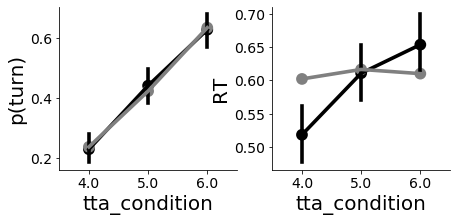

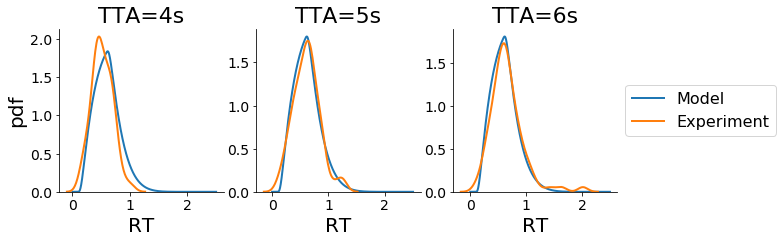

In [529]:
visualize_model_fit(exp_data, fit_model_collapse)

### DDM with drift proportional to inverse TTA?

### DDM with tta-dependent bounds?

The effect that I want to capture is that close to $\tau_{crit}$ the accumulation should become faster...

# Custom simulation

### Threshold model

In [56]:
def run_trial(condition, params, noise, n, t_max=2.5, dt=0.0001):
    tta_condition, distance_condition = condition
    noise_intensity, nondecision_time, tta_crit = params
    
    t_values = np.arange(0, t_max, dt)
    drift_rate_values = np.zeros_like(t_values)
    evidence_values = np.zeros_like(t_values)
    
    for i, t in enumerate(t_values[1:]):
        current_tta = tta_condition-t
        drift_rate = alpha*(current_tta-tta_crit)
        evidence = (evidence_values[i] + drift_rate*dt + noise[i] 
                    if t>nondecision_time else 0)
        
        drift_rate_values[i+1] = drift_rate
        evidence_values[i+1] = evidence
            
        if (abs(evidence) > boundary):
            break
        
    is_turn_decision = (evidence > boundary)
        
    return pd.DataFrame(data={'n': n,
                              't': t_values[:i+2],
                              'x': evidence_values[:i+2],
                              'd': drift_rate_values[:i+2],
                              'is_turn_decision': is_turn_decision})   

def run_sim(condition, params, n_sim=1000, t_max=2.5, dt=0.0001):
    tta_condition, distance_condition = condition
    noise_intensity, nondecision_time, tta_crit = params
    noise = np.random.randn(n_sim, int(t_max/dt))*np.sqrt(dt)
    tau = np.arange(tta_condition, 0, dt)
    trials = [run_trial(condition, params, noise[n], n, t_max, dt) for n in range(n_sim)]
    sim_result = pd.concat(trials).set_index(['n'])
    tta, distance = condition
    sim_result['tta_condition'] = tta
    sim_result['d_condition'] = distance
    
    return sim_result 

def get_model_sim_results(params):  
    return pd.concat([run_sim(condition=(tta, 90), params=params) for tta in [4, 5, 6]])

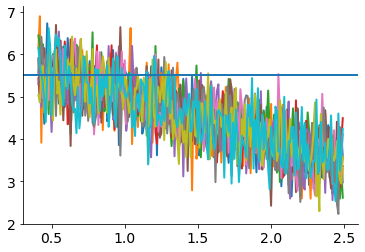

In [459]:
condition = (6, 90)
params = (0.5, 0.4, 5.5)
tta_condition, distance_condition = condition
noise_intensity, nondecision_time, tta_crit = params
n_sim=1000
t_max=2.5
dt=0.01

noise = np.random.randn(n_sim, int(t_max/dt))
tau = np.arange(tta_condition, tta_condition-t_max, -dt)
x = tau + noise_intensity*noise
x[:,tta_condition-tau<nondecision_time] = np.nan

fig, ax = plt.subplots(1)
for x_i in x[:10]:
    ax.plot(tta_condition-tau, x_i)
    
ax.axhline(tta_crit)

In [55]:
def plot_comparison(exp_measures, sim_measures):
    ax = sns.pointplot(data=exp_measures, x='tta_condition', y='is_turn_decision', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures, x='tta_condition', y='is_turn_decision', marker='o', color='grey')
    ax.set_ylabel('p(turn)')
    plt.figure()
    ax = sns.pointplot(data=exp_measures[exp_measures.is_turn_decision], 
                       x='tta_condition', y='RT', marker='o', color='k', ls='-')
    sns.pointplot(ax=ax, data=sim_measures[sim_measures.is_turn_decision], 
                  x='tta_condition', y='RT', marker='o', color='grey')
    
def plot_ddm_traces(sim_data, axes=None):
    turn_rate = sim_data.groupby('n').is_turn_decision.last().mean()
    mean_turn_rt = sim_data[sim_data.is_turn_decision].groupby('n').t.last().mean()
    
    if axes is None:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), sharex=True)
        axes = (ax1, ax2, ax3)
    else:
        (ax1, ax2, ax3) = axes
     
    for n, traj in sim_data.groupby('n'):
        is_turn_decision = traj.is_turn_decision.iloc[-1]
        color = 'C1' if is_turn_decision else 'C2'
        alpha = 0.3 if is_turn_decision else 0.1
        ax1.plot(traj.t, traj.x, color=color, alpha=alpha)
        ax2.plot([traj.t.values[-1]], [traj.d.values[-1]], color=color, marker='o', alpha=alpha)
    
    response_times = sim_data[sim_data.is_turn_decision].groupby('n').t.last()
    sns.kdeplot(ax=ax3, data=response_times, color='C1', shade=True, legend=False)
    
    for ax in axes:
        ax.set_xlim((0, response_times.max()))

    ax1.set_ylabel('evidence $x$')
    ax2.set_ylabel('$tta-tta_{crit}$')
    ax3.set_ylabel('probability')    
    
    ax1.set_xlabel('time $t$')
    ax2.set_xlabel('time $t$')
    ax3.set_xlabel('RT')
    
    ax2.set_title('Turn rate$=%.f\%%$, mean turn RT $=%.2f$s' % (100*turn_rate, mean_turn_rt))
    plt.subplots_adjust(hspace=0.2)
    sns.despine(trim=True, offset=5)
    
    return axes

Wall time: 1min


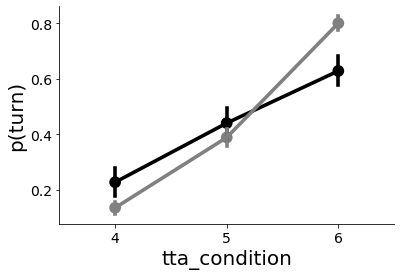

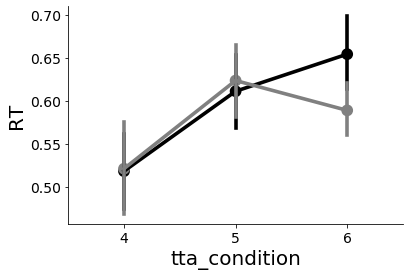

In [57]:
%time sim_results = get_model_sim_results(params=(1,1,4.5))
sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
exp_measures = pd.read_csv('measures.csv')
plot_comparison(exp_measures, sim_measures)

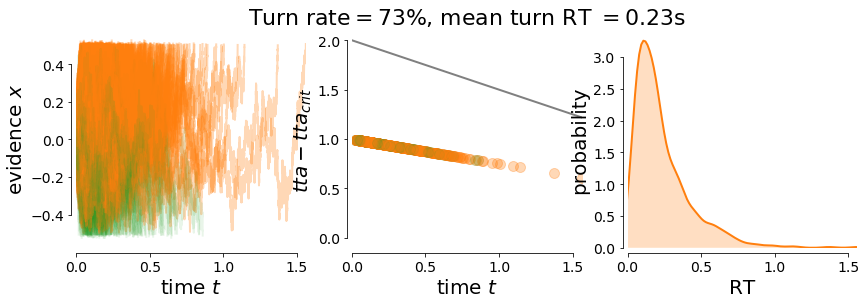

In [46]:
plot_ddm_traces(sim_results[sim_results.tta_condition==4]);

In [141]:
def model_error_wls_per_condition(sim_measures, exp_measures):
    # weighted least squares fitting, as described in Ratcliff & Tuerlinckx 2002   
    p_exp = exp_measures.is_turn_decision.mean()
    p_model = sim_measures.is_turn_decision.mean()
    delta_p = (p_model - p_exp)**2

    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    model_rt_quantiles = sim_measures[sim_measures.is_turn_decision].RT.quantile(rt_quantiles)
    exp_rt_quantiles = exp_measures[exp_measures.is_turn_decision].RT.quantile(rt_quantiles)    
    
    return 4*delta_p + np.dot((model_rt_quantiles-exp_rt_quantiles)**2, rt_q_weights)*p_exp

def model_error_wls(sim_measures, exp_measures):
    error = [model_error_wls_per_condition(sim_measures[sim_measures.tta_condition==tta],
                                           exp_measures[exp_measures.tta_condition==tta]) for tta in [4, 5, 6]]
    return sum(error)

def f_wls(params):    
    exp_measures = pd.read_csv('measures.csv')
    sim_results = get_model_sim_results(params)
    sim_measures = (sim_results.groupby(['tta_condition', 'n']).last().reset_index()
                    .rename(columns={'t': 'RT'}).drop(columns=['n', 'x', 'd']))
    f = model_error_wls(sim_measures, exp_measures)
    print(f, params)
    return f

In [65]:
# alpha, boundary, tta_crit = params
ranges = (slice(0.1, 3.2, 1.0), slice(0.1, 3.2, 1.0), slice(4.0, 5.1, 0.5))
%time params_opt, fval, grid, jout = optimize.brute(f_wls, ranges=ranges, Ns=2, full_output=True, finish=None)

2.787442727819862
2.783386489843026
2.8332460458188757
1.6485192251859284
1.9179245828287628
1.7360595502260614
13.860893945353602
13.566686608641302
13.834017791780667
28.168151934621545
29.747443670987792
28.21839090300231
2.793772186940395
2.734440521313453
2.713832849598502
0.6678972157909966
0.37700493750527886
0.5249226255777395
1.6950880536775315
2.4186959848325866
2.5030809990488336
nan
nan
nan
2.880906686793896
2.685083521153019
2.5770801646664134
1.5250714931285358
1.0190486002103278
0.9609450879485784
0.9567267518226564
nan
nan
nan
nan
nan
3.049041003695492
2.6992237470908336
2.515207890474943
2.280203290332218
1.3720435918194673
nan
nan
nan
nan
nan
nan
nan
Wall time: 1h 26min 52s


In [142]:
i, j, k = np.unravel_index(np.nanargmin(jout), jout.shape)
params_opt = [grid[0][i][0][0], grid[1][0][j][0], grid[2][0][0][k]] 
%time f_wls(params_opt)

0.3547671013430629 [1.1, 1.1, 4.5]
Wall time: 1min 18s


0.3547671013430629

* Threshold on noisy percept of tau-tau_crit + non-decision time
* DDM with linearly collapsing bound
* DDM with exponentially collapsing bound    